In [1]:
import os, glob, json
import pickle, dill
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir) ## CHANGE CSID
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)
    
from utils import *
STANZA_DIR

john10
scr1
/john10/scr1/yiweil
Using Δ|&#8710;|∆|!delta as regex for comments awarding delta.
Found 422 conversations which are manually checked to be true climate convos.


'/nlp/u/yiweil/combined_stanza_output_with_ner_embed_removed'

In [2]:
with open('URL_DOMAINS_TO_EXCLUDE.txt','r') as f:
    domains_to_exclude = f.read().splitlines()
print(f"Excluding URLs from {len(domains_to_exclude)} domains:")
print(domains_to_exclude)

Excluding URLs from 43 domains:
['', 'addons.mozilla', 'vimeo.com', 'scribd.com', 'i2.wp.com', 'gfycat.com', 'redditenhacementsuite', 'www\\.fanfiction\\.net', 'ri.search.yahoo.com', 'i0.kym-cdn.com', 'qph.ec.quoracdn.net', 'youtu', 'ff2ebook.com', 'open.spotify.com', 'i.ytimg.com', 'voat.co', 'soundcloud.com', 'twitter', '25.media.tumblr.com', 'lmgtfy.com', 'encrypted-tbn0.gstatic.com', 's-media-cache-ak0.pinimg', 's3.amazonaws.com', 'instagram.com', 'i216.photobucket.com', 'greasyfork', 'media.giphy.com', 'img1.wikia.nocookie.net', 'pastebin', 'images.app.goo.gl', '4.bp.blogspot', 'reddit', 'i.pinimg.com', 'facebook.com', 'youtube', 'duckduckgo.com', 'i.redd.it', 'google', 'lh3.googleusercontent.com', 'knowyourmeme.com', 'mashable.com', 'chrome.google', 'imgur']


In [3]:
from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/convokit_corpora/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

corp_to_analyze = {'full_cmv': None}#,'gen_reddit': None,'switchboard':None}
#corp_to_analyze.update({'matched_cmv_subsample': None})

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    convo = corp_to_analyze[corp_name].get_conversation(utt.id)
                    meta_dict = utt.meta
                    for key in meta_dict:
                        convo.add_meta(key, meta_dict[key])
                    convo.speaker = utt.speaker
                        
        print("Annotating {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample','full_cmv'}:
            print("Annotating generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'generic_dict_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
        print("Distribution of generic comments:")
        print(Counter([utt.meta['is_generic'] for utt in corp_to_analyze[corp_name].iter_utterances()
              if utt.id[:2]=='t1']))
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.text = cleanup(utt.text)
            
        print("Annotating removed/deleted comments in {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_removed'] = (utt.text == '[removed]') or (utt.text == '[deleted]')
            
        print("Annotating path information w/ version ignoring OP...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if (utt.id[:2] == 't1') and (utt.meta['outcome'] != -1):
                utt.meta['path_to_outcome_OP_removed'] = get_path_to_outcome_utt(corp_to_analyze[corp_name],
                                                                                 utt, 
                                                                                 ignore_OP=True,
                                                                                 ignore_removed=False)
        
        print("Distribution of valid utterances:")
        print(Counter([is_valid_utt(utt) for utt in corp_to_analyze['full_cmv'].iter_utterances()
                       if utt.id[:2]=='t1']))
        
        print("Distribution of delta outcomes:")
        print(Counter([utt.meta['outcome'] for utt in corp_to_analyze['full_cmv'].iter_utterances()
              if utt.id[:2]=='t1']))
        
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['text_urls'] = get_urls(utt.text)
            utt.meta['url_domains'] = [get_url_domain(u_) for u_ in utt.meta['text_urls']]
            utt.meta['num_urls'] = len([x for x in utt.meta['url_domains'] 
                                        if (x[0] not in domains_to_exclude)
                                        and (x[1] not in domains_to_exclude)])
            utt.meta['has_url'] = utt.meta['num_urls'] > 0

Loading corpus: full_cmv...
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Annotating full_cmv...
Filtering moderators and speakers with usernames ending in '-bot'...
Found 3155486 non-deleted/removed utterances not written by a bot or moderator.


Annotating generic utterances from full_cmv...


3243830it [00:25, 125788.22it/s]


Filtering to 2932326 non-generic comments.
Number of Speakers: 207110
Number of Utterances: 3243830
Number of Conversations: 84258


Distribution of generic comments:
Counter({False: 2905983, True: 253589})
Removing footnotes and in-line embedded text from full_cmv...


3243830it [01:23, 38643.49it/s]


Annotating removed/deleted comments in full_cmv...


3243830it [00:26, 123274.74it/s]


Annotating path information w/ version ignoring OP...


3243830it [00:46, 70456.90it/s]


Distribution of valid utterances:
Counter({True: 2824502, False: 335070})
Distribution of delta outcomes:
Counter({-1: 1919491, '-delta': 1204715, '+delta': 35366})


3243830it [02:40, 20182.39it/s]


In [4]:
def get_utt(utt_id,corp=corp_to_analyze['full_cmv']):
    return corp.get_utterance(utt_id)

# (Copied from utils.py)
def is_valid_utt(utt):
    """
    Returns whether an utterance meets the following criteria: 
    1) is not removed/deleted; 
    2) is not empty; 
    3) is not generic; 
    4) is not written by a bot/moderator.
    """
    return (not utt.meta['is_removed']) and (not is_empty_utt(utt)) and (not utt.meta['is_generic']) \
       and (not utt.meta['written_by_bot']) 

def meets_datapoint_criteria(utt, corp=corp_to_analyze['full_cmv'], exclude_OP=True):
    """
    Returns whether an utterance should be counted when analyzing a subtree datapoint by checking whether:
    1) it is valid (see `is_valid_utt()`);
    2) it is not written by OP;
    3) it is at least 6 tokens OR has a URL.
    """
    if exclude_OP:
        return is_valid_utt(utt) and (not is_OP_utt(corp, utt)) and \
           ((len(utt.text.split())>=6) or \
            (utt.meta['has_url']))
    else:
        return is_valid_utt(utt) and \
           ((len(utt.text.split())>=6) or \
            (utt.meta['has_url']))
    
def get_path_to_outcome(subtree_outcome_utt, excl_OP=True):
    if excl_OP:
        path_to_outcome_OP_removed = subtree_outcome_utt.meta['path_to_outcome_OP_removed']
        path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome_OP_removed
                                      if get_utt(u_id).meta['meets_datapoint_crit_excl_OP']]
    else:
        path_to_outcome = subtree_outcome_utt.meta['path_to_outcome']
        path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome
                                          if get_utt(u_id).meta['meets_datapoint_crit_with_OP']]
    return path_to_outcome_valid_utts

def get_subtree_score(feat, model_type, subtree_outcome_utt, excl_OP=True, get_text=False):
    """
    Returns the subtree-level score for a given feature `feat`, model type `model_type`, and subtree
    as indexed by its outcome utt `subtree_outcome_utt` by taking the sum of the component comments' values
    (excl.) OP's.
    """
    if feat == 'senti_pos_arousal':
        return subtree_outcome_utt.meta['reg_feats'][f'senti_{model_type}_subtree'][0]
    elif feat == 'senti_neg_arousal':
        return subtree_outcome_utt.meta['reg_feats'][f'senti_{model_type}_subtree'][1]
    elif feat in {'depth','total_num_words','mean_num_words','order','rel_timestamp','abs_timestamp'}:
        return subtree_outcome_utt.meta['reg_feats'][feat]
    else:
        if excl_OP:
            path_to_outcome_OP_removed = subtree_outcome_utt.meta['path_to_outcome_OP_removed']
            path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome_OP_removed
                                          if get_utt(u_id).meta['meets_datapoint_crit_excl_OP']]
        else:
            path_to_outcome = subtree_outcome_utt.meta['path_to_outcome']
            path_to_outcome_valid_utts = [u_id for u_id in path_to_outcome
                                          if get_utt(u_id).meta['meets_datapoint_crit_with_OP']]
            
        if get_text:
            subtree_text = [get_utt(u_id).text for u_id in path_to_outcome_valid_utts]
            return subtree_text
        
        if model_type == None:
            return sum([get_utt(u_id).meta['reg_feats'][feat] for u_id in path_to_outcome_valid_utts])
        else:
            return sum([get_utt(u_id).meta['reg_feats'][f'{feat}_{model_type}'] 
                        for u_id in path_to_outcome_valid_utts])

In [5]:
# Examine distribution of utterances meeting all criteria for inclusion 
for utt in tqdm(corp_to_analyze['full_cmv'].iter_utterances()):
    utt.meta['meets_datapoint_crit_excl_OP'] = meets_datapoint_criteria(utt)
    utt.meta['meets_datapoint_crit_with_OP'] = meets_datapoint_criteria(utt, exclude_OP=False)
print("Distribution of comments meeting all datapoint criteria:")
print(Counter([utt.meta['meets_datapoint_crit_excl_OP'] for utt in corp_to_analyze['full_cmv'].iter_utterances()]))
print("Distribution of comments meeting all datapoint criteria, incl. OP's:")
print(Counter([utt.meta['meets_datapoint_crit_with_OP'] for utt in corp_to_analyze['full_cmv'].iter_utterances()]))

3243830it [02:24, 22486.58it/s]


Distribution of comments meeting all datapoint criteria:
Counter({True: 2225370, False: 1018460})
Distribution of comments meeting all datapoint criteria, incl. OP's:
Counter({True: 2765330, False: 478500})


All features:
* Emotionality
    * SentiStrength (+/-) arousal (`senti_<pos/neg>_arousal_<all/adxs_only>`)
    * NRC valence, arousal (`nrc_<val/arousal>_<all/adxs_only>`)
    * EmoLex emotion intensity scores (`emo_<emotion>_<all/adxs_only>`)
    * MFD (`mfd_<foundation>_<vice/virtue>_<all/adxs_only>`)
    * ***later: hybrid classifier approach***
* Evidentiality
    * `has_evidence`
    * `num_evidence_chunks`
    * `num_evidence_kws` (more as a foil)
    * `num_urls` (also a foil)
* Structural
    * `depth`
    * `total_num_words`
    * `mean_num_words`
    * `order`
    * `rel_timestamp`
    * `abs_timestamp`

In [6]:
# Load all cached features for populating `counted_lemma`-related columns in `reg_df`

print("Loading cached features...")
corp_name = 'full_cmv'
all_senti_scores = pickle.load(open('{}_senti_scores.pkl'.format(corp_name),'rb'))
senti_scores_dict = {model: {item[0]: item[1] for item in all_senti_scores[model]}
                         for model in all_senti_scores}
del all_senti_scores
nrc_cache = pickle.load(open(f'VAD_scores_{corp_name}.pkl','rb'))
emolex_cache = pickle.load(open(f'emolex_scores_{corp_name}.pkl','rb'))
mfd_cache = dill.load(open(f'MFD_scores_{corp_name}.pkl','rb'))
print("Done loading!")

def get_counted_lemmas(path_to, model):
    #path_to = get_path_to_outcome(get_utt(subtree_id))
    #print(path_to)
    emo_lemms = flatten([emolex_cache[u_id]['lemms_per_model'][model].values() for u_id in path_to])
    count_key = 'counted_lemmas' if model == 'all' else 'counted_adxs'
    #print(emo_lemms)
    #print(flatten(emo_lemms))
    return {'nrc': Counter(flatten([nrc_cache[u_id][model]['lemmas'] for u_id in path_to])), 
            'emo': Counter([item for sublist in emo_lemms for item in sublist]),
            'mfd': Counter(flatten([mfd_cache[u_id][count_key] for u_id in path_to]))}

Loading cached features...
Done loading!


In [3]:
reg_df = pd.read_pickle('full_cmv_subtrees_reg_df.pkl')
print(f"Read in regression df w/ {len(reg_df)} rows.")
# reg_df['path_to'] = reg_df['subtree_outcome_utt_id'].apply(lambda x:
#                                                           get_path_to_outcome(get_utt(x)))
# reg_df = reg_df.loc[reg_df['path_to'].apply(lambda x: len(x) > 0)].copy()
# print(f"Subsetting to {len(reg_df)} datapoints with at least one valid non-OP comment in subtree.")

# reg_df['subtree_text'] = reg_df['subtree_outcome_utt_id'].apply(
#     lambda x: get_subtree_score(None, None, get_utt(x), get_text=True))
# reg_df['counted_lemmas_all'] = reg_df['path_to'].apply(lambda x: get_counted_lemmas(x, 'all'))
# reg_df['counted_lemmas_adxs'] = reg_df['path_to'].apply(lambda x: get_counted_lemmas(x, 'adxs_only'))
# del nrc_cache
# del emolex_cache
# del mfd_cache
# for model in tqdm(['all','adxs']):
#     reg_df[f'counted_nrc_{model}'] = reg_df[f'counted_lemmas_{model}'].apply(lambda x: x['nrc'])
#     reg_df[f'counted_emo_{model}'] = reg_df[f'counted_lemmas_{model}'].apply(lambda x: x['emo'])
#     reg_df[f'counted_mfd_{model}'] = reg_df[f'counted_lemmas_{model}'].apply(lambda x: x['mfd'])

# Get overall emotion intensity score by summing over 8 emotions
EMOLEX_EMOS = ['fear','anger','sadness','disgust','anticipation','joy','trust','surprise']
for model in ['all','adxs_only']:
    reg_df[f'emo_total_{model}'] = reg_df[[f'emo_{emo}_{model}' for emo in EMOLEX_EMOS]].sum(axis=1)
    
# Get overall morality score by summing over 10 foundations
MFD_FOUNDS = ['authority','purity','fairness','harm','loyalty']
MFD_FOUNDS = [f'{found}_{valence}' for found in MFD_FOUNDS for valence in ['virtue','vice']]
for model in ['all','adxs_only']:
    reg_df[f'mfd_total_{model}'] = reg_df[[f'mfd_{FOUND}_{model}' for FOUND in MFD_FOUNDS]].sum(axis=1)
    
# Take absolute value of SS neg. arousal
for model in ['all','adxs_only']:
    reg_df[f'senti_neg_arousal_{model}'] = abs(reg_df[f'senti_neg_arousal_{model}'])
    
# Log transform count variables
for count_var in ['total_num_words','mean_num_words','rel_timestamp','abs_timestamp',
                      'num_urls','num_evidence_kws','num_evidence_chunks',
                      'emo_total_all','nrc_val_all','nrc_arousal_all',
                     'emo_total_adxs_only','nrc_val_adxs_only','nrc_arousal_adxs_only']:
        reg_df[f'log_{count_var}'] = np.log(reg_df[count_var]+.1)
    
# Get dummy variables for `has_evidence`, `has_evidence_kw`, `has_url`, `outcome`
reg_df['has_evidence'] = reg_df['num_evidence_chunks'].apply(lambda x: x>0)
reg_df['has_evidence_kw'] = reg_df['num_evidence_kws'].apply(lambda x: x>0)
reg_df['has_url'] = reg_df['num_urls'].apply(lambda x: x>0)
#reg_df = pd.get_dummies(reg_df, columns=['outcome'], drop_first=True)
reg_df = pd.get_dummies(reg_df, columns=['has_evidence','has_evidence_kw','has_url','outcome'], drop_first=True)
reg_df['outcome'] = reg_df['outcome_-delta'].apply(lambda x: abs(1-x))

print(reg_df.shape) # the # of (outcome) subtrees
display(reg_df.head(10))

Read in regression df w/ 1203509 rows.
(1203509, 97)


,subtree_outcome_utt_id,conversation_id,timestamp,senti_pos_arousal_all,senti_pos_arousal_adxs_only,senti_neg_arousal_all,senti_neg_arousal_adxs_only,nrc_val_all,nrc_val_adxs_only,nrc_arousal_all,...,log_nrc_val_all,log_nrc_arousal_all,log_emo_total_adxs_only,log_nrc_val_adxs_only,log_nrc_arousal_adxs_only,has_evidence_True,has_evidence_kw_True,has_url_True,outcome_-delta,outcome
0,t1_djhcrq8,t3_6juc9p,1.498598e+09,3,3,3,3,63.556,8.970,47.268,...,4.153494,3.857947,1.386294,2.204972,2.007274,0,0,0,1,0
1,t1_csajf84,t3_3a7ys8,1.434584e+09,3,3,3,3,70.269,9.957,45.023,...,4.253753,3.809392,2.494857,2.308269,1.940179,1,0,0,1,0
2,t1_g99brae,t3_jdn5or,1.603054e+09,2,2,2,2,32.448,6.611,19.296,...,3.482716,2.965067,0.764072,1.903748,1.577328,0,0,0,1,0
3,t1_cqxesmu,t3_34rgpv,1.430694e+09,3,3,3,3,43.035,6.274,29.344,...,3.764335,3.382490,0.806476,1.852227,1.536867,0,0,0,1,0
4,t1_cgmavct,t3_22dcc4,1.396818e+09,3,3,3,3,38.548,6.213,28.587,...,3.654495,3.356444,-0.056570,1.842611,1.673726,0,0,0,1,0
5,t1_czbzlk5,t3_42j5z4,1.453697e+09,4,4,3,3,223.679,27.964,144.797,...,5.410659,4.976023,3.085939,3.334488,3.075560,1,1,0,1,0
6,t1_e2xnv4w,t3_90wbso,1.532270e+09,2,1,2,2,33.837,1.473,26.122,...,3.524506,3.266599,0.554460,0.452985,0.862468,0,0,0,1,0
7,t1_dzk8x5u,t3_8m210m,1.527261e+09,1,1,1,1,17.457,1.125,11.895,...,2.865453,2.484490,-2.302585,0.202941,-0.375421,0,0,0,0,1
8,t1_ejku9e0,t3_b6ine5,1.553780e+09,2,2,4,4,37.931,5.976,25.421,...,3.638402,3.239502,1.405116,1.804347,1.759236,0,0,0,1,0
9,t1_co6kzpf,t3_2ua80f,1.422686e+09,2,2,2,1,43.574,2.559,29.094,...,3.776753,3.373963,-0.022246,0.977950,0.549277,0,0,0,1,0


In [8]:
print(reg_df['outcome'].value_counts())
print(reg_df['outcome'].value_counts()/sum(reg_df['outcome'].value_counts()))

print(reg_df['has_evidence_True'].value_counts())
print(reg_df['has_evidence_True'].value_counts()/sum(reg_df['has_evidence_True'].value_counts()))

print(reg_df['has_evidence_kw_True'].value_counts())
print(reg_df['has_evidence_kw_True'].value_counts()/sum(reg_df['has_evidence_kw_True'].value_counts()))

print(reg_df['has_url_True'].value_counts())
print(reg_df['has_url_True'].value_counts()/sum(reg_df['has_url_True'].value_counts()))

0    1109423
1      33433
Name: outcome, dtype: int64
0    0.970746
1    0.029254
Name: outcome, dtype: float64
0    990228
1    152628
Name: has_evidence_True, dtype: int64
0    0.86645
1    0.13355
Name: has_evidence_True, dtype: float64
0    959419
1    183437
Name: has_evidence_kw_True, dtype: int64
0    0.839492
1    0.160508
Name: has_evidence_kw_True, dtype: float64
0    1087196
1      55660
Name: has_url_True, dtype: int64
0    0.951297
1    0.048703
Name: has_url_True, dtype: float64


# Understand correlations w/ delta outcome

In [9]:
import statsmodels.discrete.discrete_model as sm

Here's what appears to be going on:
* length (total/mean #words) is positively correlated w/ delta (boxplots; t-tests)
    * when add intercept to minimal regression, we get (+) coeff. for len--good
* length is positively correlated w/ #evidence kws and #urls, but coefficients are small (scatterplot; pearson coeff.)
    * therefore, we expect #evidence kws/#urls to be positively correlated w/ delta
    * however, when we check boxplots/t-tests, the features have such long-tailed distributions (mostly 0s) that median, 25%, 75% pcts are all equal, and lots of outliers
    * therefore, we can try restricting to subtrees w/ non-zero values, and also removing outliers: now, it appears -delta subtrees actually have more #evidence kws/#urls than +delta subtrees (boxplot; t-test)
        * in other words, (+) corr. b/w length and #ev. keywords/#urls is probably mostly due to 0s and outliers; 
        * though this doesn't quite check out w/ redone scatterplot/pearson coeff...
    * and therefore, we expect regression coeffs. (w/ intercepts) to be (-)--both check out!
* length is (+) correlated w/ model-predicted #evidence chunks
    * therefore, we expect #evidence chunks to be + correlated w/ delta
    * indeed, we see this to be the case with t-test/boxplots (and subsetting to non-0 values, removing outlifers)
    * and therefore, we expect + regression coeff.--checks out!
* so overall, # model-predicted evidence chunks is (+) corr. w/ length, but #urls and #evidence kws is less so?

In [10]:
def do_delta_outcome_corr(df_,ind_var,outlier_thresh=.97,log_smoothing=.5,showfliers=False):
    
    df_ = df_.copy()
    og_n = len(df_)
    
    for incl_zeros in [True, False]:
        for incl_outliers in [True, False]:
            for log_transform in [False, True]:
    
                if incl_zeros:
                    print("Including zero values.")
                else:
                    print("Excluding zero values...")
                    df_ = df_.loc[df_[ind_var]!=0].copy()
                    print(f"\tremoved {og_n-len(df_)} rows")

                if incl_outliers:
                    print("Including outliers.")
                else:
                    print("Excluding outliers...")
                    q_hi = df_[ind_var].quantile(outlier_thresh)
                    df_ = df_.loc[df_[ind_var] < q_hi].copy()
                    print(f"\tremoved {og_n-len(df_)} rows")

                if log_transform:
                    print("Using log-transformed ind. var.")
                    df_[f'log_{ind_var}'] = np.log(df_[ind_var]+log_smoothing)
                    ind_var = f'log_{ind_var}'
                else:
                    print("Using raw ind. var (no log-transforming).")
                    ind_var = ind_var.split('log_')[-1]

                # do t-test
                t, p_val = stats.ttest_ind(df_.loc[df_['outcome']==1][ind_var].values,
                                           df_.loc[df_['outcome']==0][ind_var].values)

                # do boxplot
                fig, ax = plt.subplots(figsize=(6,4))
                sns.boxplot(data=df_,x='outcome',y=ind_var,showfliers=showfliers,ax=ax)
                ax.set_xticklabels(['-delta','+delta'],fontsize=20)
                ax.set_xlabel("")
                ax.set_ylabel(ind_var.capitalize(),fontsize=20)
                comp = 'greater' if t > 0 else 'smaller'
                ax.set_title(f"+delta subtrees have {comp} {ind_var} \nvalues on average ($t={round(t,2)}, p={round(p_val,3)}$)",fontsize=20)
                plt.show()

                # do minimal regression
                fit_ = sm.Logit.from_formula(f'outcome ~ {ind_var}', data=df_).fit()
                print(fit_.summary())

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


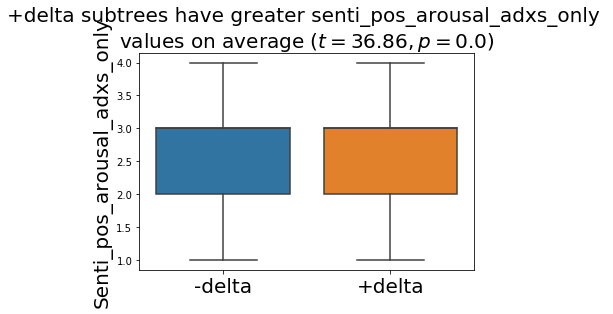

Optimization terminated successfully.
         Current function value: 0.131539
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.004538
Time:                        12:06:29   Log-Likelihood:            -1.5033e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                5.293e-300
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.0730      0.017   -239.487      0.000   

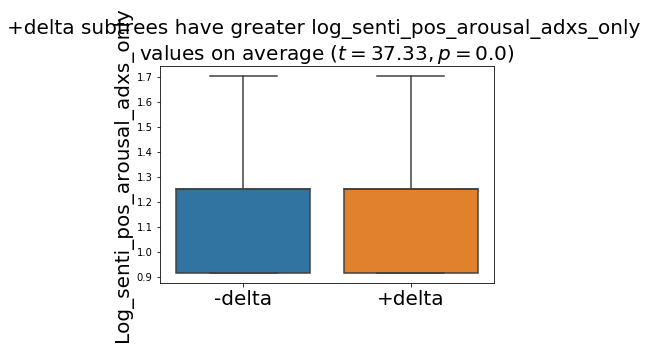

Optimization terminated successfully.
         Current function value: 0.131500
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.004835
Time:                        12:06:55   Log-Likelihood:            -1.5029e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.1719      0.019   -214.727  

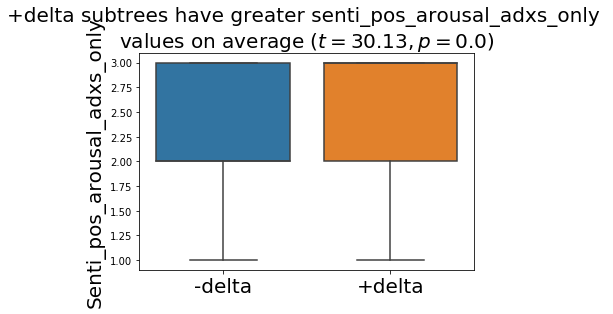

Optimization terminated successfully.
         Current function value: 0.127904
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1042130
Model:                          Logit   Df Residuals:                  1042128
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.003505
Time:                        12:07:24   Log-Likelihood:            -1.3329e+05
converged:                       True   LL-Null:                   -1.3376e+05
Covariance Type:            nonrobust   LLR p-value:                6.052e-206
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.0948      0.020   -205.738      0.000   

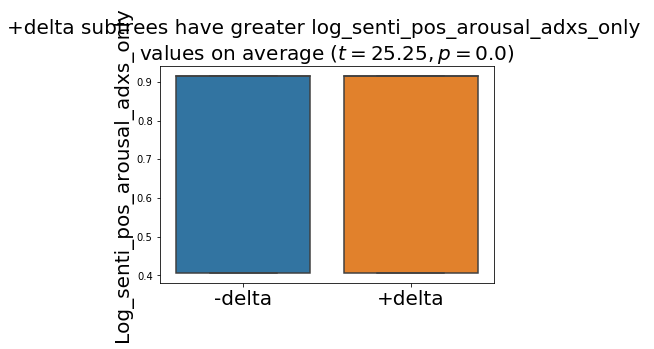

Optimization terminated successfully.
         Current function value: 0.115506
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               541726
Model:                          Logit   Df Residuals:                   541724
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.005232
Time:                        12:07:39   Log-Likelihood:                -62573.
converged:                       True   LL-Null:                       -62902.
Covariance Type:            nonrobust   LLR p-value:                3.628e-145
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.3494      0.029   -148.184  

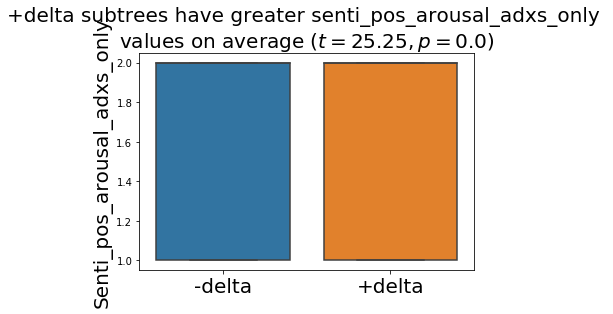

Optimization terminated successfully.
         Current function value: 0.115506
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               541726
Model:                          Logit   Df Residuals:                   541724
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.005232
Time:                        12:07:54   Log-Likelihood:                -62573.
converged:                       True   LL-Null:                       -62902.
Covariance Type:            nonrobust   LLR p-value:                3.628e-145
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.4469      0.033   -134.381      0.000   

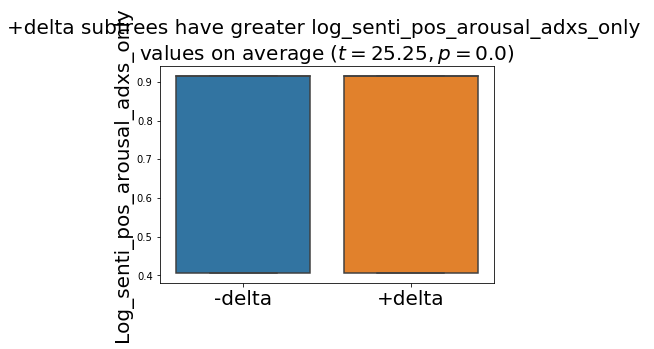

Optimization terminated successfully.
         Current function value: 0.115506
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               541726
Model:                          Logit   Df Residuals:                   541724
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.005232
Time:                        12:08:08   Log-Likelihood:                -62573.
converged:                       True   LL-Null:                       -62902.
Covariance Type:            nonrobust   LLR p-value:                3.628e-145
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -4.3494      0.029   -148.184  

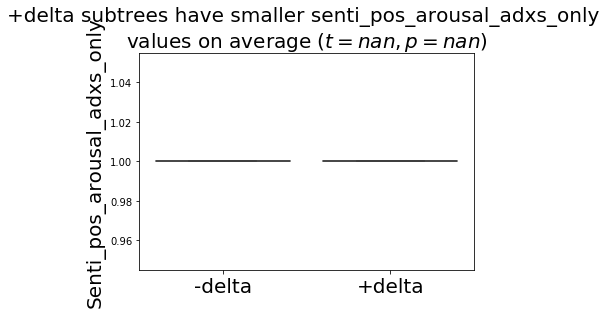

Optimization terminated successfully.
         Current function value: 0.091933
         Iterations 8


LinAlgError: Singular matrix

In [39]:
do_delta_outcome_corr(reg_df,'senti_pos_arousal_adxs_only')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


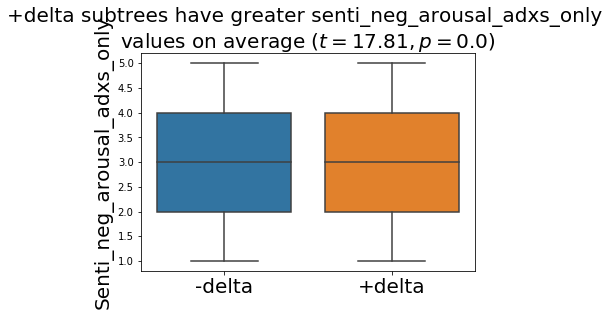

Optimization terminated successfully.
         Current function value: 0.131999
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001056
Time:                        12:09:42   Log-Likelihood:            -1.5086e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                 2.344e-71
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.7756      0.017   -227.641      0.000   

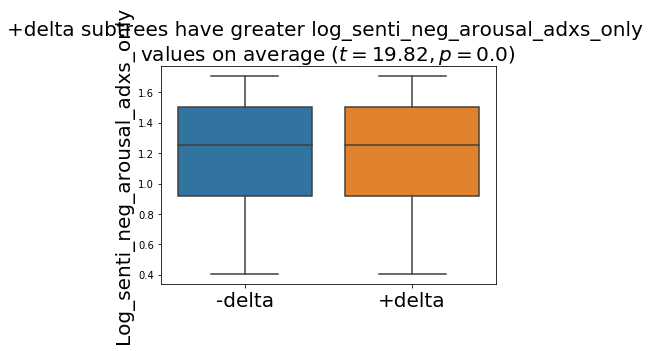

Optimization terminated successfully.
         Current function value: 0.131962
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001337
Time:                        12:10:09   Log-Likelihood:            -1.5081e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                 8.355e-90
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.8750      0.020   -194.404  

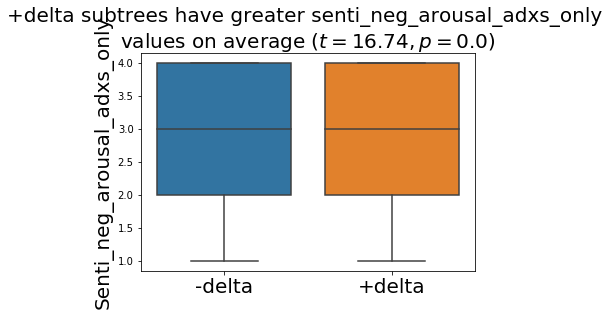

Optimization terminated successfully.
         Current function value: 0.131392
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1107154
Model:                          Logit   Df Residuals:                  1107152
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0009714
Time:                        12:10:44   Log-Likelihood:            -1.4547e+05
converged:                       True   LL-Null:                   -1.4561e+05
Covariance Type:            nonrobust   LLR p-value:                 1.765e-63
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.7801      0.017   -216.567      0.000   

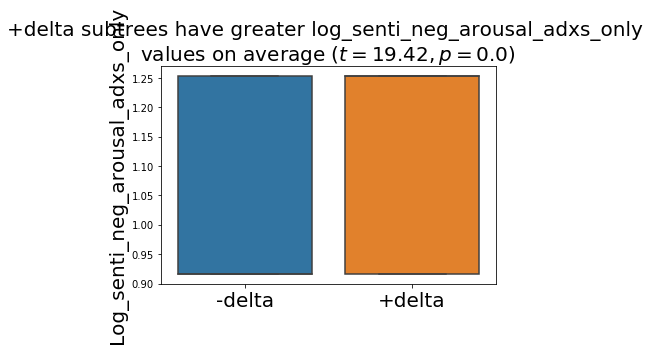

Optimization terminated successfully.
         Current function value: 0.128849
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               794331
Model:                          Logit   Df Residuals:                   794329
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001911
Time:                        12:11:29   Log-Likelihood:            -1.0235e+05
converged:                       True   LL-Null:                   -1.0254e+05
Covariance Type:            nonrobust   LLR p-value:                 3.068e-87
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.9862      0.025   -160.889  

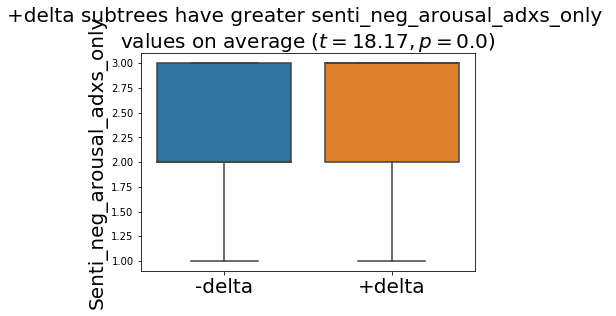

Optimization terminated successfully.
         Current function value: 0.128883
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               794331
Model:                          Logit   Df Residuals:                   794329
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001646
Time:                        12:12:16   Log-Likelihood:            -1.0238e+05
converged:                       True   LL-Null:                   -1.0254e+05
Covariance Type:            nonrobust   LLR p-value:                 2.080e-75
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.9291      0.023   -168.980      0.000   

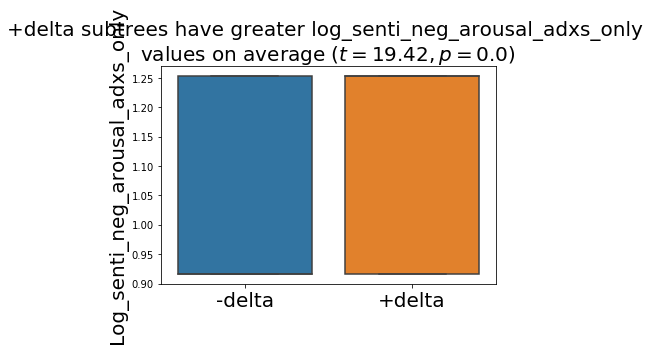

Optimization terminated successfully.
         Current function value: 0.128849
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               794331
Model:                          Logit   Df Residuals:                   794329
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001911
Time:                        12:12:42   Log-Likelihood:            -1.0235e+05
converged:                       True   LL-Null:                   -1.0254e+05
Covariance Type:            nonrobust   LLR p-value:                 3.068e-87
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.9862      0.025   -160.889  

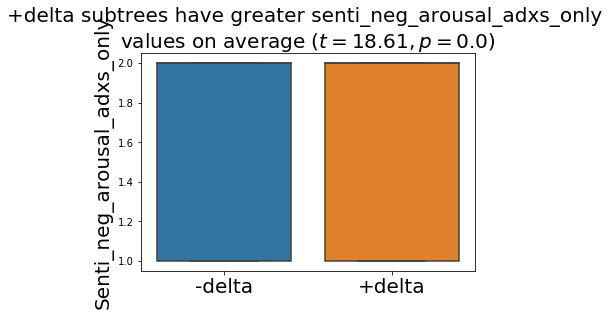

Optimization terminated successfully.
         Current function value: 0.121662
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               420860
Model:                          Logit   Df Residuals:                   420858
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.003528
Time:                        12:13:04   Log-Likelihood:                -51203.
converged:                       True   LL-Null:                       -51384.
Covariance Type:            nonrobust   LLR p-value:                 7.903e-81
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.3018      0.040   -108.464      0.000   

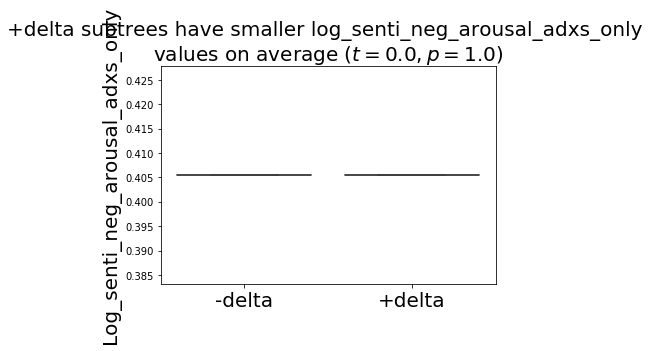

         Current function value: 0.097858
         Iterations: 35


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               141179
Model:                          Logit   Df Residuals:                   141177
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               1.808e-11
Time:                        12:13:15   Log-Likelihood:                -13815.
converged:                      False   LL-Null:                       -13815.
Covariance Type:            nonrobust   LLR p-value:                    0.9994
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          -3.3448        nan        nan        nan         nan         nan
log_senti_neg_arousal_adxs_only    -1.3549        nan        nan    

In [40]:
do_delta_outcome_corr(reg_df,'senti_neg_arousal_adxs_only')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


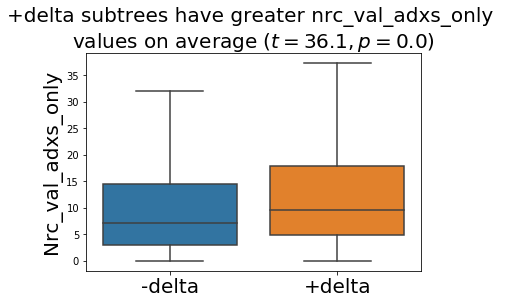

Optimization terminated successfully.
         Current function value: 0.131677
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.003499
Time:                        12:18:04   Log-Likelihood:            -1.5049e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                7.969e-232
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.6397      0.007   -519.484      0.000      -3.653      -3.626
nrc_val_

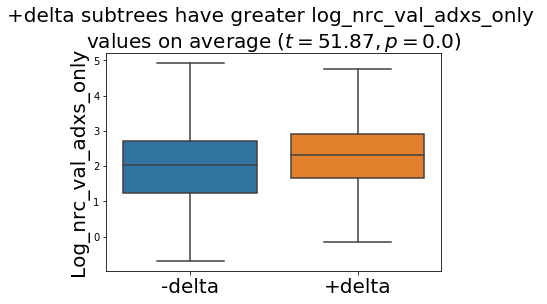

Optimization terminated successfully.
         Current function value: 0.130923
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.009201
Time:                        12:18:25   Log-Likelihood:            -1.4963e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.0901      0.013   -305.928      0.000      -4.116      -4.

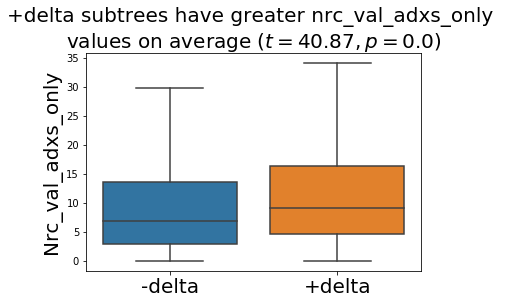

Optimization terminated successfully.
         Current function value: 0.130254
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1108570
Model:                          Logit   Df Residuals:                  1108568
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.005260
Time:                        12:18:56   Log-Likelihood:            -1.4440e+05
converged:                       True   LL-Null:                   -1.4516e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.7551      0.009   -435.474      0.000      -3.772      -3.738
nrc_val_

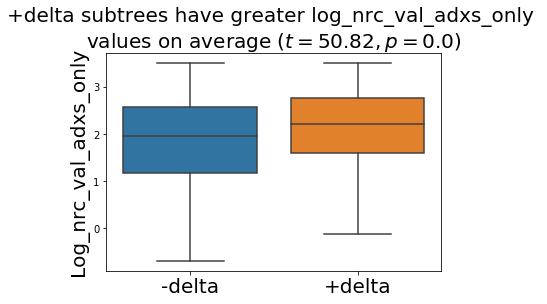

Optimization terminated successfully.
         Current function value: 0.128776
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1075308
Model:                          Logit   Df Residuals:                  1075306
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.009807
Time:                        12:19:33   Log-Likelihood:            -1.3847e+05
converged:                       True   LL-Null:                   -1.3985e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.1631      0.015   -282.718      0.000      -4.192      -4.

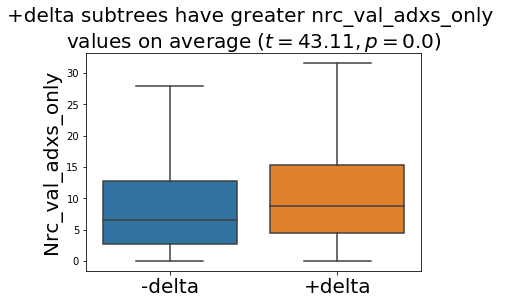

Optimization terminated successfully.
         Current function value: 0.129274
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1074957
Model:                          Logit   Df Residuals:                  1074955
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.006156
Time:                        12:21:02   Log-Likelihood:            -1.3896e+05
converged:                       True   LL-Null:                   -1.3982e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.8069      0.009   -410.117      0.000      -3.825      -3.789
nrc_val_

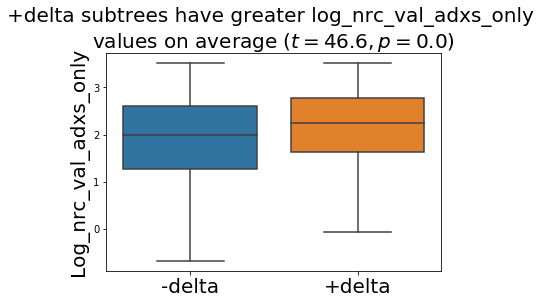

Optimization terminated successfully.
         Current function value: 0.130933
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1042347
Model:                          Logit   Df Residuals:                  1042345
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.008198
Time:                        12:21:33   Log-Likelihood:            -1.3648e+05
converged:                       True   LL-Null:                   -1.3761e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.1493      0.016   -262.030      0.000      -4.180      -4.

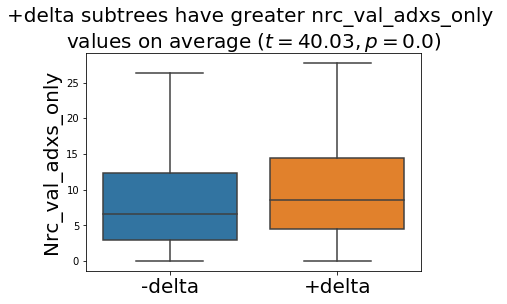

Optimization terminated successfully.
         Current function value: 0.130243
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1011075
Model:                          Logit   Df Residuals:                  1011073
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.005686
Time:                        12:22:19   Log-Likelihood:            -1.3169e+05
converged:                       True   LL-Null:                   -1.3244e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.8116      0.010   -379.159      0.000      -3.831      -3.792
nrc_val_

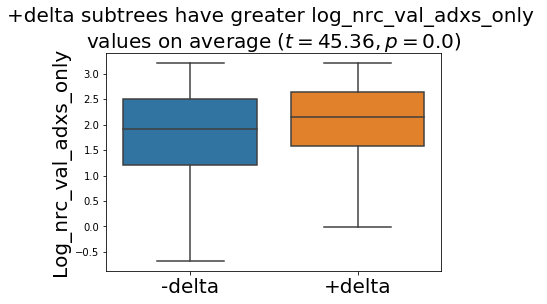

Optimization terminated successfully.
         Current function value: 0.128954
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               980735
Model:                          Logit   Df Residuals:                   980733
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.008457
Time:                        12:23:06   Log-Likelihood:            -1.2647e+05
converged:                       True   LL-Null:                   -1.2755e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -4.1927      0.017   -249.232      0.000      -4.226      -4.

In [41]:
do_delta_outcome_corr(reg_df,'nrc_val_adxs_only')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


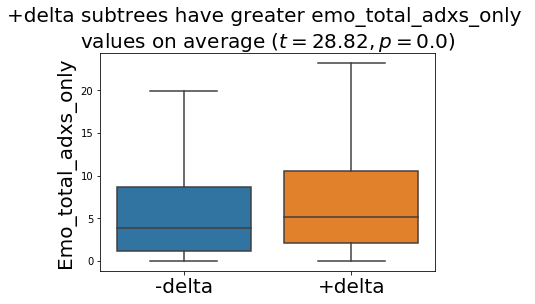

Optimization terminated successfully.
         Current function value: 0.131834
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.002306
Time:                        12:30:32   Log-Likelihood:            -1.5067e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                1.701e-153
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.6039      0.007   -531.423      0.000      -3.617      -3.591
em

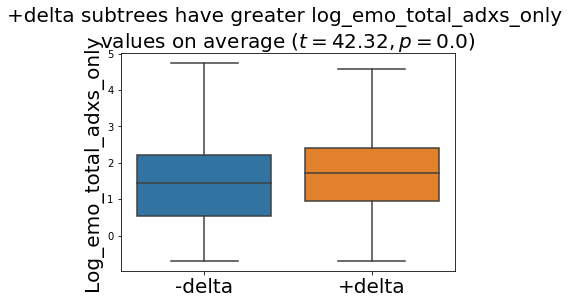

Optimization terminated successfully.
         Current function value: 0.131343
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.006026
Time:                        12:30:54   Log-Likelihood:            -1.5011e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.8057      0.010   -396.299      0.000      -3.825   

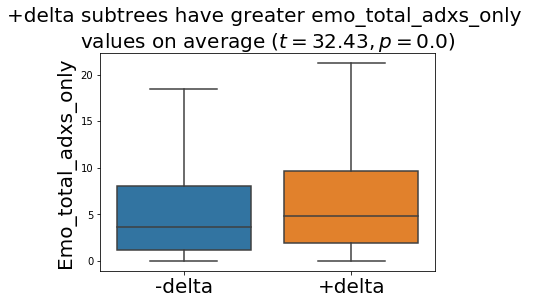

Optimization terminated successfully.
         Current function value: 0.130697
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1108570
Model:                          Logit   Df Residuals:                  1108568
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.003348
Time:                        12:31:26   Log-Likelihood:            -1.4489e+05
converged:                       True   LL-Null:                   -1.4537e+05
Covariance Type:            nonrobust   LLR p-value:                1.102e-213
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.6820      0.008   -457.679      0.000      -3.698      -3.666
em

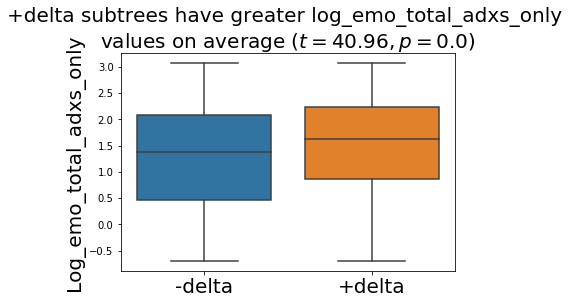

Optimization terminated successfully.
         Current function value: 0.129485
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1075311
Model:                          Logit   Df Residuals:                  1075309
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.006181
Time:                        12:31:59   Log-Likelihood:            -1.3924e+05
converged:                       True   LL-Null:                   -1.4010e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.8290      0.010   -380.425      0.000      -3.849   

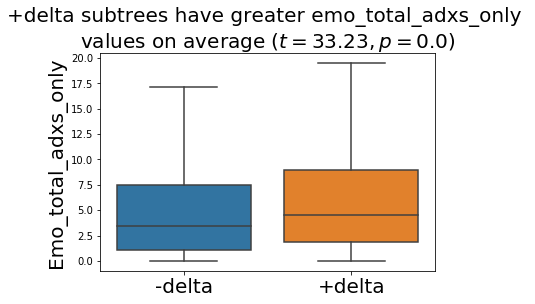

Optimization terminated successfully.
         Current function value: 0.129981
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1070750
Model:                          Logit   Df Residuals:                  1070748
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.003706
Time:                        12:32:31   Log-Likelihood:            -1.3918e+05
converged:                       True   LL-Null:                   -1.3970e+05
Covariance Type:            nonrobust   LLR p-value:                3.665e-227
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.7126      0.009   -432.546      0.000      -3.729      -3.696
em

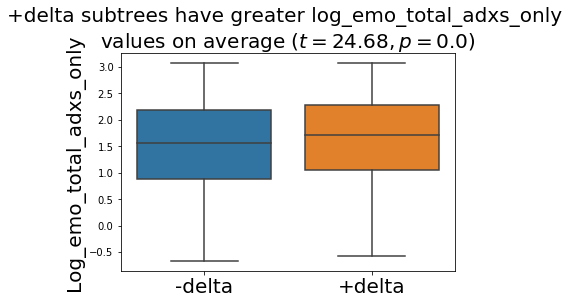

Optimization terminated successfully.
         Current function value: 0.137189
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               929767
Model:                          Logit   Df Residuals:                   929765
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.002411
Time:                        12:32:58   Log-Likelihood:            -1.2755e+05
converged:                       True   LL-Null:                   -1.2786e+05
Covariance Type:            nonrobust   LLR p-value:                4.353e-136
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.7304      0.013   -280.775      0.000      -3.756   

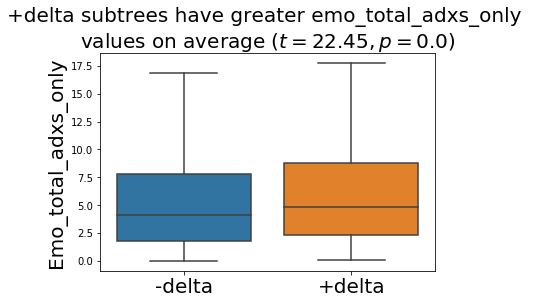

Optimization terminated successfully.
         Current function value: 0.136809
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               901867
Model:                          Logit   Df Residuals:                   901865
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001962
Time:                        12:33:36   Log-Likelihood:            -1.2338e+05
converged:                       True   LL-Null:                   -1.2363e+05
Covariance Type:            nonrobust   LLR p-value:                1.620e-107
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.6232      0.010   -360.849      0.000      -3.643      -3.604
em

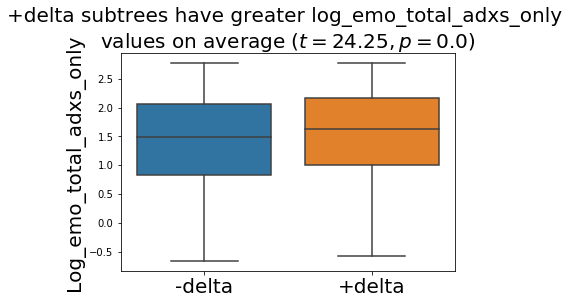

Optimization terminated successfully.
         Current function value: 0.136160
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               874800
Model:                          Logit   Df Residuals:                   874798
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.002502
Time:                        12:35:05   Log-Likelihood:            -1.1911e+05
converged:                       True   LL-Null:                   -1.1941e+05
Covariance Type:            nonrobust   LLR p-value:                5.563e-132
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.7485      0.014   -269.828      0.000      -3.776   

In [44]:
do_delta_outcome_corr(reg_df,'emo_total_adxs_only')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


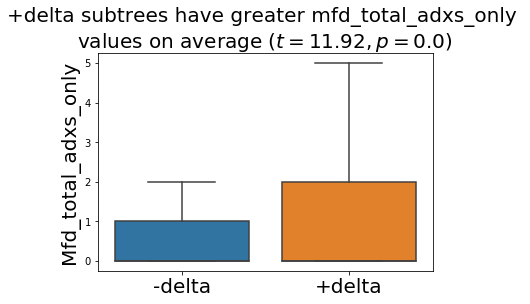

Optimization terminated successfully.
         Current function value: 0.132082
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0004291
Time:                        12:36:27   Log-Likelihood:            -1.5095e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                 4.990e-30
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.5339      0.006   -567.526      0.000      -3.546      -3.522
mf

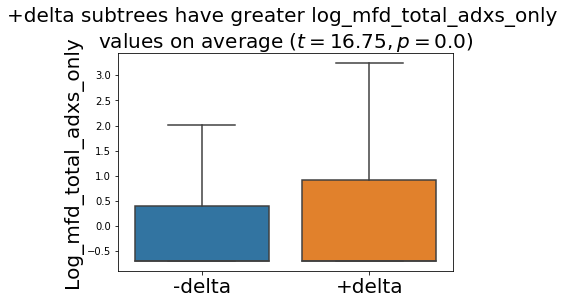

Optimization terminated successfully.
         Current function value: 0.132019
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0009058
Time:                        12:36:55   Log-Likelihood:            -1.5088e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                 1.869e-61
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.5057      0.006   -629.381      0.000      -3.517   

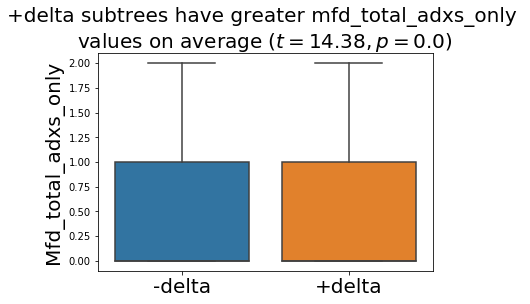

Optimization terminated successfully.
         Current function value: 0.131638
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1099538
Model:                          Logit   Df Residuals:                  1099536
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0006850
Time:                        12:37:27   Log-Likelihood:            -1.4474e+05
converged:                       True   LL-Null:                   -1.4484e+05
Covariance Type:            nonrobust   LLR p-value:                 4.597e-45
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.5594      0.007   -516.681      0.000      -3.573      -3.546
mf

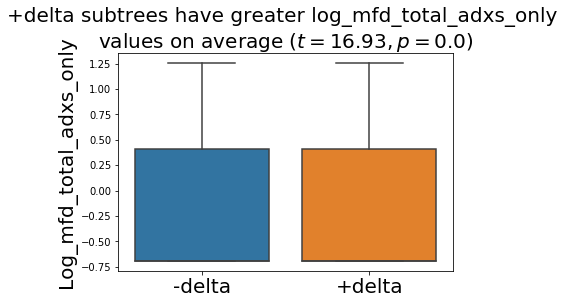

Optimization terminated successfully.
         Current function value: 0.130986
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1045842
Model:                          Logit   Df Residuals:                  1045840
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001022
Time:                        12:38:00   Log-Likelihood:            -1.3699e+05
converged:                       True   LL-Null:                   -1.3713e+05
Covariance Type:            nonrobust   LLR p-value:                 6.804e-63
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.4927      0.006   -592.011      0.000      -3.504   

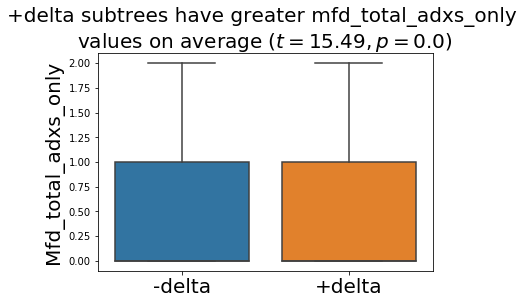

Optimization terminated successfully.
         Current function value: 0.131009
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1045842
Model:                          Logit   Df Residuals:                  1045840
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0008436
Time:                        12:38:32   Log-Likelihood:            -1.3701e+05
converged:                       True   LL-Null:                   -1.3713e+05
Covariance Type:            nonrobust   LLR p-value:                 2.990e-52
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.5737      0.007   -497.108      0.000      -3.588      -3.560
mf

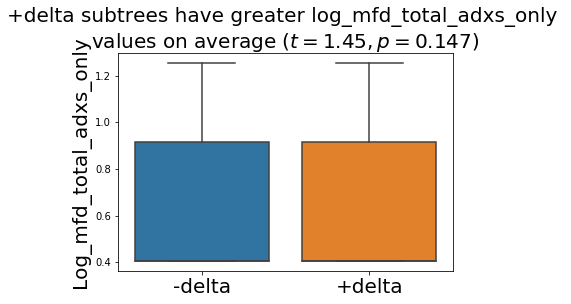

Optimization terminated successfully.
         Current function value: 0.143526
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               399027
Model:                          Logit   Df Residuals:                   399025
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               1.834e-05
Time:                        12:38:46   Log-Likelihood:                -57271.
converged:                       True   LL-Null:                       -57272.
Covariance Type:            nonrobust   LLR p-value:                    0.1473
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.4181      0.020   -167.723      0.000      -3.458   

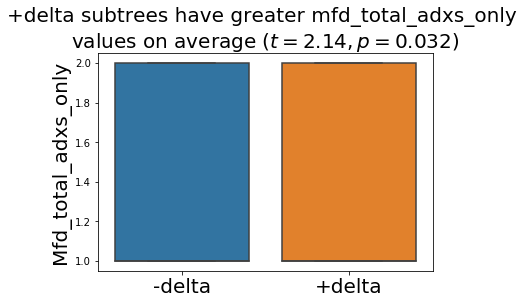

Optimization terminated successfully.
         Current function value: 0.143521
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               341350
Model:                          Logit   Df Residuals:                   341348
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               4.658e-05
Time:                        12:39:01   Log-Likelihood:                -48991.
converged:                       True   LL-Null:                       -48993.
Covariance Type:            nonrobust   LLR p-value:                   0.03265
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.4498      0.029   -119.238      0.000      -3.507      -3.393
mf

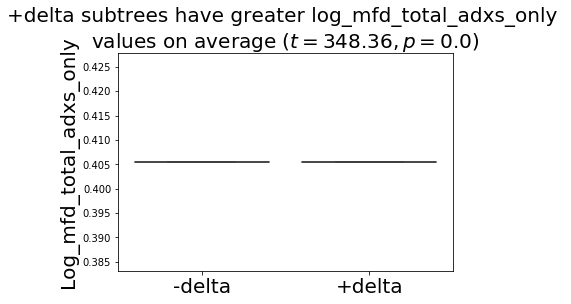

         Current function value: 0.142004
         Iterations: 35


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               231419
Model:                          Logit   Df Residuals:                   231417
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               3.263e-12
Time:                        12:39:14   Log-Likelihood:                -32862.
converged:                      False   LL-Null:                       -32862.
Covariance Type:            nonrobust   LLR p-value:                    0.9996
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.9263    7.2e+04  -4.06e-05      1.000   -1.41e+05    1.41e+05
log_mfd_total_adxs_only    -1.1830   1.78e+05  -6.66e-06      1.000   -3.48e+05    3.48e+05


In [45]:
do_delta_outcome_corr(reg_df,'mfd_total_adxs_only')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


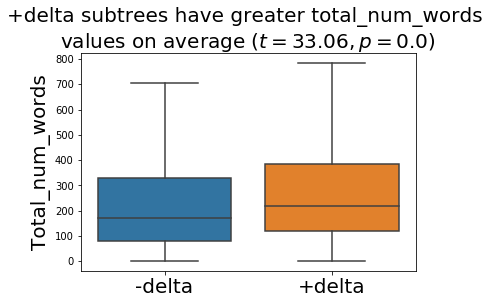

Optimization terminated successfully.
         Current function value: 0.131745
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.002982
Time:                        11:58:51   Log-Likelihood:            -1.5057e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                7.419e-198
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.6376      0.007   -508.420      0.000      -3.652      -3.624
total_num_word

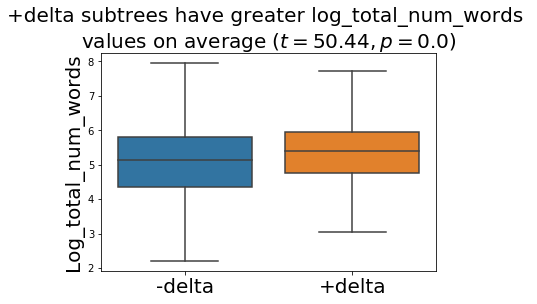

Optimization terminated successfully.
         Current function value: 0.130987
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.008719
Time:                        11:59:12   Log-Likelihood:            -1.4970e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -4.9449      0.030   -164.975      0.000      -5.004      -4.886
lo

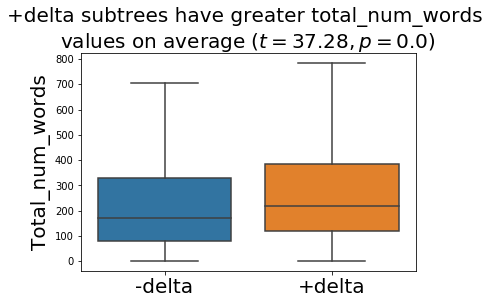

Optimization terminated successfully.
         Current function value: 0.130463
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1108530
Model:                          Logit   Df Residuals:                  1108528
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.004413
Time:                        11:59:45   Log-Likelihood:            -1.4462e+05
converged:                       True   LL-Null:                   -1.4526e+05
Covariance Type:            nonrobust   LLR p-value:                8.769e-281
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.7491      0.009   -420.578      0.000      -3.767      -3.732
total_num_word

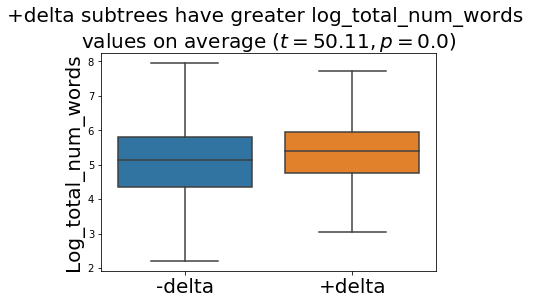

Optimization terminated successfully.
         Current function value: 0.129084
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1075115
Model:                          Logit   Df Residuals:                  1075113
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.009550
Time:                        12:00:18   Log-Likelihood:            -1.3878e+05
converged:                       True   LL-Null:                   -1.4012e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.1760      0.035   -149.666      0.000      -5.244      -5.108
lo

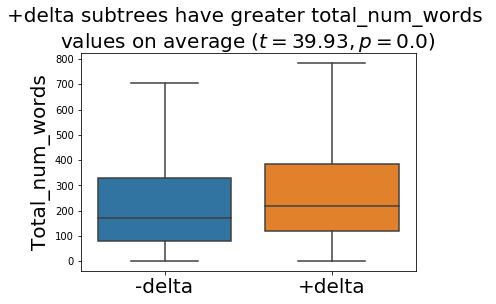

Optimization terminated successfully.
         Current function value: 0.129637
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1075115
Model:                          Logit   Df Residuals:                  1075113
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.005311
Time:                        12:00:44   Log-Likelihood:            -1.3937e+05
converged:                       True   LL-Null:                   -1.4012e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.8033      0.010   -394.747      0.000      -3.822      -3.784
total_num_word

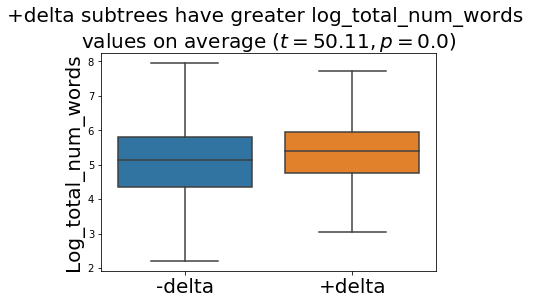

Optimization terminated successfully.
         Current function value: 0.129084
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1075115
Model:                          Logit   Df Residuals:                  1075113
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.009550
Time:                        12:01:10   Log-Likelihood:            -1.3878e+05
converged:                       True   LL-Null:                   -1.4012e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.1760      0.035   -149.666      0.000      -5.244      -5.108
lo

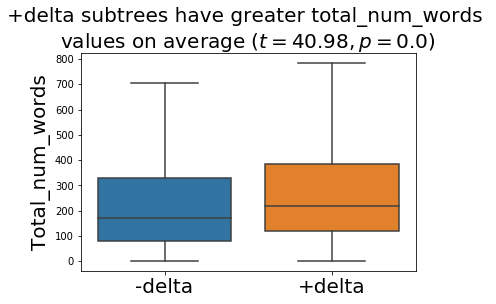

Optimization terminated successfully.
         Current function value: 0.128682
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1042539
Model:                          Logit   Df Residuals:                  1042537
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.005856
Time:                        12:01:49   Log-Likelihood:            -1.3416e+05
converged:                       True   LL-Null:                   -1.3495e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.8449      0.010   -375.453      0.000      -3.865      -3.825
total_num_word

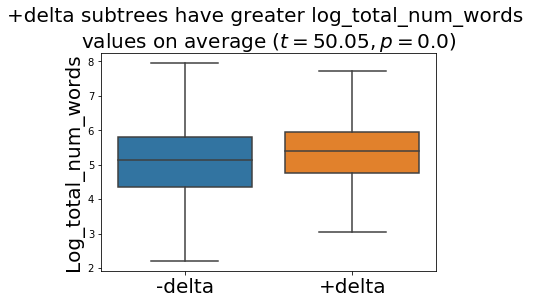

Optimization terminated successfully.
         Current function value: 0.127443
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1011063
Model:                          Logit   Df Residuals:                  1011061
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                 0.01039
Time:                        12:02:26   Log-Likelihood:            -1.2885e+05
converged:                       True   LL-Null:                   -1.3021e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -5.3424      0.038   -141.420      0.000      -5.416      -5.268
lo

In [35]:
do_delta_outcome_corr(reg_df,'total_num_words')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


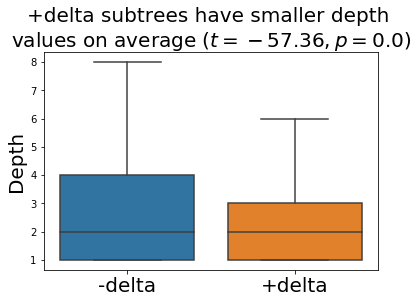

Optimization terminated successfully.
         Current function value: 0.130449
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                 0.01279
Time:                        12:39:56   Log-Likelihood:            -1.4908e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9922      0.010   -306.818      0.000      -3.011      -2.973
depth         -0.2128      0.

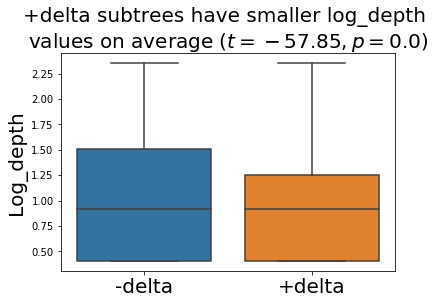

Optimization terminated successfully.
         Current function value: 0.130599
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                 0.01166
Time:                        12:40:25   Log-Likelihood:            -1.4926e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9091      0.011   -264.657      0.000      -2.931      -2.888
log_depth     -0.6405      0.

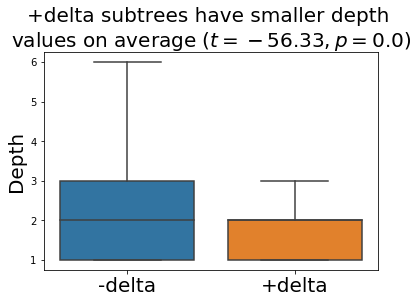

Optimization terminated successfully.
         Current function value: 0.132446
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1105124
Model:                          Logit   Df Residuals:                  1105122
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                 0.01204
Time:                        12:41:00   Log-Likelihood:            -1.4637e+05
converged:                       True   LL-Null:                   -1.4815e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9505      0.010   -286.626      0.000      -2.971      -2.930
depth         -0.2361      0.

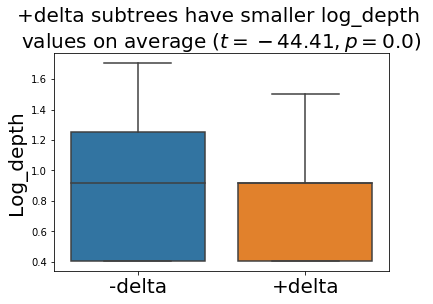

Optimization terminated successfully.
         Current function value: 0.137518
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1032973
Model:                          Logit   Df Residuals:                  1032971
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.007068
Time:                        12:41:31   Log-Likelihood:            -1.4205e+05
converged:                       True   LL-Null:                   -1.4306e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9477      0.012   -247.484      0.000      -2.971      -2.924
log_depth     -0.5794      0.

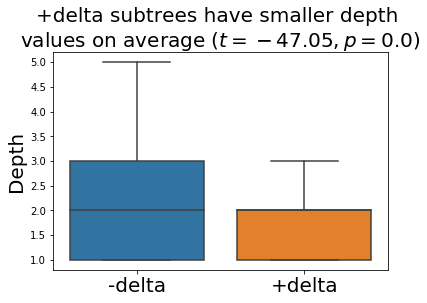

Optimization terminated successfully.
         Current function value: 0.137346
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1032973
Model:                          Logit   Df Residuals:                  1032971
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.008310
Time:                        12:42:02   Log-Likelihood:            -1.4188e+05
converged:                       True   LL-Null:                   -1.4306e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9538      0.011   -263.739      0.000      -2.976      -2.932
depth         -0.2344      0.

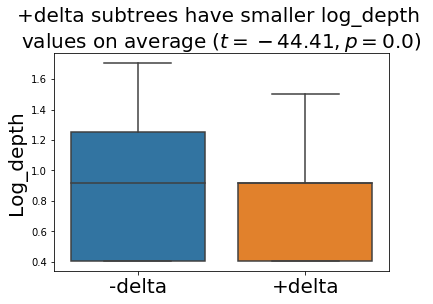

Optimization terminated successfully.
         Current function value: 0.137518
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1032973
Model:                          Logit   Df Residuals:                  1032971
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.007068
Time:                        12:42:33   Log-Likelihood:            -1.4205e+05
converged:                       True   LL-Null:                   -1.4306e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9477      0.012   -247.484      0.000      -2.971      -2.924
log_depth     -0.5794      0.

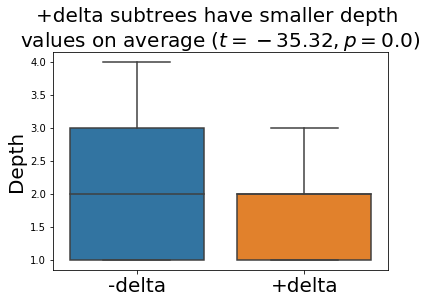

Optimization terminated successfully.
         Current function value: 0.142844
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               954744
Model:                          Logit   Df Residuals:                   954742
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.004756
Time:                        12:43:17   Log-Likelihood:            -1.3638e+05
converged:                       True   LL-Null:                   -1.3703e+05
Covariance Type:            nonrobust   LLR p-value:                1.974e-285
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9917      0.012   -244.159      0.000      -3.016      -2.968
depth         -0.2093      0.

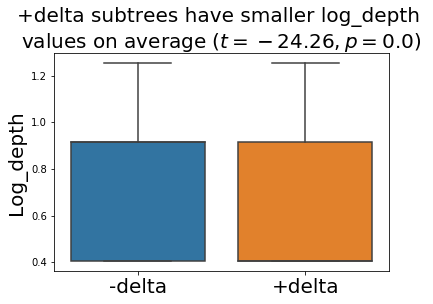

Optimization terminated successfully.
         Current function value: 0.148149
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               839631
Model:                          Logit   Df Residuals:                   839629
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.002393
Time:                        12:43:55   Log-Likelihood:            -1.2439e+05
converged:                       True   LL-Null:                   -1.2469e+05
Covariance Type:            nonrobust   LLR p-value:                8.911e-132
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0334      0.014   -218.654      0.000      -3.061      -3.006
log_depth     -0.4323      0.

In [46]:
do_delta_outcome_corr(reg_df,'depth')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


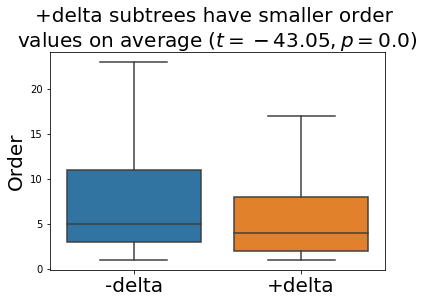

Optimization terminated successfully.
         Current function value: 0.130778
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                 0.01030
Time:                        12:44:34   Log-Likelihood:            -1.4946e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2502      0.007   -445.799      0.000      -3.264      -3.236
order         -0.0307      0.

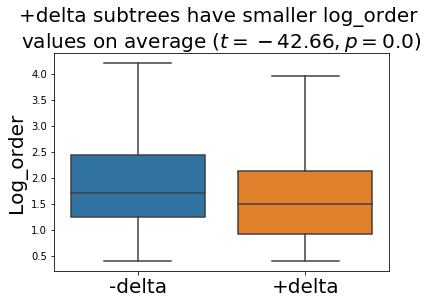

Optimization terminated successfully.
         Current function value: 0.131307
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.006295
Time:                        12:45:02   Log-Likelihood:            -1.5007e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.0604      0.011   -273.072      0.000      -3.082      -3.038
log_order     -0.2550      0.

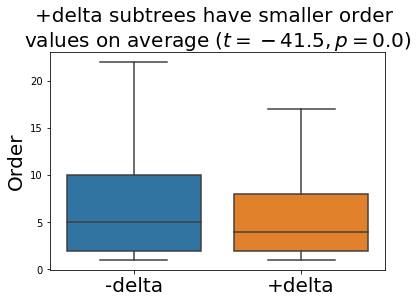

Optimization terminated successfully.
         Current function value: 0.133836
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1108521
Model:                          Logit   Df Residuals:                  1108519
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.007078
Time:                        12:46:24   Log-Likelihood:            -1.4836e+05
converged:                       True   LL-Null:                   -1.4942e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2240      0.008   -416.896      0.000      -3.239      -3.209
order         -0.0351      0.

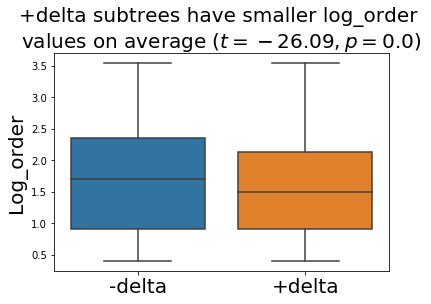

Optimization terminated successfully.
         Current function value: 0.136748
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1075197
Model:                          Logit   Df Residuals:                  1075195
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.002321
Time:                        12:47:01   Log-Likelihood:            -1.4703e+05
converged:                       True   LL-Null:                   -1.4737e+05
Covariance Type:            nonrobust   LLR p-value:                8.669e-151
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1618      0.012   -259.816      0.000      -3.186      -3.138
log_order     -0.1773      0.

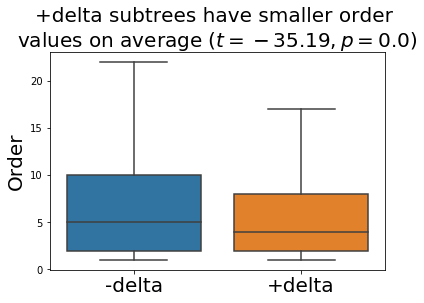

Optimization terminated successfully.
         Current function value: 0.136421
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1075197
Model:                          Logit   Df Residuals:                  1075195
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.004703
Time:                        12:47:34   Log-Likelihood:            -1.4668e+05
converged:                       True   LL-Null:                   -1.4737e+05
Covariance Type:            nonrobust   LLR p-value:                2.193e-303
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2224      0.008   -392.280      0.000      -3.238      -3.206
order         -0.0354      0.

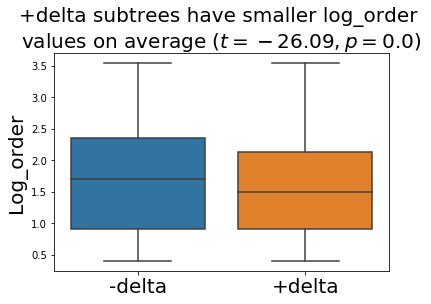

Optimization terminated successfully.
         Current function value: 0.136748
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1075197
Model:                          Logit   Df Residuals:                  1075195
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.002321
Time:                        12:48:07   Log-Likelihood:            -1.4703e+05
converged:                       True   LL-Null:                   -1.4737e+05
Covariance Type:            nonrobust   LLR p-value:                8.669e-151
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.1618      0.012   -259.816      0.000      -3.186      -3.138
log_order     -0.1773      0.

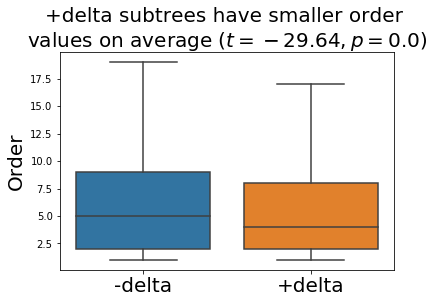

Optimization terminated successfully.
         Current function value: 0.138452
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1044335
Model:                          Logit   Df Residuals:                  1044333
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.003256
Time:                        12:48:56   Log-Likelihood:            -1.4459e+05
converged:                       True   LL-Null:                   -1.4506e+05
Covariance Type:            nonrobust   LLR p-value:                2.024e-207
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2283      0.009   -374.098      0.000      -3.245      -3.211
order         -0.0341      0.

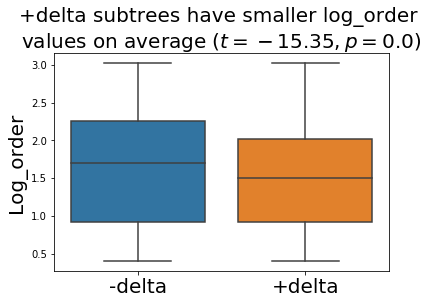

Optimization terminated successfully.
         Current function value: 0.140658
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1012117
Model:                          Logit   Df Residuals:                  1012115
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0008253
Time:                        12:49:45   Log-Likelihood:            -1.4236e+05
converged:                       True   LL-Null:                   -1.4248e+05
Covariance Type:            nonrobust   LLR p-value:                 4.430e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2364      0.013   -250.904      0.000      -3.262      -3.211
log_order     -0.1152      0.

In [47]:
do_delta_outcome_corr(reg_df,'order')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


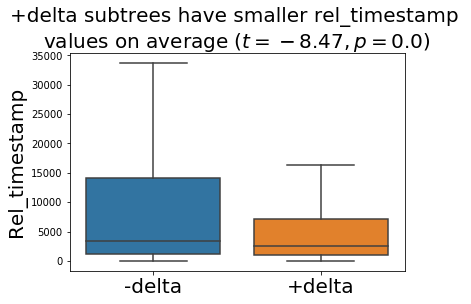

Optimization terminated successfully.
         Current function value: 0.131866
         Iterations 10


In [ ]:
do_delta_outcome_corr(reg_df,'rel_timestamp')

In [13]:
reg_df['num_urls'].describe()

count    1.142856e+06
mean     7.532795e-02
std      4.809454e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.200000e+01
Name: num_urls, dtype: float64

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


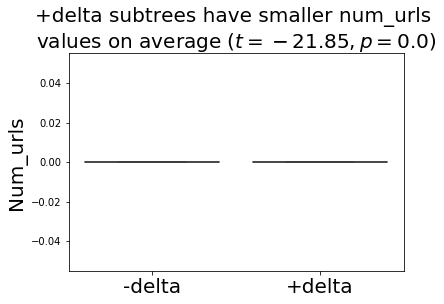

Optimization terminated successfully.
         Current function value: 0.131647
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.003723
Time:                        13:58:03   Log-Likelihood:            -1.5045e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                1.609e-246
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.4681      0.006   -619.758      0.000      -3.479      -3.457
num_urls      -0.8988      0.

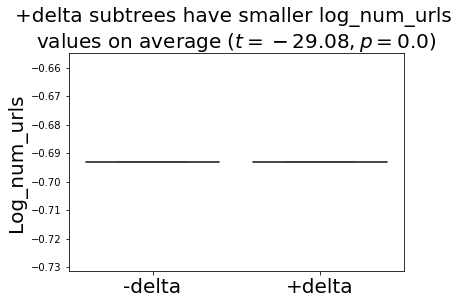

Optimization terminated successfully.
         Current function value: 0.131608
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.004017
Time:                        13:58:18   Log-Likelihood:            -1.5041e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                8.063e-266
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.1676      0.026   -161.770      0.000      -4.218      -4.117
log_num_urls    -1.0125

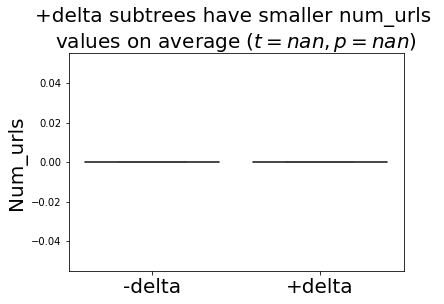

Optimization terminated successfully.
         Current function value: 0.135828
         Iterations 7


LinAlgError: Singular matrix

In [11]:
do_delta_outcome_corr(reg_df,'num_urls')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


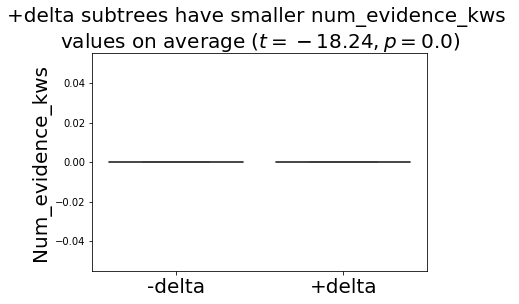

Optimization terminated successfully.
         Current function value: 0.131936
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001533
Time:                        14:05:14   Log-Likelihood:            -1.5078e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                1.019e-102
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.4641      0.006   -598.090      0.000      -3.476      -3.453
num_evidenc

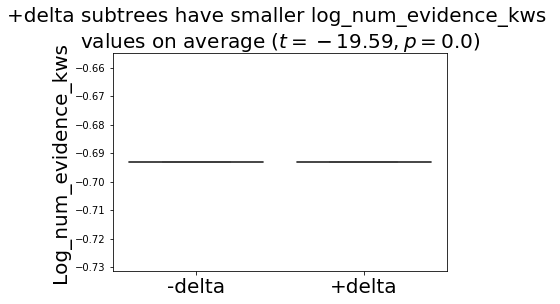

Optimization terminated successfully.
         Current function value: 0.131954
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:                0.001397
Time:                        14:05:29   Log-Likelihood:            -1.5080e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                 9.422e-94
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.6127      0.008   -442.220      0.000      -3.629      -3.597

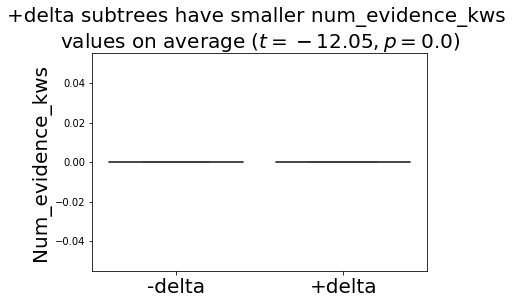

Optimization terminated successfully.
         Current function value: 0.133646
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1106841
Model:                          Logit   Df Residuals:                  1106839
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0005228
Time:                        14:05:52   Log-Likelihood:            -1.4793e+05
converged:                       True   LL-Null:                   -1.4800e+05
Covariance Type:            nonrobust   LLR p-value:                 1.588e-35
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.4614      0.006   -586.145      0.000      -3.473      -3.450
num_evidenc

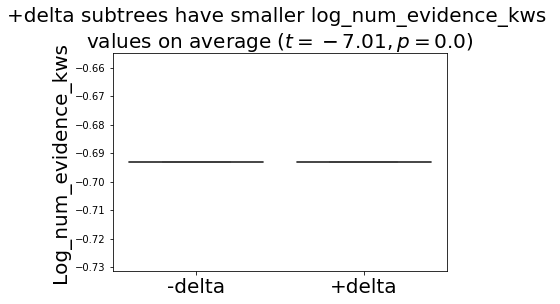

Optimization terminated successfully.
         Current function value: 0.134704
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1071214
Model:                          Logit   Df Residuals:                  1071212
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0001761
Time:                        14:06:15   Log-Likelihood:            -1.4430e+05
converged:                       True   LL-Null:                   -1.4432e+05
Covariance Type:            nonrobust   LLR p-value:                 1.009e-12
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.5490      0.012   -297.531      0.000      -3.572      -3.526

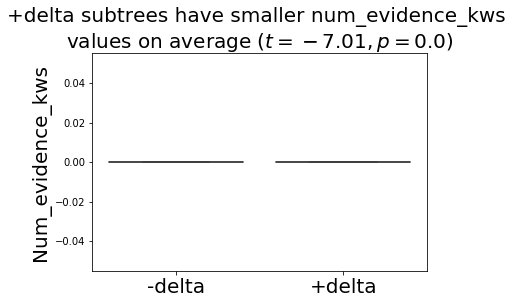

Optimization terminated successfully.
         Current function value: 0.134704
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1071214
Model:                          Logit   Df Residuals:                  1071212
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0001761
Time:                        14:06:37   Log-Likelihood:            -1.4430e+05
converged:                       True   LL-Null:                   -1.4432e+05
Covariance Type:            nonrobust   LLR p-value:                 1.009e-12
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.4628      0.006   -582.229      0.000      -3.474      -3.451
num_evidenc

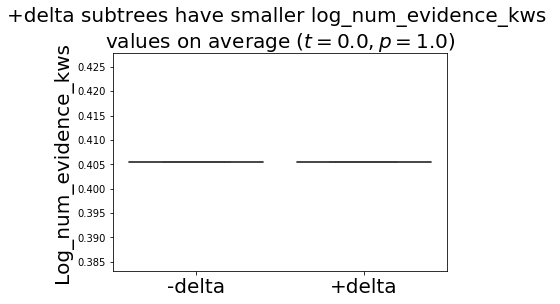

         Current function value: 0.122757
         Iterations: 35


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               111795
Model:                          Logit   Df Residuals:                   111793
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               1.952e-11
Time:                        14:06:41   Log-Likelihood:                -13724.
converged:                      False   LL-Null:                       -13724.
Covariance Type:            nonrobust   LLR p-value:                    0.9994
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.0915        nan        nan        nan         nan         nan
log_num_evidence_kws    -1.2527        nan        nan        nan         nan         nan
Excluding ze

ValueError: min() arg is an empty sequence

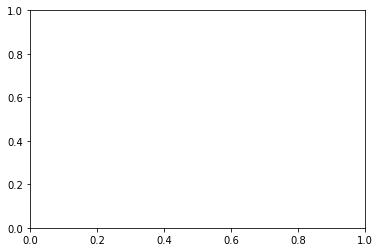

In [12]:
do_delta_outcome_corr(reg_df,'num_evidence_kws')

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


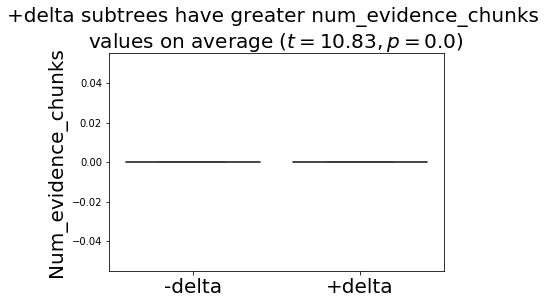

Optimization terminated successfully.
         Current function value: 0.132096
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0003289
Time:                        14:13:54   Log-Likelihood:            -1.5097e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                 2.143e-23
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.5174      0.006   -609.758      0.000      -3.529      -3.506
nu

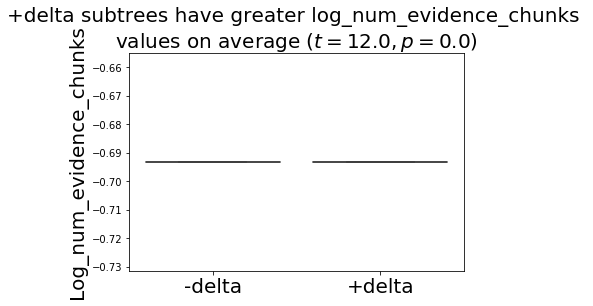

Optimization terminated successfully.
         Current function value: 0.132079
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1142856
Model:                          Logit   Df Residuals:                  1142854
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0004527
Time:                        14:14:09   Log-Likelihood:            -1.5095e+05
converged:                       True   LL-Null:                   -1.5102e+05
Covariance Type:            nonrobust   LLR p-value:                 1.388e-31
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -3.4344      0.008   -440.359      0.000      -3.450   

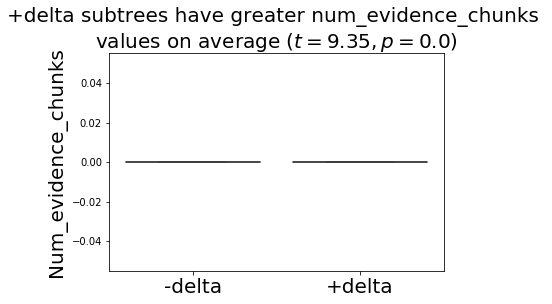

Optimization terminated successfully.
         Current function value: 0.131309
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:              1100591
Model:                          Logit   Df Residuals:                  1100589
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               0.0002896
Time:                        14:14:30   Log-Likelihood:            -1.4452e+05
converged:                       True   LL-Null:                   -1.4456e+05
Covariance Type:            nonrobust   LLR p-value:                 5.657e-20
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -3.5279      0.006   -584.440      0.000      -3.540      -3.516
nu

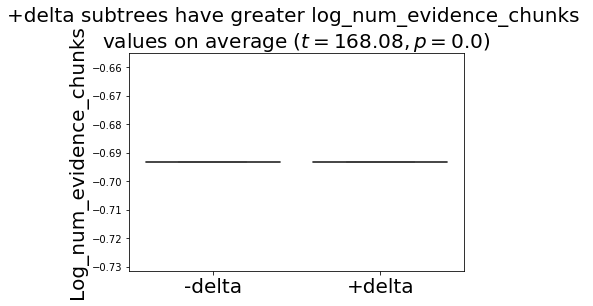

         Current function value: 0.129590
         Iterations: 35


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:               990228
Model:                          Logit   Df Residuals:                   990226
Method:                           MLE   Df Model:                            1
Date:                Wed, 09 Mar 2022   Pseudo R-squ.:               5.718e-11
Time:                        14:14:55   Log-Likelihood:            -1.2832e+05
converged:                      False   LL-Null:                   -1.2832e+05
Covariance Type:            nonrobust   LLR p-value:                    0.9969
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.3877   1.23e+04     -0.000      1.000   -2.41e+04    2.41e+04
log_num_evidence_chunks     1.6450   1.77e+04   9.28e-05      1.000   -3.47e+04    3.47e+04


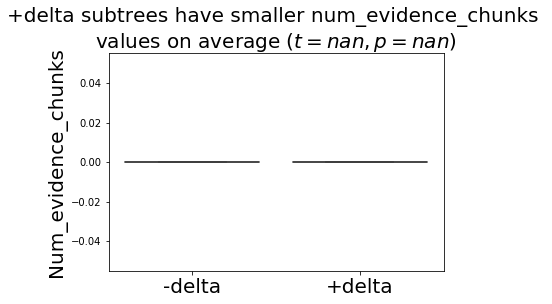

Optimization terminated successfully.
         Current function value: 0.129590
         Iterations 8


LinAlgError: Singular matrix

In [14]:
do_delta_outcome_corr(reg_df,'num_evidence_chunks')

# Understand correlations w/ length

In [18]:
def do_len_corr(df_,ind_var,outlier_thresh=.97,log_smoothing=.5):
    
    df_ = df_.copy()
    og_n = len(df_)
    
    for incl_zeros in [True, False]:
        for incl_outliers in [True, False]:
            for log_transform in [False, True]:
    
                if incl_zeros:
                    print("Including zero values.")
                else:
                    print("Excluding zero values...")
                    df_ = df_.loc[df_[ind_var]!=0].copy()
                    print(f"\tremoved {og_n-len(df_)} rows")

                if incl_outliers:
                    print("Including outliers.")
                else:
                    print("Excluding outliers...")
                    q_hi = df_[ind_var].quantile(outlier_thresh)
                    df_ = df_.loc[df_[ind_var] < q_hi].copy()
                    print(f"\tremoved {og_n-len(df_)} rows")

                if log_transform:
                    print("Using log-transformed vars.")
                    df_[f'log_{ind_var}'] = np.log(df_[ind_var]+log_smoothing)
                    ind_var = f'log_{ind_var}'
                    len_var = 'log_total_num_words'
                else:
                    print("Using raw ind. var (no log-transforming).")
                    ind_var = ind_var.split('log_')[-1]
                    len_var = 'total_num_words'
                    
                pearson_corr, pearson_p = stats.pearsonr(df_[ind_var].values,df_[len_var].values)
                spearman_corr, spearman_p = stats.spearmanr(df_[ind_var].values,df_[len_var].values)
                print(f"\t{ind_var} and {len_var} Pearson correlation:",pearson_corr, pearson_p)
                print(f"\t{ind_var} and {len_var} Spearman correlation:",spearman_corr, spearman_p)
                
for feat in ['senti_pos_arousal_adxs_only','senti_neg_arousal_adxs_only',
             'nrc_val_adxs_only','emo_total_adxs_only','mfd_total_adxs_only',
             'num_urls','num_evidence_kws','num_evidence_chunks',
             'total_num_words','mean_num_words','depth','order','rel_timestamp']:
    do_len_corr(reg_df,feat)

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).
	senti_pos_arousal_adxs_only and total_num_words Pearson correlation: 0.4388076914957547 0.0
	senti_pos_arousal_adxs_only and total_num_words Spearman correlation: 0.5501996805140471 0.0
Including zero values.
Including outliers.
Using log-transformed vars.
	log_senti_pos_arousal_adxs_only and log_total_num_words Pearson correlation: 0.5716929776276787 0.0
	log_senti_pos_arousal_adxs_only and log_total_num_words Spearman correlation: 0.5501996805140471 0.0
Including zero values.
Excluding outliers...
	removed 100726 rows
Using raw ind. var (no log-transforming).
	senti_pos_arousal_adxs_only and total_num_words Pearson correlation: 0.4201655305114941 0.0
	senti_pos_arousal_adxs_only and total_num_words Spearman correlation: 0.5330287575446341 0.0
Including zero values.
Excluding outliers...
	removed 601130 rows
Using log-transformed vars.
	log_senti_pos_arousal_adxs_only and log_total_num_words Pearson 

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/

	removed 918377 rows
Excluding outliers...
	removed 1142856 rows
Using log-transformed vars.
	log_senti_pos_arousal_adxs_only and log_total_num_words Pearson correlation: nan nan
	log_senti_pos_arousal_adxs_only and log_total_num_words Spearman correlation: nan nan


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).
	senti_neg_arousal_adxs_only and total_num_words Pearson correlation: 0.4367319790514962 0.0
	senti_neg_arousal_adxs_only and total_num_words Spearman correlation: 0.5438995002059865 0.0
Including zero values.
Including outliers.
Using log-transformed vars.
	log_senti_neg_arousal_adxs_only and log_total_num_words Pearson correlation: 0.5799847392633404 0.0
	log_senti_neg_arousal_adxs_only and log_total_num_words Spearman correlation: 0.5438995002059865 0.0
Including zero values.
Excluding outliers...
	removed 35702 rows
Using raw ind. var (no log-transforming).
	senti_neg_arousal_adxs_only and total_num_words Pearson correlation: 0.42742928238744743 0.0
	senti_neg_arousal_adxs_only and total_num_words Spearman correlation: 0.5352166294711461 0.0
Including zero values.
Excluding outliers...
	removed 348525 rows
Using log-transformed vars.
	log_senti_neg_arousal_adxs_only and log_total_num_words Pearson 

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).
	nrc_val_adxs_only and total_num_words Pearson correlation: 0.9456192578093782 0.0
	nrc_val_adxs_only and total_num_words Spearman correlation: 0.9288527380818982 0.0
Including zero values.
Including outliers.
Using log-transformed vars.
	log_nrc_val_adxs_only and log_total_num_words Pearson correlation: 0.9162374704937427 0.0
	log_nrc_val_adxs_only and log_total_num_words Spearman correlation: 0.9288527459763902 0.0
Including zero values.
Excluding outliers...
	removed 34286 rows
Using raw ind. var (no log-transforming).
	nrc_val_adxs_only and total_num_words Pearson correlation: 0.9101145033744135 0.0
	nrc_val_adxs_only and total_num_words Spearman correlation: 0.9221434180203688 0.0
Including zero values.
Excluding outliers...
	removed 67548 rows
Using log-transformed vars.
	log_nrc_val_adxs_only and log_total_num_words Pearson correlation: 0.8973554133896383 0.0
	log_nrc_val_adxs_only and log_total

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).
	num_urls and total_num_words Pearson correlation: 0.07951159763834467 0.0
	num_urls and total_num_words Spearman correlation: 0.05821881730989351 0.0
Including zero values.
Including outliers.
Using log-transformed vars.
	log_num_urls and log_total_num_words Pearson correlation: 0.06498318026670612 0.0
	log_num_urls and log_total_num_words Spearman correlation: 0.05821881730989351 0.0
Including zero values.
Excluding outliers...
	removed 55660 rows
Using raw ind. var (no log-transforming).


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/

	num_urls and total_num_words Pearson correlation: nan 1.0
	num_urls and total_num_words Spearman correlation: nan nan
Including zero values.
Excluding outliers...
	removed 1142856 rows
Using log-transformed vars.
	log_num_urls and log_total_num_words Pearson correlation: nan nan
	log_num_urls and log_total_num_words Spearman correlation: nan nan
Excluding zero values...
	removed 1142856 rows
Including outliers.
Using raw ind. var (no log-transforming).
	num_urls and total_num_words Pearson correlation: nan nan
	num_urls and total_num_words Spearman correlation: nan nan
Excluding zero values...
	removed 1142856 rows
Including outliers.
Using log-transformed vars.
	log_num_urls and log_total_num_words Pearson correlation: nan nan
	log_num_urls and log_total_num_words Spearman correlation: nan nan
Excluding zero values...
	removed 1142856 rows
Excluding outliers...
	removed 1142856 rows
Using raw ind. var (no log-transforming).
	num_urls and total_num_words Pearson correlation: nan nan
	

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value en

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).
	num_evidence_kws and total_num_words Pearson correlation: 0.17353626731711372 0.0
	num_evidence_kws and total_num_words Spearman correlation: 0.16521921404955658 0.0
Including zero values.
Including outliers.
Using log-transformed vars.
	log_num_evidence_kws and log_total_num_words Pearson correlation: 0.17799339152303678 0.0
	log_num_evidence_kws and log_total_num_words Spearman correlation: 0.16521921404955658 0.0
Including zero values.
Excluding outliers...
	removed 36015 rows
Using raw ind. var (no log-transforming).
	num_evidence_kws and total_num_words Pearson correlation: 0.11121265112842617 0.0
	num_evidence_kws and total_num_words Spearman correlation: 0.12386355188534559 0.0
Including zero values.
Excluding outliers...
	removed 71642 rows
Using log-transformed vars.
	log_num_evidence_kws and log_total_num_words Pearson correlation: 0.10040875740940643 0.0
	log_num_evidence_kws and log_total_

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

	removed 1031061 rows
Excluding outliers...
	removed 1142856 rows
Using raw ind. var (no log-transforming).
	num_evidence_kws and total_num_words Pearson correlation: nan nan
	num_evidence_kws and total_num_words Spearman correlation: nan nan
Excluding zero values...
	removed 1142856 rows
Excluding outliers...
	removed 1142856 rows
Using log-transformed vars.
	log_num_evidence_kws and log_total_num_words Pearson correlation: nan nan
	log_num_evidence_kws and log_total_num_words Spearman correlation: nan nan


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value en

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).
	num_evidence_chunks and total_num_words Pearson correlation: 0.34238364105966884 0.0
	num_evidence_chunks and total_num_words Spearman correlation: 0.2578513842257397 0.0
Including zero values.
Including outliers.
Using log-transformed vars.
	log_num_evidence_chunks and log_total_num_words Pearson correlation: 0.2680866359714527 0.0
	log_num_evidence_chunks and log_total_num_words Spearman correlation: 0.2578513842257397 0.0
Including zero values.
Excluding outliers...
	removed 42265 rows
Using raw ind. var (no log-transforming).
	num_evidence_chunks and total_num_words Pearson correlation: 0.18168878921138326 0.0
	num_evidence_chunks and total_num_words Spearman correlation: 0.17858431686345158 0.0
Including zero values.
Excluding outliers...
	removed 152628 rows
Using log-transformed vars.


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

	log_num_evidence_chunks and log_total_num_words Pearson correlation: 5.590772857444267e-16 1.0
	log_num_evidence_chunks and log_total_num_words Spearman correlation: nan nan
Excluding zero values...
	removed 152628 rows
Including outliers.
Using raw ind. var (no log-transforming).


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2525: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/u/nlp/anaconda/

	num_evidence_chunks and total_num_words Pearson correlation: nan 1.0
	num_evidence_chunks and total_num_words Spearman correlation: nan nan
Excluding zero values...
	removed 1142856 rows
Including outliers.
Using log-transformed vars.
	log_num_evidence_chunks and log_total_num_words Pearson correlation: nan nan
	log_num_evidence_chunks and log_total_num_words Spearman correlation: nan nan
Excluding zero values...
	removed 1142856 rows
Excluding outliers...
	removed 1142856 rows
Using raw ind. var (no log-transforming).
	num_evidence_chunks and total_num_words Pearson correlation: nan nan
	num_evidence_chunks and total_num_words Spearman correlation: nan nan
Excluding zero values...
	removed 1142856 rows
Excluding outliers...
	removed 1142856 rows
Using log-transformed vars.
	log_num_evidence_chunks and log_total_num_words Pearson correlation: nan nan
	log_num_evidence_chunks and log_total_num_words Spearman correlation: nan nan


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3038: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/scipy/stats/stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value en

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).
	total_num_words and total_num_words Pearson correlation: 1.0 0.0
	total_num_words and total_num_words Spearman correlation: 1.0 0.0
Including zero values.
Including outliers.
Using log-transformed vars.
	log_total_num_words and log_total_num_words Pearson correlation: 1.0 0.0
	log_total_num_words and log_total_num_words Spearman correlation: 1.0 0.0
Including zero values.
Excluding outliers...
	removed 34326 rows
Using raw ind. var (no log-transforming).
	total_num_words and total_num_words Pearson correlation: 1.0 0.0
	total_num_words and total_num_words Spearman correlation: 1.0 0.0
Including zero values.
Excluding outliers...
	removed 67741 rows
Using log-transformed vars.
	log_total_num_words and log_total_num_words Pearson correlation: 1.0 0.0
	log_total_num_words and log_total_num_words Spearman correlation: 1.0 0.0
Excluding zero values...
	removed 67741 rows
Including outliers.
Using raw ind. 

	rel_timestamp and total_num_words Pearson correlation: -0.025276305061110036 7.358313763057748e-161
	rel_timestamp and total_num_words Spearman correlation: -0.1291376571525755 0.0
Including zero values.
Including outliers.
Using log-transformed vars.
	log_rel_timestamp and log_total_num_words Pearson correlation: -0.1456236825606916 0.0
	log_rel_timestamp and log_total_num_words Spearman correlation: -0.1291376571525755 0.0
Including zero values.
Excluding outliers...
	removed 34286 rows
Using raw ind. var (no log-transforming).
	rel_timestamp and total_num_words Pearson correlation: -0.10127466587848624 0.0
	rel_timestamp and total_num_words Spearman correlation: -0.10642464818761109 0.0
Including zero values.
Excluding outliers...
	removed 67544 rows
Using log-transformed vars.
	log_rel_timestamp and log_total_num_words Pearson correlation: -0.09460263112321947 0.0
	log_rel_timestamp and log_total_num_words Spearman correlation: -0.08475302505462283 0.0
Excluding zero values...
	re

# Length, delta simultaneous correlations

Condition on +/-delta and re-do length correlations.

Including zero values.
Including outliers.
Using raw ind. var (no log-transforming).


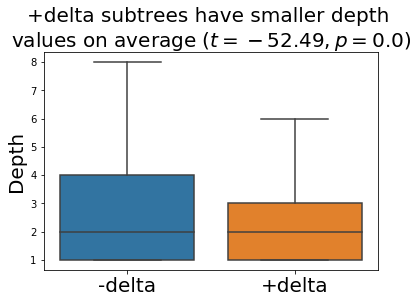

******* Overall correlations ********
	depth and total_num_words Pearson correlation: 0.5184100664256082 0.0
	depth and total_num_words Spearman correlation: 0.588357697877791 0.0
******* correlations (+delta subtrees, N=33818) ********
	depth and total_num_words Pearson correlation: 0.4218207494827924 0.0
	depth and total_num_words Spearman correlation: 0.4109332229500117 0.0
******* correlations (-delta subtrees,  N=1169691) ********
	depth and total_num_words Pearson correlation: 0.524336034809055 0.0
	depth and total_num_words Spearman correlation: 0.596550217841284 0.0
Including zero values.
Excluding outliers...
	removed 37752 rows
Using raw ind. var (no log-transforming).


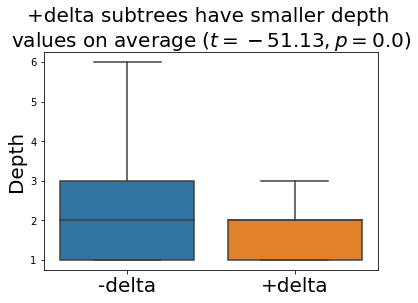

******* Overall correlations ********
	depth and total_num_words Pearson correlation: 0.4749710516070735 0.0
	depth and total_num_words Spearman correlation: 0.5615466313013744 0.0
******* correlations (+delta subtrees, N=33322) ********
	depth and total_num_words Pearson correlation: 0.3694816877442924 0.0
	depth and total_num_words Spearman correlation: 0.39030443115335756 0.0
******* correlations (-delta subtrees,  N=1132435) ********
	depth and total_num_words Pearson correlation: 0.48174338686533674 0.0
	depth and total_num_words Spearman correlation: 0.5698808421856896 0.0
Excluding zero values...
	removed 0 rows
Including outliers.
Using raw ind. var (no log-transforming).


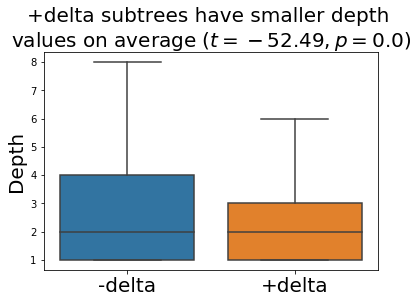

******* Overall correlations ********
	depth and total_num_words Pearson correlation: 0.5184100664256082 0.0
	depth and total_num_words Spearman correlation: 0.588357697877791 0.0
******* correlations (+delta subtrees, N=33818) ********
	depth and total_num_words Pearson correlation: 0.4218207494827924 0.0
	depth and total_num_words Spearman correlation: 0.4109332229500117 0.0
******* correlations (-delta subtrees,  N=1169691) ********
	depth and total_num_words Pearson correlation: 0.524336034809055 0.0
	depth and total_num_words Spearman correlation: 0.596550217841284 0.0
Excluding zero values...
	removed 0 rows
Excluding outliers...
	removed 37752 rows
Using raw ind. var (no log-transforming).


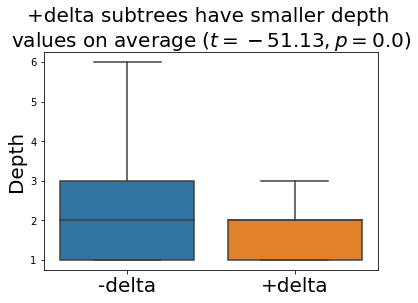

******* Overall correlations ********
	depth and total_num_words Pearson correlation: 0.4749710516070735 0.0
	depth and total_num_words Spearman correlation: 0.5615466313013744 0.0
******* correlations (+delta subtrees, N=33322) ********
	depth and total_num_words Pearson correlation: 0.3694816877442924 0.0
	depth and total_num_words Spearman correlation: 0.39030443115335756 0.0
******* correlations (-delta subtrees,  N=1132435) ********
	depth and total_num_words Pearson correlation: 0.48174338686533674 0.0
	depth and total_num_words Spearman correlation: 0.5698808421856896 0.0


In [4]:
def do_len_delta_corr(df_,ind_var,outlier_thresh=.97,log_smoothing=.5,showfliers=False):
    
    df_ = df_.copy()
    og_n = len(df_)
    
    for incl_zeros in [True, False]:
        for incl_outliers in [True, False]:
            for log_transform in [False]:#[False, True]:
    
                if incl_zeros:
                    print("Including zero values.")
                    subdf_ = df_.copy()
                else:
                    print("Excluding zero values...")
                    subdf_ = df_.loc[df_[ind_var]!=0].copy()
                    print(f"\tremoved {og_n-len(subdf_)} rows")

                if incl_outliers:
                    print("Including outliers.")
                else:
                    print("Excluding outliers...")
                    q_hi = subdf_[ind_var].quantile(outlier_thresh)
                    subdf_ = subdf_.loc[subdf_[ind_var] < q_hi].copy()
                    print(f"\tremoved {og_n-len(subdf_)} rows")

                if log_transform:
                    print("Using log-transformed vars.")
                    subdf_[f'log_{ind_var}'] = np.log(subdf_[ind_var]+log_smoothing)
                    ind_var = f'log_{ind_var}'
                    len_var = 'log_total_num_words'
                else:
                    print("Using raw ind. var (no log-transforming).")
                    ind_var = ind_var.split('log_')[-1]
                    len_var = 'total_num_words'
                 
                posdf_ = subdf_.loc[subdf_['outcome']==1]
                if len(posdf_) > 0:
                    # do t-test
                    t, p_val = stats.ttest_ind(subdf_.loc[subdf_['outcome']==1][ind_var].values,
                                               subdf_.loc[subdf_['outcome']==0][ind_var].values)

                    # do boxplot
                    fig, ax = plt.subplots(figsize=(6,4))
                    sns.boxplot(data=subdf_,x='outcome',y=ind_var,showfliers=showfliers,ax=ax)
                    ax.set_xticklabels(['-delta','+delta'],fontsize=20)
                    ax.set_xlabel("")
                    ax.set_ylabel(ind_var.capitalize(),fontsize=20)
                    comp = 'greater' if t > 0 else 'smaller'
                    ax.set_title(f"+delta subtrees have {comp} {ind_var} \nvalues on average ($t={round(t,2)}, p={round(p_val,3)}$)",fontsize=20)
                    plt.show()

                    # overall correlation
                    pearson_corr, pearson_p = stats.pearsonr(subdf_[ind_var].values,subdf_[len_var].values)
                    spearman_corr, spearman_p = stats.spearmanr(subdf_[ind_var].values,subdf_[len_var].values)
                    print("******* Overall correlations ********")
                    print(f"\t{ind_var} and {len_var} Pearson correlation:",pearson_corr, pearson_p)
                    print(f"\t{ind_var} and {len_var} Spearman correlation:",spearman_corr, spearman_p)

                    # +delta correlation
                    pearson_corr, pearson_p = stats.pearsonr(posdf_[ind_var].values,posdf_[len_var].values)
                    spearman_corr, spearman_p = stats.spearmanr(posdf_[ind_var].values,posdf_[len_var].values)
                    print(f"******* correlations (+delta subtrees, N={len(posdf_)}) ********")
                    print(f"\t{ind_var} and {len_var} Pearson correlation:",pearson_corr, pearson_p)
                    print(f"\t{ind_var} and {len_var} Spearman correlation:",spearman_corr, spearman_p)

                    # -delta correlation
                    negdf_ = subdf_.loc[subdf_['outcome']==0]
                    pearson_corr, pearson_p = stats.pearsonr(negdf_[ind_var].values,negdf_[len_var].values)
                    spearman_corr, spearman_p = stats.spearmanr(negdf_[ind_var].values,negdf_[len_var].values)
                    print(f"******* correlations (-delta subtrees,  N={len(negdf_)}) ********")
                    print(f"\t{ind_var} and {len_var} Pearson correlation:",pearson_corr, pearson_p)
                    print(f"\t{ind_var} and {len_var} Spearman correlation:",spearman_corr, spearman_p)
                ind_var = ind_var.split('log_')[-1] # reset ind_var
                
# for feat in ['senti_pos_arousal_adxs_only','senti_neg_arousal_adxs_only',
#              'nrc_val_adxs_only','emo_total_adxs_only','mfd_total_adxs_only',
#              'num_urls','num_evidence_kws','num_evidence_chunks',
#              'total_num_words','mean_num_words','depth','order','rel_timestamp']:
for feat in ['depth']:
    do_len_delta_corr(reg_df,feat)

# Check for Simpson's paradox

In [151]:
var = 'has_kw'
deltapos = reg_df.loc[(reg_df['outcome']==1) & (reg_df[var]==True)]
deltaneg = reg_df.loc[(reg_df['outcome']==1) & (reg_df[var]==False)]
nodeltapos = reg_df.loc[(reg_df['outcome']==0) & (reg_df[var]==True)]
nodeltaneg = reg_df.loc[(reg_df['outcome']==0) & (reg_df[var]==False)]
strat_sample = pd.concat([deltapos.sample(n=4000), deltaneg.sample(n=4000), 
                          nodeltapos.sample(n=4000), nodeltaneg.sample(n=4000)], axis=0)
display(strat_sample.head())
print(strat_sample['outcome'].value_counts())
print(strat_sample[var].value_counts())

,subtree_outcome_utt_id,conversation_id,timestamp,senti_pos_arousal_all,senti_pos_arousal_adxs_only,senti_neg_arousal_all,senti_neg_arousal_adxs_only,nrc_val_all,nrc_val_adxs_only,nrc_arousal_all,...,log_emo_total_adxs_only,log_nrc_val_adxs_only,log_nrc_arousal_adxs_only,has_evidence_True,has_evidence_kw_True,has_url_True,outcome_-delta,outcome,has_url,has_kw
714005,t1_dvqn2fw,t3_84ilde,1.521080e+09,2,2,4,4,12.290,1.024,10.837,...,-0.705220,0.116894,0.478096,0,1,0,0,1,False,True
318338,t1_dh57k6g,t3_69awey,1.493938e+09,2,2,4,4,71.714,11.917,53.230,...,2.032481,2.486322,2.611466,0,1,0,0,1,False,True
609903,t1_gfkos6n,t3_kb6khu,1.607708e+09,1,1,2,2,24.525,2.434,15.888,...,-2.302585,0.929799,0.388658,0,1,0,0,1,False,True
901039,t1_d4h8di8,t3_4ouagd,1.466439e+09,2,1,3,3,22.488,5.273,18.857,...,0.619501,1.681386,1.280656,0,1,1,0,1,True,True
898680,t1_cwvhqfj,t3_3safrr,1.447176e+09,3,3,3,3,65.909,7.081,43.197,...,1.498953,1.971439,1.427436,0,1,0,0,1,False,True


1    8000
0    8000
Name: outcome, dtype: int64
True     8000
False    8000
Name: has_kw, dtype: int64


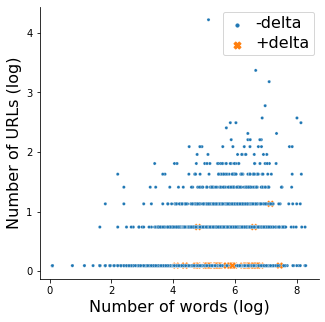

In [192]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='log_total_num_words',y='log_num_urls',
                data=reg_df.loc[(reg_df['total_num_words'] > 0) & 
                                (reg_df['num_urls'] > 0)].sample(4000),
                hue='outcome',style='outcome',size='outcome',sizes={1:50, 0:10},ax=ax)
ax.set_ylabel("Number of URLs (log)",fontsize=16)
ax.set_xlabel("Number of words (log)",fontsize=16)
label2display_text = {'0':'-delta',
                      '1':'+delta'}
handles,labels = ax.get_legend_handles_labels()
label2handle = dict(zip(labels,handles))
ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])
plt.setp(ax.get_legend().get_texts(), fontsize='16')
sns.despine()

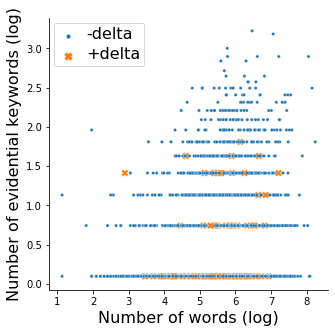

In [193]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='log_total_num_words',y='log_num_evidence_kws',
                data=reg_df.loc[(reg_df['total_num_words'] > 0) & 
                                (reg_df['num_evidence_kws'] > 0)].sample(4000),
                hue='outcome',style='outcome',size='outcome',sizes={1:50, 0:10},ax=ax)
ax.set_ylabel("Number of evidential keywords (log)",fontsize=16)
ax.set_xlabel("Number of words (log)",fontsize=16)
label2display_text = {'0':'-delta',
                      '1':'+delta'}
handles,labels = ax.get_legend_handles_labels()
label2handle = dict(zip(labels,handles))
ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])
plt.setp(ax.get_legend().get_texts(), fontsize='16')
sns.despine()

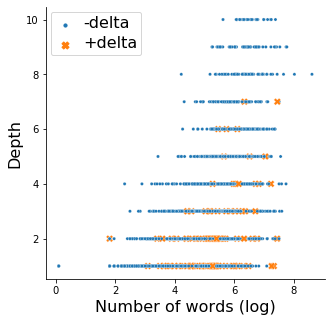

In [194]:
fig, ax = plt.subplots(figsize=(5,5))
sns.scatterplot(x='log_total_num_words',y='depth',
                data=reg_df.loc[(reg_df['total_num_words'] > 0)].sample(4000),
                hue='outcome',style='outcome',size='outcome',sizes={1:50, 0:10},ax=ax)
ax.set_ylabel("Depth",fontsize=16)
ax.set_xlabel("Number of words (log)",fontsize=16)
label2display_text = {'0':'-delta',
                      '1':'+delta'}
handles,labels = ax.get_legend_handles_labels()
label2handle = dict(zip(labels,handles))
ax.legend(handles=handles, labels=[label2display_text[l] for l in labels])
plt.setp(ax.get_legend().get_texts(), fontsize='16')
sns.despine()

In [155]:
# Excluding zeros and outliers, +delta subtrees have fewer evidence keywords.
# Excluding zeros and outliers, +delta subtrees also have greater length.
# Yet both +delta subtrees and -delta subtrees exhibit a (+) correlation b/w length and num. evidence keywords

stats.ttest_ind(strat_sample.loc[(strat_sample['outcome']==1) & (strat_sample['num_evidence_kws']>0) & 
                           (strat_sample['num_evidence_kws']<=3)]['num_evidence_kws'].values,
                strat_sample.loc[(strat_sample['outcome']==0) & (strat_sample['num_evidence_kws']>0) & 
                           (strat_sample['num_evidence_kws']<=3)]['num_evidence_kws'].values)

Ttest_indResult(statistic=-8.009893646315549, pvalue=1.32644567118381e-15)

In [156]:
stats.ttest_ind(strat_sample.loc[(strat_sample['outcome']==1) & (strat_sample['num_evidence_kws']>0) & 
                           (strat_sample['num_evidence_kws']<=3)]['total_num_words'].values,
                strat_sample.loc[(strat_sample['outcome']==0) & (strat_sample['num_evidence_kws']>0) & 
                           (strat_sample['num_evidence_kws']<=3)]['total_num_words'].values)

Ttest_indResult(statistic=4.932642018177594, pvalue=8.291725264072135e-07)

In [157]:
stats.spearmanr(strat_sample.loc[(strat_sample['outcome']==1) & (strat_sample['num_evidence_kws']>0) & 
                           (strat_sample['num_evidence_kws']<=3)]['num_evidence_kws'].values,
                strat_sample.loc[(strat_sample['outcome']==1) & (strat_sample['num_evidence_kws']>0) & 
                           (strat_sample['num_evidence_kws']<=3)]['total_num_words'].values)

SpearmanrResult(correlation=0.1280906545836198, pvalue=3.936617665910707e-15)

In [158]:
stats.spearmanr(strat_sample.loc[(strat_sample['outcome']==0) & (strat_sample['num_evidence_kws']>0) & 
                           (strat_sample['num_evidence_kws']<=3)]['num_evidence_kws'].values,
                strat_sample.loc[(strat_sample['outcome']==0) & (strat_sample['num_evidence_kws']>0) & 
                           (strat_sample['num_evidence_kws']<=3)]['total_num_words'].values)

SpearmanrResult(correlation=0.11529839627910686, pvalue=4.792279486722396e-12)

# Understand words being counted toward lexicon-based features

In [19]:
list(reg_df.columns)

['subtree_outcome_utt_id',
 'conversation_id',
 'timestamp',
 'senti_pos_arousal_all',
 'senti_pos_arousal_adxs_only',
 'senti_neg_arousal_all',
 'senti_neg_arousal_adxs_only',
 'nrc_val_all',
 'nrc_val_adxs_only',
 'nrc_arousal_all',
 'nrc_arousal_adxs_only',
 'emo_fear_all',
 'emo_fear_adxs_only',
 'emo_anger_all',
 'emo_anger_adxs_only',
 'emo_sadness_all',
 'emo_sadness_adxs_only',
 'emo_disgust_all',
 'emo_disgust_adxs_only',
 'emo_anticipation_all',
 'emo_anticipation_adxs_only',
 'emo_joy_all',
 'emo_joy_adxs_only',
 'emo_trust_all',
 'emo_trust_adxs_only',
 'emo_surprise_all',
 'emo_surprise_adxs_only',
 'mfd_authority_virtue_all',
 'mfd_authority_virtue_adxs_only',
 'mfd_authority_vice_all',
 'mfd_authority_vice_adxs_only',
 'mfd_purity_virtue_all',
 'mfd_purity_virtue_adxs_only',
 'mfd_purity_vice_all',
 'mfd_purity_vice_adxs_only',
 'mfd_fairness_virtue_all',
 'mfd_fairness_virtue_adxs_only',
 'mfd_fairness_vice_all',
 'mfd_fairness_vice_adxs_only',
 'mfd_harm_virtue_all',
 

In [22]:
reg_df.sort_values('nrc_val_adxs_only',ascending=False)[['subtree_outcome_utt_id','nrc_val_adxs_only','counted_nrc_adxs',
                                                         'total_num_words']]

,subtree_outcome_utt_id,nrc_val_adxs_only,counted_nrc_adxs,total_num_words
210983,t1_cp5nxb8,0.000,{},8
838770,t1_cwvvvvz,0.000,{},36
562464,t1_h5mqi2j,0.000,{},26
288037,t1_h3c8hhv,0.000,{},23
895273,t1_e8kkrum,0.000,{},13
...,...,...,...,...
745662,t1_f6wzpeb,355.187,"{'literal': 1, 'together': 1, 'modern': 1, 'nasty': 1, 'rich': 3, 'ample': 1, 'basic': 1, 'open': 1, 'subjective': 4, 'racist': 1, 'fat': 1, 'related': 1, 'main': 2, 'minimum': 3, 'first': 2, 'top': 3, 'profitable': 2, 'fresh': 1, 'social': 4, 'global': 3, 'universal': 2, 'ago': 2, 'electoral': 1, 'deep': 1, 'literally': 1, 'brutish': 1, 'public': 4, 'true': 3, 'entire': 2, 'past': 1, 'big': 4, 'good': 6, 'fine': 2, 'bad': 6, 'short': 1, 'healthy': 1, 'little': 2, 'strange': 2, 'other': 7, 'illiterate': 1, 'infectious': 1, 'easily': 2, 'sedentary': 1, 'poor': 4, 'free': 5, 'completely': 3, 'old': 3, 'easy': 1, 'hard': 3, 'homeless': 1, 'socialist': 4, 'low': 2, 'innovative': 4, 'small': 2, 'pretty': 2, 'alone': 2, 'less': 4, 'fair': 1, 'elderly': 1, 'advanced': 1, 'actual': 3, 'unhealthy': 1, 'philosophical': 1, 'high': 4, 'cheap': 5, 'safe': 1, 'real': 2, 'abroad': 1, 'historical': 1, 'early': 1, 'long': 6, 'wealthy': 2, 'expensive': 3, 'fancy': 2, 'extra': 2, 'new': 3, 'directly': 2, 'hypothetical': 1, 'exclusive': 1, 'purple': 1, 'homophobic': 1, 'logical': 1, 'contemporary': 1, 'average': 2, 'key': 2, 'back': 1, 'outrageous': 1, 'slightly': 2, 'baseline': 1, 'second': 2, 'generally': 1, 'absolute': 1, 'gay': 1, 'broad': 2, 'relative': 1, 'regular': 1, 'liberal': 1, 'happy': 2, 'whole': 1, 'various': 2, ...}",7129
368053,t1_cghpaxq,373.319,"{'inflatable': 1, 'diverse': 1, 'nerve': 1, 'loud': 2, 'celestial': 1, 'southern': 1, 'eucalyptus': 3, 'modern': 3, 'comprehensive': 1, 'pungent': 1, 'commonly': 1, 'tropical': 1, 'mature': 1, 'brown': 1, 'annual': 1, 'usual': 1, 'official': 1, 'northwest': 1, 'extremely': 2, 'main': 4, 'warm': 1, 'exotic': 1, 'partly': 1, 'clear': 1, 'sticky': 1, 'large': 5, 'global': 1, 'unimaginable': 1, 'right': 5, 'big': 4, 'public': 2, 'true': 3, 'economic': 2, 'good': 5, 'adjacent': 1, 'copious': 1, 'important': 3, 'extreme': 2, 'late': 3, 'other': 6, 'practical': 2, 'beneficial': 1, 'distinct': 1, 'national': 1, 'poor': 1, 'enormous': 2, 'phenomenal': 1, 'fully': 2, 'free': 1, 'previous': 4, 'local': 4, 'multiple': 1, 'old': 2, 'dry': 1, 'natural': 2, 'available': 1, 'lucrative': 1, 'inland': 1, 'low': 2, 'midway': 1, 'unopened': 1, 'small': 2, 'amateur': 1, 'northern': 2, 'less': 5, 'obtainable': 1, 'senior': 2, 'desirable': 2, 'joyful': 1, 'evergreen': 1, 'total': 1, 'serious': 1, 'native': 2, 'continental': 1, 'deliberate': 2, 'south': 1, 'certain': 5, 'expensive': 1, 'loathsome': 1, 'fresh': 2, 'skinny': 1, 'great': 2, 'deep': 3, 'crowded': 1, 'mass': 1, 'core': 1, 'down': 2, 'comfortable': 2, 'necessarily': 1, 'special': 3, 'easy': 2, 'savvy': 1, 'radical': 1, 'salutary': 1, 'early': 1, 'sweet': 1, 'various': 2, 'extra': 3, 'fun': 1, 'strong': 2, ...}",6901
841293,t1_dzw87ii,391.116,"{'invariably': 1, 'clever': 1, 'tiny': 2, 'physical': 2, 'excellent': 1, 'feminist': 2, 'vague': 1, 'honest': 1, 'racist': 5, 'aware': 1, 'immigrant': 2, 'legal': 5, 'responsible': 1, 'great': 3, 'large': 5, 'different': 7, 'reverse': 3, 'essentially': 1, 'plain': 1, 'strongly': 1, 'past': 2, 'bad': 6, 'good': 7, 'inaccurate': 1, 'little': 4, 'other': 7, 'domestic': 5, 'interested': 2, 'dear': 1, 'white': 9, 'slightly': 2, 'black': 4, 'free': 6, 'generally': 4, 'common': 3, 'sure': 5, 'dangerous': 3, 'illegal': 3, 'affirmative': 1, 'likely': 6, 'difficult': 4, 'particular': 4, 'conservative': 8, 'serious': 4, 'high': 7, 'sexual': 7, 'safe': 1, 'liberal': 4, 'happy': 4, 'rural': 2, 'peaceful': 2, 'punitive': 1, 'female': 3, 'specific': 5, 'right': 6, 'wide': 1, 'wrong': 1, 'moderate': 2, 'recent': 3, 'weak': 2, 'mainstream': 7, 'male': 5, 'prominent': 5, 'critical': 1, 'less': 6, 'urban': 1, 'broad': 2, 'systematic': 2, 'primary': 1, 'stupid': 2, 

In [20]:
reg_df['counted_nrc_adxs']

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Log odds

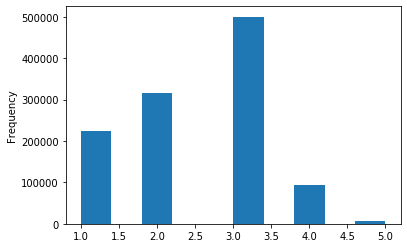

In [24]:
reg_df['senti_pos_arousal_adxs_only'].plot.hist()

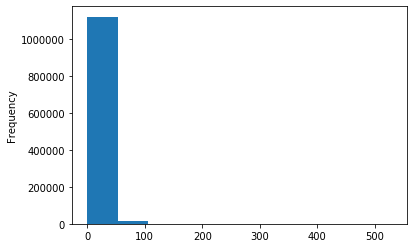

In [25]:
reg_df['nrc_val_adxs_only'].plot.hist()

In [ ]:
* high 'senti_pos_arousal_adxs_only' vs. low 'senti_pos_arousal_adxs_only'
* high 'senti_neg_arousal_adxs_only' vs. low 'senti_neg_arousal_adxs_only'
* high 'nrc_val_adxs_only' vs. low 'nrc_val_adxs_only'
* high 'emo_total_adxs_only' vs. low 'emo_total_adxs_only'
* high 'med_total_adxs_only' vs. low 'mfd_total_adxs_only'
* high 'senti_pos_arousal_adxs_only' vs. high 'senti_neg_arousal_adxs_only'

In [ ]:
from convokit import FightingWords

if not os.path.exists('pairwise_feature_log_odds')
    os.mkdir('pairwise_feature_log_odds')

fw = FightingWords(ngram_range=(1,3))
fw.fit(corp_to_analyze['full_cmv'], 
       class1_func=lambda utt: meets_datapoint_criteria(utt) and \
                               (utt.meta['has_url']==True) and (utt.meta['has_evidence_kw']==False), 
       class2_func=lambda utt: meets_datapoint_criteria(utt) and \
                               (utt.meta['has_url']==False) and (utt.meta['has_evidence_kw']==True),)
fw_df = fw.summarize(corp_to_analyze['full_cmv'], plot=True, 
                  class1_name='has URL (but no keywords)', 
                  class2_name='has keyword (but no URLs)')
fw_df.to_pickle('pairwise_feature_log_odds/')
display(fw_df.head(10))
display(fw_df.tail(10))

# Do actual regressions

For now, only do `all`-scheme, no `nrc_arousal`, no structural features other than length-feats, and regress len out from all features (other than length-feats).

In [196]:
model = 'adxs_only'
bin_ev_feats = ['has_url_True','has_evidence_True','has_evidence_kw_True']
count_ev_feats = ['num_urls','num_evidence_chunks','num_evidence_kws']

Do the following regressions:
* against all 3 evidence-related features (binarized)
    * no log transforming
        * z-score dummy vars `bin_ev3_no-log_z-score-dummies`
        * don't z-score dummy vars `bin_ev3_no-log_no-z-score-dummies`
    * log transform count features
        * z-score dummy vars `bin_ev3_log_z-score-dummies`
        * don't z-score dummy vars `bin_ev3_log_no-z-score-dummies`
* against each ev.-feature, one at a time (binarized)
    * no log transforming
        * z-score dummy vars `bin_<ev-model/ev-kw/ev-url>_no-log_z-score-dummies`
        * don't z-score dummy vars `bin_<ev-model/ev-kw/ev-url>_no-log_no-z-score-dummies`
    * log transform count features
        * z-score dummy vars `bin_<ev-model/ev-kw/ev-url>_log_z-score-dummies`
        * don't z-score dummy vars `bin_<ev-model/ev-kw/ev-url>_log_no-z-score-dummies`
* against all 3 evidence-related features (count)
    * no log transforming
        * z-score dummy vars `count_ev3_no-log_z-score-dummies`
        * don't z-score dummy vars `count_ev3_no-log_no-z-score-dummies`
    * log transform count features
        * z-score dummy vars `count_ev3_log_z-score-dummies`
        * don't z-score dummy vars `count_ev3_log_no-z-score-dummies`
* against each ev.-feature, one at a time (count)
    * no log transforming
        * z-score dummy vars `count_<ev-model/ev-kw/ev-url>_no-log_z-score-dummies`
        * don't z-score dummy vars `count_<ev-model/ev-kw/ev-url>_no-log_no-z-score-dummies`
    * log transform count features
        * z-score dummy vars `count_<ev-model/ev-kw/ev-url>_log_z-score-dummies`
        * don't z-score dummy vars `count_<ev-model/ev-kw/ev-url>_log_no-z-score-dummies`

Conclusions:
* individually, model-predicted evidence (binary and count-versions of the predictor; + or -log-transform) is insignificant; keyword- and url-based predictors, however, *are* significant (though coefficients are negative)
* z-scoring dummy variables doesn't make a difference 

In [197]:
def do_reg(reg_df, feats, bin_ev=None, all3=None, ev_feat=None, log_count=None, zscore_dummies=None, 
           total_len_only=True):
    if bin_ev:
        if all3:
            print("Using all 3 binary ev. predictors.")
            ev_feats = bin_ev_feats
        else:
            print("Using 1 single binary ev. predictor:", ev_feat)
            ev_feats = [ev_feat]
    else:
        if all3:
            if log_count:
                print("Using all 3 count ev. predictors (+log transform).")
                ev_feats = [f'log_{f}' for f in count_ev_feats]
            else:
                print("Using all 3 count ev. predictors (-log transform).")
                ev_feats = count_ev_feats
        else:
            if log_count:
                print("Using 1 single count ev. predictor (+log transform).")
                ev_feats = [f'log_{ev_feat}']
            else:
                print("Using 1 single count ev. predictor (-log transform).")
                ev_feats = [ev_feat]
                
    if total_len_only:
        len_feats = ['mean_num_words']
    else:
        len_feats = ['total_num_words','mean_num_words']

    if log_count:
        reg_feats = feats + [f'log_{f}' for f in len_feats]
        [f'senti_pos_arousal_{model}',f'senti_neg_arousal_{model}',
                     f'log_nrc_val_{model}', f'log_emo_total_{model}'] + \
                    ev_feats + \
                    [f'log_{f}' for f in len_feats]
    else:
        reg_feats = feats + [f'log_{f}' for f in len_feats]
        [f'senti_pos_arousal_{model}',f'senti_neg_arousal_{model}',
                     f'nrc_val_{model}', f'emo_total_{model}'] + \
                    ev_feats + \
                    len_feats
    print('Using the following features in overall regression:',reg_feats)

    if zscore_dummies:
        print('\nGetting z-scores (incl. dummy variables)...')
        for reg_feat in tqdm(reg_feats):
            print('\t'+reg_feat)
            reg_df[reg_feat] = stats.zscore(reg_df[reg_feat].values)
    else:
        print('\nGetting z-scores (excl. dummy variables)...')
        for reg_feat in tqdm(reg_feats):
            if 'has_' not in reg_feat:
                print('\t'+reg_feat)
                reg_df[reg_feat] = stats.zscore(reg_df[reg_feat].values)

    print('\nGetting residuals of z-scored variables (excl. len variables)...')
    for reg_feat in tqdm(reg_feats):
        if ('num_words' not in reg_feat):
            print('\t'+reg_feat)
            if log_count:
                reg_df[reg_feat] = sm_api.ols(formula='{}~{}'.format(reg_feat,'log_total_num_words'),
                                              data=reg_df).fit().resid
            else:
                reg_df[reg_feat] = sm_api.ols(formula='{}~{}'.format(reg_feat,'total_num_words'),
                                              data=reg_df).fit().resid
    print()

    collinear_feats = get_VIF(reg_feats, reg_df, threshold=5)

    fit_ = sm.Logit(reg_df['outcome_+delta'], reg_df[reg_feats]).fit()
    print(fit_.summary())
    
    return fit_, reg_df

def plot_coeffs(fit_, title, SIG_THRESH = 0.05):
    
    res_df = pd.concat([fit_.params,fit_.pvalues,fit_.bse],axis=1)
    res_df.columns = ['coeff','pval','stderr']
    display(res_df)

    data_to_plot = res_df.loc[res_df['pval']<SIG_THRESH]
    data_to_plot = data_to_plot.sort_values('coeff',ascending=False,inplace=False)

    fig,ax = plt.subplots(figsize=(20,8))
    x_pos = np.arange(len(data_to_plot['coeff']))
    ax.bar(x_pos, data_to_plot['coeff'], yerr=data_to_plot['stderr'], 
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel("Coefficient",fontsize=24)
    ax.yaxis.grid(True)
    ax.set_xlabel("",fontsize=24)
    ax.xaxis.set_ticks(np.arange(x_pos[0], x_pos[-1]+1, 1))
    ax.set_xticklabels(data_to_plot.index,rotation=40,fontsize=20,ha='right',rotation_mode='anchor')
    plt.yticks(fontsize=20)
    plt.title(title,fontsize=28)
    plt.tight_layout()

In [108]:
import statsmodels.formula.api as smf

log_reg = smf.logit("outcome ~ total_num_words", data=reg_df).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.131749
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143293
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                0.002979
Time:                        13:28:38   Log-Likelihood:            -1.5063e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:            nonrobust   LLR p-value:                9.673e-198
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.6374      0.007   -508.556      0.000      -3.651      -3.623
total_num_words     0.0005   1.49e-05     32.726      0.000       0.000       0.001
===================================================================================
"""

In [109]:
fit_ = sm.Logit(reg_df[['outcome']], reg_df[['total_num_words']]).fit()
fit_.summary()

Optimization terminated successfully.
         Current function value: 0.290361
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143294
Method:                           MLE   Df Model:                            0
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -1.197
Time:                        13:29:02   Log-Likelihood:            -3.3197e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
total_num_words    -0.0154   3.12e-05   -495.054      0.000      -0.015      -0.015
===================================================================================
"""

In [165]:
fit_ = sm.Logit.from_formula('outcome ~ mean_num_words', data=reg_df).fit()
fit_.summary()

Optimization terminated successfully.
         Current function value: 0.128887
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143293
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Mar 2022   Pseudo R-squ.:                 0.02464
Time:                        10:28:52   Log-Likelihood:            -1.4736e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -3.8922      0.007   -526.914      0.000      -3.907      -3.878
mean_num_words     0.0030    3.1e-05     97.877      0.000       0.003       0.003
==================================================================================
"""

In [125]:
fit_ = sm.Logit(reg_df[['outcome']], reg_df[['mean_num_words']].assign(intercept=1)).fit()
fit_.summary()

Optimization terminated successfully.
         Current function value: 0.128887
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143293
Method:                           MLE   Df Model:                            1
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                 0.02464
Time:                        13:44:47   Log-Likelihood:            -1.4736e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
mean_num_words     0.0030    3.1e-05     97.877      0.000       0.003       0.003
intercept         -3.8922      0.007   -526.914      0.000      -3.907      -3.878
==================================================================================
"""

In [166]:
fit_ = sm.Logit(reg_df[['outcome']], reg_df[['num_evidence_kws']].assign(intercept=1)).fit()
fit_.summary()

Optimization terminated successfully.
         Current function value: 0.130154
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143293
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Mar 2022   Pseudo R-squ.:                 0.01505
Time:                        10:29:23   Log-Likelihood:            -1.4880e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
num_evidence_kws    -1.0221      0.023    -45.129      0.000      -1.066      -0.978
intercept           -3.3850      0.006   -597.963      0.000      -3.396      -3.374
====================================================================================
"""

In [167]:
fit_ = sm.Logit(reg_df[['outcome']], reg_df[['num_urls']].assign(intercept=1)).fit()
fit_.summary()

Optimization terminated successfully.
         Current function value: 0.130891
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143293
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Mar 2022   Pseudo R-squ.:                0.009473
Time:                        10:29:44   Log-Likelihood:            -1.4965e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
num_urls      -1.0856      0.030    -36.047      0.000      -1.145      -1.027
intercept     -3.4303      0.006   -611.335      0.000      -3.441      -3.419
==============================================================================
"""

In [168]:
fit_ = sm.Logit(reg_df[['outcome']], reg_df[['num_evidence_chunks']].assign(intercept=1)).fit()
fit_.summary()

Optimization terminated successfully.
         Current function value: 0.132099
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143293
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Mar 2022   Pseudo R-squ.:               0.0003283
Time:                        10:30:30   Log-Likelihood:            -1.5103e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:            nonrobust   LLR p-value:                 2.277e-23
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
num_evidence_chunks     0.0706      0.007     10.591      0.000       0.058       0.084
intercept              -3.5173      0.006   -609.881      0.000      -3.529      -3.506
=======================================================================================
"""

Using 1 single count ev. predictor (-log transform).
Using the following features in overall regression: ['num_evidence_kws']

Optimization terminated successfully.
         Current function value: 0.600752
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143294
Method:                           MLE   Df Model:                            0
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -3.546
Time:                        12:16:00   Log-Likelihood:            -6.8684e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

,coeff,pval,stderr
num_evidence_kws,-4.145967,0.0,0.025397


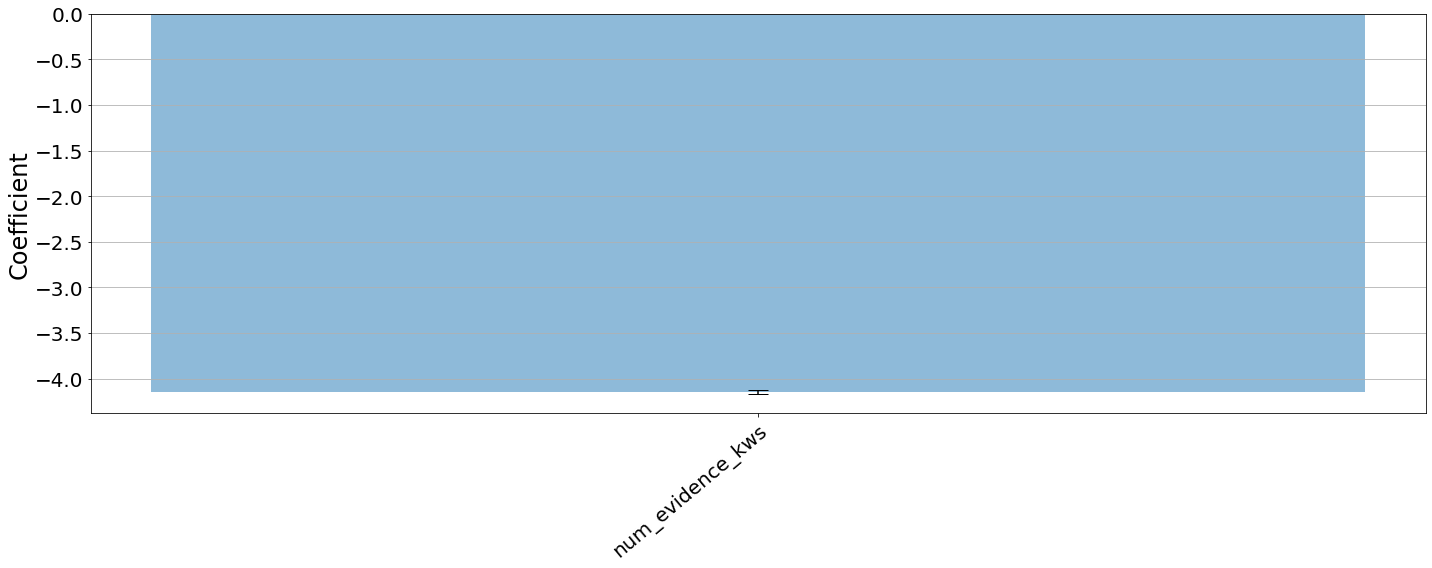

In [74]:
fit_,_ = do_reg(reg_df.copy(), ['num_evidence_kws'], bin_ev=False, all3=False, ev_feat='num_urls', log_count=False, zscore_dummies=True)
plot_coeffs(fit_, "")

In [36]:
# do_reg(bin_ev=True, all3=True, ev_feat=-1, log_count=False, zscore_dummies=False) 
# # z-scoring dummy var doesn't seem to make a difference

In [100]:
do_reg(reg_df.copy(), bin_ev=True, all3=True, ev_feat=-1, log_count=True, zscore_dummies=True)

Using all 3 binary ev. predictors.
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'log_nrc_val_adxs_only', 'log_emo_total_adxs_only', 'has_url_True', 'has_evidence_True', 'has_evidence_kw_True', 'log_total_num_words', 'log_mean_num_words']

Getting z-scores (incl. dummy variables)...


 22%|██▏       | 2/9 [00:00<00:00, 11.83it/s]

	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only
	log_nrc_val_adxs_only
	log_emo_total_adxs_only


100%|██████████| 9/9 [00:00<00:00, 27.66it/s]


	has_url_True
	has_evidence_True
	has_evidence_kw_True
	log_total_num_words
	log_mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/9 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 11%|█         | 1/9 [00:00<00:02,  2.84it/s]

	senti_neg_arousal_adxs_only


 22%|██▏       | 2/9 [00:00<00:02,  3.12it/s]

	log_nrc_val_adxs_only


 33%|███▎      | 3/9 [00:00<00:01,  3.20it/s]

	log_emo_total_adxs_only


 44%|████▍     | 4/9 [00:01<00:01,  3.27it/s]

	has_url_True


 56%|█████▌    | 5/9 [00:01<00:01,  3.31it/s]

	has_evidence_True


 67%|██████▋   | 6/9 [00:01<00:00,  3.34it/s]

	has_evidence_kw_True


100%|██████████| 9/9 [00:02<00:00,  4.22it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
8  1.02  log_mean_num_words
2  1.06  senti_neg_arousal_adxs_only
1  1.09  senti_pos_arousal_adxs_only
6  1.15  has_evidence_True
7  1.15  has_evidence_kw_True
5  1.27  has_url_True
4  1.6   log_emo_total_adxs_only
3  1.66  log_nrc_val_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.691933
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1203509
Model:                          Logit   Df Residuals:                  1203500
Method:                           MLE   Df Model:                            8
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.403
Time:                        09:07:00   Log-Likelihood:            -8.3275e+05
converge

In [35]:
# do_reg(bin_ev=True, all3=True, ev_feat=-1, log_count=True, zscore_dummies=False)
# # again, z-scoring dummy var or not doesn't make a difference

Using 1 single binary ev. predictor: has_evidence_True
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'nrc_val_adxs_only', 'emo_total_adxs_only', 'has_evidence_True', 'mean_num_words']

Getting z-scores (incl. dummy variables)...


100%|██████████| 6/6 [00:00<00:00, 40.12it/s]


	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only
	nrc_val_adxs_only
	emo_total_adxs_only
	has_evidence_True
	mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:01,  3.26it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  3.39it/s]

	nrc_val_adxs_only


 50%|█████     | 3/6 [00:00<00:00,  3.41it/s]

	emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:00,  3.42it/s]

	has_evidence_True


100%|██████████| 6/6 [00:01<00:00,  4.05it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1.01  has_evidence_True
6  1.01  mean_num_words
1  1.07  senti_pos_arousal_adxs_only
2  1.08  senti_neg_arousal_adxs_only
3  1.19  nrc_val_adxs_only
4  1.21  emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692539
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143289
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.241
Time:                        10:13:12   Log-Likelihood:            -7.9178e+05
converged:                       True   LL-Null:                   -1.51

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.011560,7.650021e-08,0.002151
senti_neg_arousal_adxs_only,-0.003716,8.514517e-02,0.002159
nrc_val_adxs_only,0.015304,1.492139e-02,0.006287
emo_total_adxs_only,-0.005573,1.309524e-01,0.003690
has_evidence_True,0.002456,2.080382e-01,0.001951
mean_num_words,0.068391,4.730337e-281,0.001909


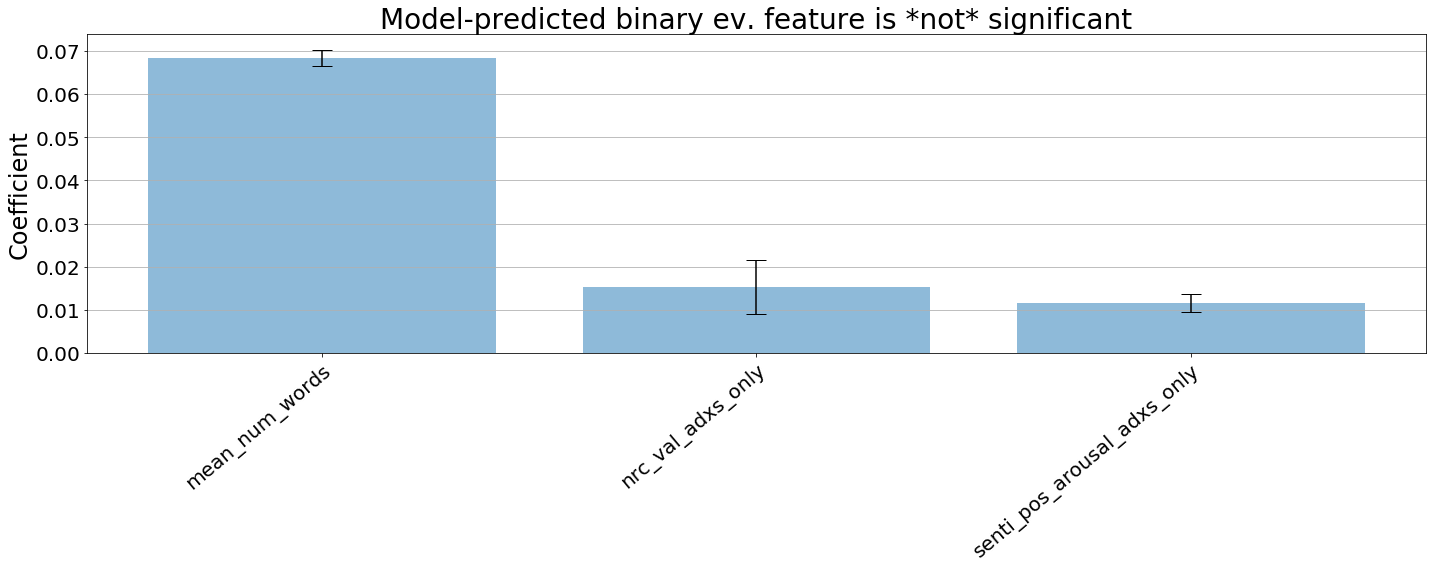

In [170]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=True, all3=False, ev_feat='has_evidence_True', 
                log_count=False, zscore_dummies=True)
plot_coeffs(fit_,'Model-predicted binary ev. feature is *not* significant')
# without log-transforming, `has_evidence_True` (model pred) not significant on its own

In [34]:
# do_reg(bin_ev=True, all3=False, ev_feat='has_evidence_True', log_count=False, zscore_dummies=False)
# # not z-scoring dummy doesn't make a diff

Using 1 single binary ev. predictor: has_evidence_kw_True
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'nrc_val_adxs_only', 'emo_total_adxs_only', 'has_evidence_kw_True', 'mean_num_words']

Getting z-scores (incl. dummy variables)...


100%|██████████| 6/6 [00:00<00:00, 54.57it/s]


	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only
	nrc_val_adxs_only
	emo_total_adxs_only
	has_evidence_kw_True
	mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:01,  3.71it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  3.56it/s]

	nrc_val_adxs_only


 50%|█████     | 3/6 [00:00<00:00,  3.51it/s]

	emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:00,  3.41it/s]

	has_evidence_kw_True


100%|██████████| 6/6 [00:01<00:00,  4.14it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1.02  has_evidence_kw_True
6  1.03  mean_num_words
1  1.07  senti_pos_arousal_adxs_only
2  1.08  senti_neg_arousal_adxs_only
3  1.18  nrc_val_adxs_only
4  1.21  emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692196
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143289
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.238
Time:                        10:13:58   Log-Likelihood:            -7.9138e+05
converged:                       True   LL-Null:                   -1

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.011686,5.602081e-08,0.002152
senti_neg_arousal_adxs_only,-0.003915,6.984088e-02,0.002159
nrc_val_adxs_only,0.023998,1.332779e-04,0.006282
emo_total_adxs_only,-0.008166,2.693418e-02,0.003691
has_evidence_kw_True,-0.053746,1.077938e-172,0.001919
mean_num_words,0.075756,0.000000e+00,0.001931


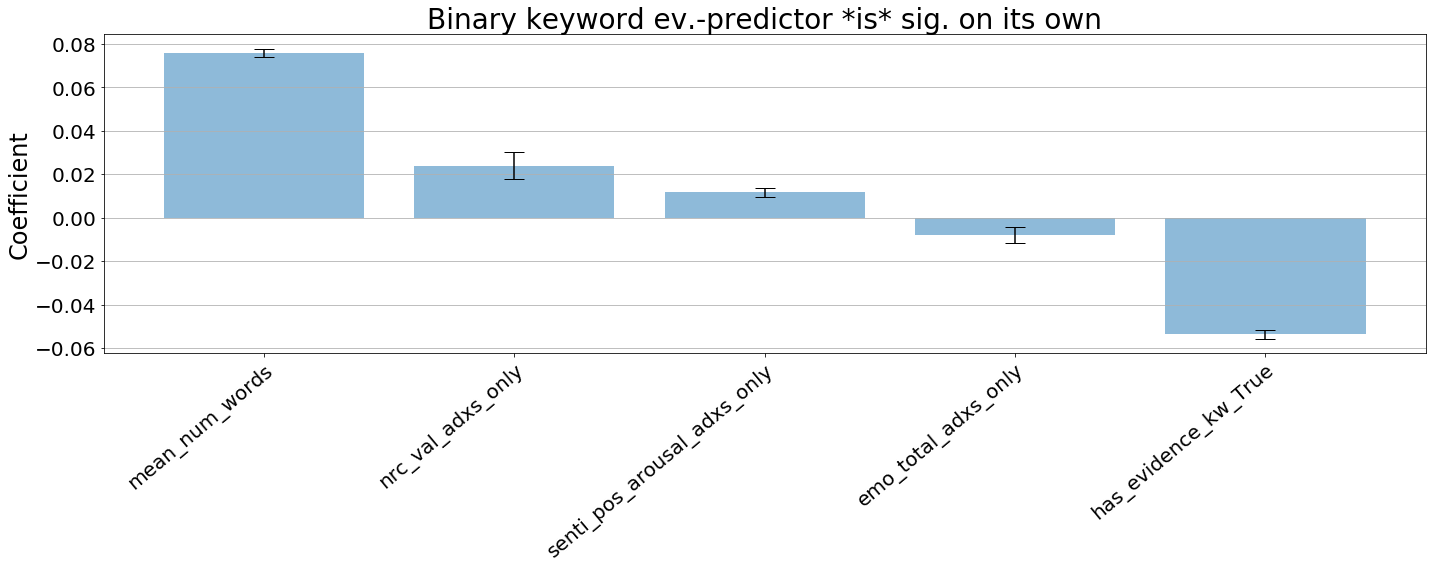

In [171]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=True, all3=False, ev_feat='has_evidence_kw_True', 
                log_count=False, zscore_dummies=True)
# `has_evidence_kw` *is* significant on its own (and neg.)
plot_coeffs(fit_,'Binary keyword ev.-predictor *is* sig. on its own')

Using 1 single binary ev. predictor: has_url_True
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'nrc_val_adxs_only', 'emo_total_adxs_only', 'has_url_True', 'total_num_words']

Getting z-scores (incl. dummy variables)...


 17%|█▋        | 1/6 [00:00<00:00,  6.87it/s]

	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only
	nrc_val_adxs_only
	emo_total_adxs_only
	has_url_True


100%|██████████| 6/6 [00:00<00:00, 23.29it/s]


	total_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:02,  2.12it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:01<00:02,  1.97it/s]

	nrc_val_adxs_only


 50%|█████     | 3/6 [00:01<00:01,  1.99it/s]

	emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:01,  2.00it/s]

	has_url_True


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1.01  has_url_True
1  1.07  senti_pos_arousal_adxs_only
2  1.07  senti_neg_arousal_adxs_only
3  1.18  nrc_val_adxs_only
4  1.21  emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692938
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143289
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.244
Time:                        10:08:20   Log-Likelihood:            -7.9223e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type:      

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.019197,4.347961e-19,0.002150
senti_neg_arousal_adxs_only,0.001768,4.118028e-01,0.002155
nrc_val_adxs_only,0.026249,2.652134e-05,0.006248
emo_total_adxs_only,-0.009407,1.062539e-02,0.003682
has_url_True,-0.030631,1.345334e-59,0.001881
total_num_words,0.020840,9.014493e-29,0.001873


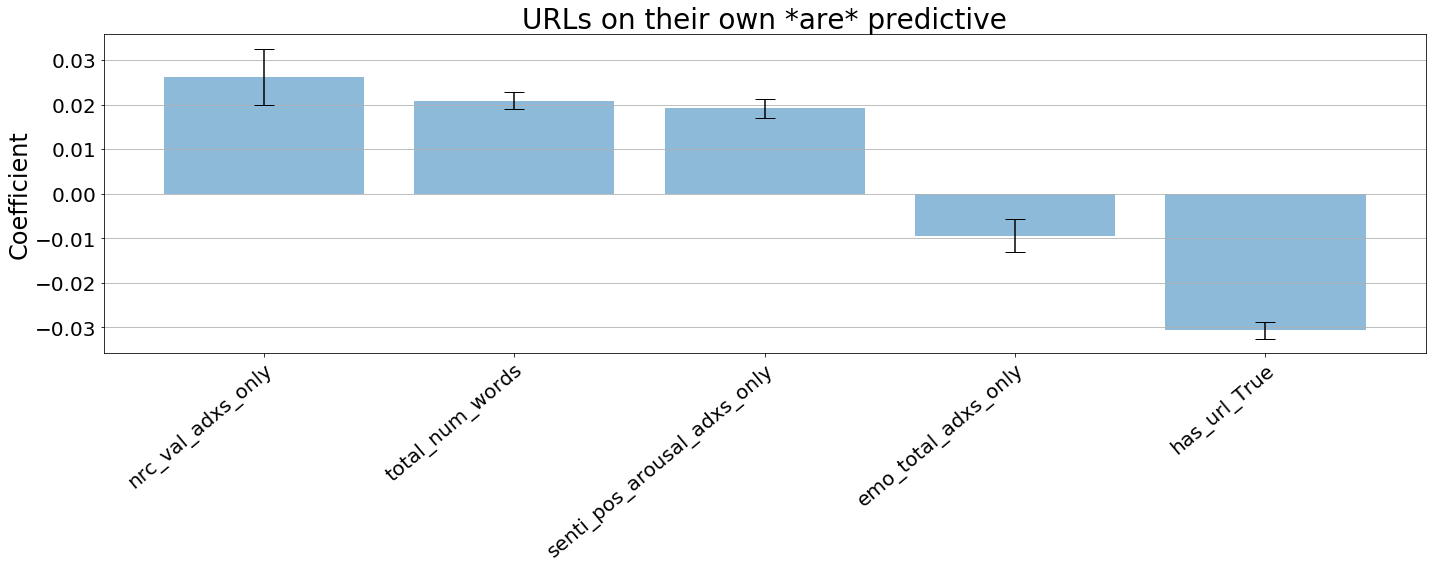

In [161]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=True, all3=False, ev_feat='has_url_True', 
                log_count=False, zscore_dummies=True)
# `has_url` *also* significant on its own (and neg.)
plot_coeffs(fit_,'URLs on their own *are* predictive')

Using 1 single binary ev. predictor: has_evidence_True
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'log_nrc_val_adxs_only', 'log_emo_total_adxs_only', 'has_evidence_True', 'log_mean_num_words']

Getting z-scores (incl. dummy variables)...


100%|██████████| 6/6 [00:00<00:00, 49.88it/s]


	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only
	log_nrc_val_adxs_only
	log_emo_total_adxs_only
	has_evidence_True
	log_mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  3.58it/s]

	log_nrc_val_adxs_only


 50%|█████     | 3/6 [00:00<00:00,  3.49it/s]

	log_emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:00,  3.47it/s]

	has_evidence_True


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1     has_evidence_True
6  1     log_mean_num_words
2  1.06  senti_neg_arousal_adxs_only
1  1.08  senti_pos_arousal_adxs_only
3  1.24  log_nrc_val_adxs_only
4  1.31  log_emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692605
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143289
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.241
Time:                        10:14:47   Log-Likelihood:            -7.9185e+05
converged:                       True   LL-Null:            

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.005849,1.242893e-02,0.002340
senti_neg_arousal_adxs_only,-0.010034,1.651467e-05,0.002329
log_nrc_val_adxs_only,0.008402,7.263308e-02,0.004680
log_emo_total_adxs_only,0.003805,2.595282e-01,0.003374
has_evidence_True,0.001848,3.395865e-01,0.001935
log_mean_num_words,0.064732,1.119104e-260,0.001877


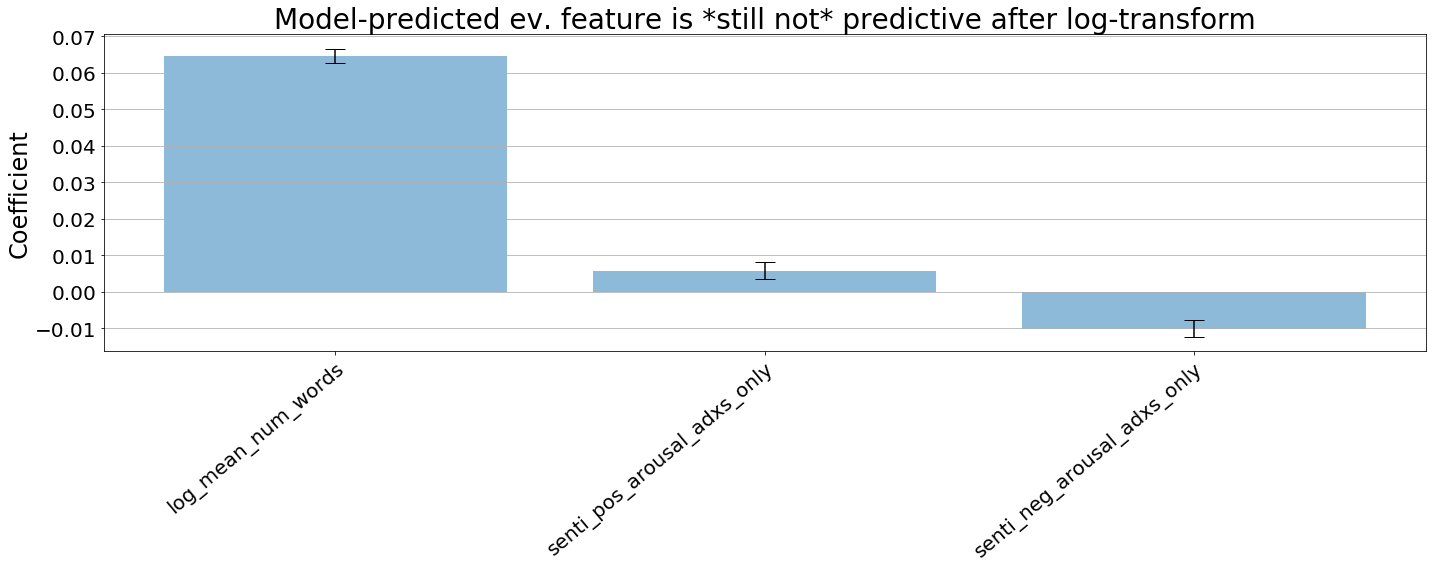

In [172]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=True, all3=False, ev_feat='has_evidence_True', 
              log_count=True, zscore_dummies=True)
# after log transforming, `has_evidence_True` (model pred.) *is* (slightly) sig. (and pos.)
plot_coeffs(fit_,'Model-predicted ev. feature is *still not* predictive after log-transform')

In [33]:
# do_reg(bin_ev=True, all3=False, ev_feat='has_evidence_True', log_count=True, zscore_dummies=False)
# # z-scoring or not again doesn't make a diff.

In [31]:
do_reg(bin_ev=True, all3=False, ev_feat='has_evidence_kw_True', log_count=True, zscore_dummies=True)
# `has_evidence_kw` also sig. on its own (but neg. coeff)

Using 1 single binary ev. predictor: has_evidence_kw_True
Using the following features in overall regression: ['senti_pos_arousal_all', 'senti_neg_arousal_all', 'log_nrc_val_all', 'log_emo_total_all', 'has_evidence_kw_True', 'log_total_num_words', 'log_mean_num_words']

Getting z-scores (incl. dummy variables)...


100%|██████████| 7/7 [00:00<00:00, 48.67it/s]


	senti_pos_arousal_all
	senti_neg_arousal_all
	log_nrc_val_all
	log_emo_total_all
	has_evidence_kw_True
	log_total_num_words
	log_mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/7 [00:00<?, ?it/s]

	senti_pos_arousal_all


 14%|█▍        | 1/7 [00:00<00:01,  3.11it/s]

	senti_neg_arousal_all


 29%|██▊       | 2/7 [00:00<00:01,  3.33it/s]

	log_nrc_val_all


 43%|████▎     | 3/7 [00:00<00:01,  3.50it/s]

	log_emo_total_all


 57%|█████▋    | 4/7 [00:01<00:00,  3.55it/s]

	has_evidence_kw_True


100%|██████████| 7/7 [00:01<00:00,  4.93it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------
0  1     Intercept
5  1.01  has_evidence_kw_True
6  1.01  log_mean_num_words
1  1.06  senti_pos_arousal_all
2  1.2   senti_neg_arousal_all
3  3.07  log_nrc_val_all
4  3.27  log_emo_total_all
-  ----  ---------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692136
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1203509
Model:                          Logit   Df Residuals:                  1203502
Method:                           MLE   Df Model:                            6
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.404
Time:                        08:04:59   Log-Likelihood:            -8.3299e+05
converged:                       True   LL-Null:                   -1.5414e+05
Covariance Typ

In [32]:
do_reg(bin_ev=True, all3=False, ev_feat='has_url_True', log_count=True, zscore_dummies=True)
# `has_url` also sig. on its own (but neg.)

Using 1 single binary ev. predictor: has_url_True
Using the following features in overall regression: ['senti_pos_arousal_all', 'senti_neg_arousal_all', 'log_nrc_val_all', 'log_emo_total_all', 'has_url_True', 'log_total_num_words', 'log_mean_num_words']

Getting z-scores (incl. dummy variables)...


100%|██████████| 7/7 [00:00<00:00, 49.74it/s]


	senti_pos_arousal_all
	senti_neg_arousal_all
	log_nrc_val_all
	log_emo_total_all
	has_url_True
	log_total_num_words
	log_mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/7 [00:00<?, ?it/s]

	senti_pos_arousal_all


 14%|█▍        | 1/7 [00:00<00:01,  3.18it/s]

	senti_neg_arousal_all


 29%|██▊       | 2/7 [00:00<00:01,  3.29it/s]

	log_nrc_val_all


 43%|████▎     | 3/7 [00:00<00:01,  3.50it/s]

	log_emo_total_all


 57%|█████▋    | 4/7 [00:01<00:00,  3.58it/s]

	has_url_True


100%|██████████| 7/7 [00:01<00:00,  4.96it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------
0  1     Intercept
6  1.01  log_mean_num_words
1  1.07  senti_pos_arousal_all
2  1.2   senti_neg_arousal_all
5  1.36  has_url_True
4  3.27  log_emo_total_all
3  3.38  log_nrc_val_all
-  ----  ---------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692341
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1203509
Model:                          Logit   Df Residuals:                  1203502
Method:                           MLE   Df Model:                            6
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.406
Time:                        08:05:50   Log-Likelihood:            -8.3324e+05
converged:                       True   LL-Null:                   -1.5414e+05
Covariance Type:      

In [37]:
do_reg(bin_ev=False, all3=True, ev_feat=-1, log_count=False, zscore_dummies=True)
# back to all 3, but count features--same canceling each other out issue

Using all 3 count ev. predictors (-log transform).
Using the following features in overall regression: ['senti_pos_arousal_all', 'senti_neg_arousal_all', 'nrc_val_all', 'emo_total_all', 'num_urls', 'num_evidence_chunks', 'num_evidence_kws', 'total_num_words', 'mean_num_words']

Getting z-scores (incl. dummy variables)...


 56%|█████▌    | 5/9 [00:00<00:00, 32.10it/s]

	senti_pos_arousal_all
	senti_neg_arousal_all
	nrc_val_all
	emo_total_all
	num_urls
	num_evidence_chunks


100%|██████████| 9/9 [00:00<00:00, 29.11it/s]


	num_evidence_kws
	total_num_words
	mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/9 [00:00<?, ?it/s]

	senti_pos_arousal_all


 11%|█         | 1/9 [00:00<00:02,  2.83it/s]

	senti_neg_arousal_all


 22%|██▏       | 2/9 [00:00<00:02,  3.09it/s]

	nrc_val_all


 33%|███▎      | 3/9 [00:00<00:01,  3.20it/s]

	emo_total_all


 44%|████▍     | 4/9 [00:01<00:01,  3.27it/s]

	num_urls


 56%|█████▌    | 5/9 [00:01<00:01,  3.28it/s]

	num_evidence_chunks


 67%|██████▋   | 6/9 [00:01<00:00,  3.32it/s]

	num_evidence_kws


100%|██████████| 9/9 [00:02<00:00,  4.18it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------
0  1     Intercept
1  1.03  senti_pos_arousal_all
8  1.04  mean_num_words
3  1.09  nrc_val_all
2  1.1   senti_neg_arousal_all
4  1.1   emo_total_all
5  1.12  num_urls
6  1.14  num_evidence_chunks
7  1.18  num_evidence_kws
-  ----  ---------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692059
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1203509
Model:                          Logit   Df Residuals:                  1203500
Method:                           MLE   Df Model:                            8
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.404
Time:                        08:09:14   Log-Likelihood:            -8.3290e+05
converged:                       True   LL-Null:              

In [39]:
# do_reg(bin_ev=False, all3=True, ev_feat=-1, log_count=False, zscore_dummies=False)
# # z-scoring doesn't make a diff.

Using all 3 count ev. predictors (+log transform).
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'log_nrc_val_adxs_only', 'log_emo_total_adxs_only', 'log_num_urls', 'log_num_evidence_chunks', 'log_num_evidence_kws', 'log_mean_num_words']

Getting z-scores (incl. dummy variables)...


100%|██████████| 8/8 [00:00<00:00, 47.36it/s]


	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only
	log_nrc_val_adxs_only
	log_emo_total_adxs_only
	log_num_urls
	log_num_evidence_chunks
	log_num_evidence_kws
	log_mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/8 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 12%|█▎        | 1/8 [00:00<00:02,  3.14it/s]

	senti_neg_arousal_adxs_only


 25%|██▌       | 2/8 [00:00<00:01,  3.28it/s]

	log_nrc_val_adxs_only


 38%|███▊      | 3/8 [00:00<00:01,  3.37it/s]

	log_emo_total_adxs_only


 50%|█████     | 4/8 [00:01<00:01,  3.42it/s]

	log_num_urls


 62%|██████▎   | 5/8 [00:01<00:00,  3.43it/s]

	log_num_evidence_chunks


 75%|███████▌  | 6/8 [00:01<00:00,  3.44it/s]

	log_num_evidence_kws


100%|██████████| 8/8 [00:02<00:00,  3.89it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
8  1.02  log_mean_num_words
5  1.05  log_num_urls
2  1.06  senti_neg_arousal_adxs_only
1  1.09  senti_pos_arousal_adxs_only
6  1.17  log_num_evidence_chunks
7  1.18  log_num_evidence_kws
3  1.24  log_nrc_val_adxs_only
4  1.33  log_emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692123
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143287
Method:                           MLE   Df Model:                            7
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.238
Time:                        10:15:19   Log-Likelihood:            -7.9130e+05
co

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.008611,2.580897e-04,0.002357
senti_neg_arousal_adxs_only,-0.009386,5.954717e-05,0.002338
log_nrc_val_adxs_only,0.009360,4.570265e-02,0.004684
log_emo_total_adxs_only,-0.000632,8.522975e-01,0.003394
log_num_urls,-0.027632,9.296120e-47,0.001924
log_num_evidence_chunks,0.027579,2.416203e-39,0.002102
log_num_evidence_kws,-0.059038,1.812870e-179,0.002067
log_mean_num_words,0.072506,0.000000e+00,0.001894


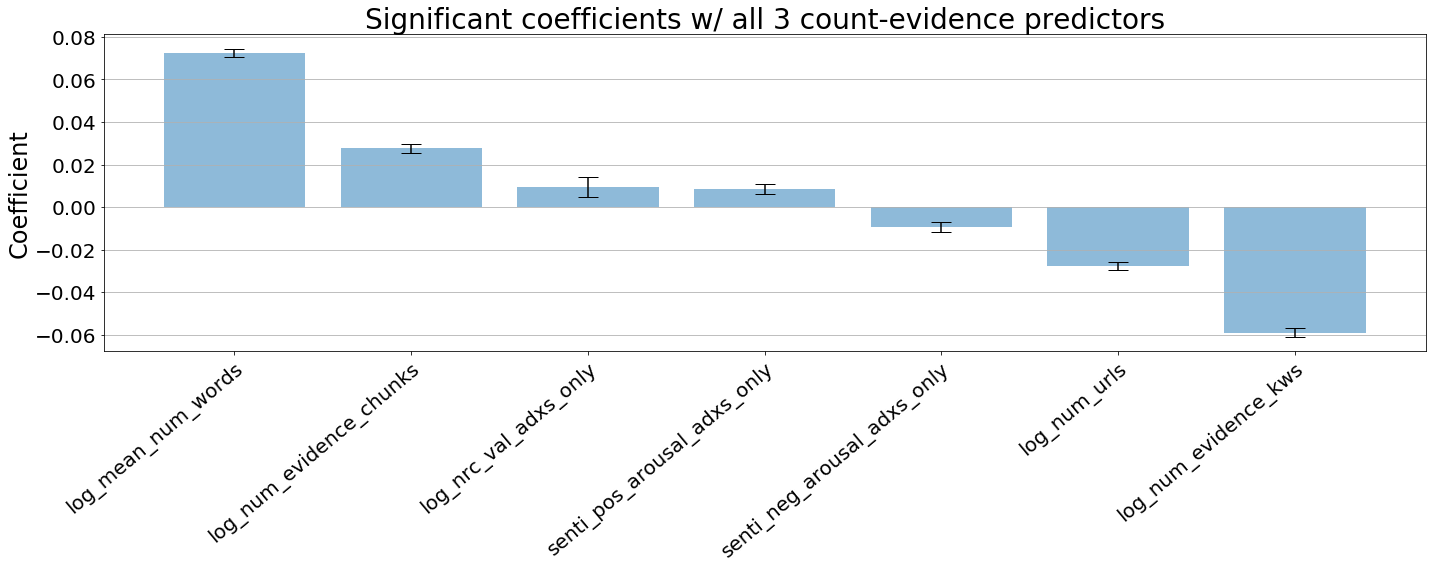

In [173]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=False, all3=True, ev_feat=-1, log_count=True, zscore_dummies=True)
# log-transforming makes a bit of diff. in some values but canceling issue persists
plot_coeffs(fit_, 'Significant coefficients w/ all 3 count-evidence predictors')

Using 1 single count ev. predictor (-log transform).
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'nrc_val_adxs_only', 'emo_total_adxs_only', 'num_evidence_chunks', 'total_num_words']

Getting z-scores (incl. dummy variables)...


100%|██████████| 6/6 [00:00<00:00, 47.25it/s]


	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only
	nrc_val_adxs_only
	emo_total_adxs_only
	num_evidence_chunks
	total_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:01,  3.87it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  3.62it/s]

	nrc_val_adxs_only


 50%|█████     | 3/6 [00:00<00:00,  3.46it/s]

	emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:00,  3.46it/s]

	num_evidence_chunks


100%|██████████| 6/6 [00:01<00:00,  4.20it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1.01  num_evidence_chunks
1  1.06  senti_pos_arousal_adxs_only
2  1.07  senti_neg_arousal_adxs_only
3  1.19  nrc_val_adxs_only
4  1.21  emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.693054
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143289
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.245
Time:                        10:09:20   Log-Likelihood:            -7.9236e+05
converged:                       True   LL-Null:                   -1.5108e+05
Covariance Type

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.016663,8.034102e-15,0.002145
senti_neg_arousal_adxs_only,0.000749,7.280204e-01,0.002154
nrc_val_adxs_only,0.027824,9.491181e-06,0.006283
emo_total_adxs_only,-0.007413,4.423203e-02,0.003685
num_evidence_chunks,-0.000910,6.502737e-01,0.002006
total_num_words,0.020837,9.152314e-29,0.001872


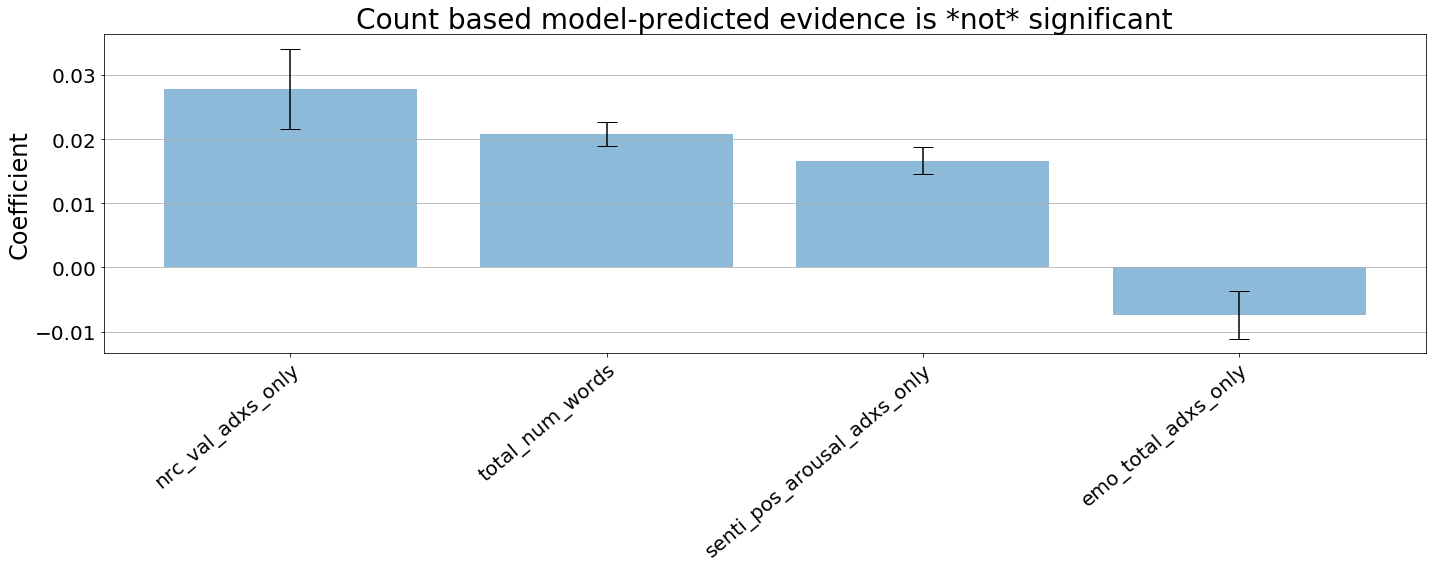

In [163]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=False, all3=False, ev_feat='num_evidence_chunks', 
              log_count=False, zscore_dummies=True)
# back to 1 feature at a time, now count-based--`num_evidence_chunks` *not* significant
plot_coeffs(fit_, "Count based model-predicted evidence is *not* significant")

In [44]:
# do_reg(bin_ev=False, all3=False, ev_feat='num_evidence_chunks', log_count=False, zscore_dummies=False)
# # z-scoring doesn't make a diff

Using 1 single count ev. predictor (-log transform).
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'nrc_val_adxs_only', 'emo_total_adxs_only', 'num_evidence_kws', 'total_num_words']

Getting z-scores (incl. dummy variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:02,  2.41it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  2.52it/s]

	nrc_val_adxs_only
	emo_total_adxs_only
	num_evidence_kws


 83%|████████▎ | 5/6 [00:01<00:00,  4.91it/s]

	total_num_words


100%|██████████| 6/6 [00:01<00:00,  4.01it/s]



Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:01,  3.78it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  3.57it/s]

	nrc_val_adxs_only


 50%|█████     | 3/6 [00:00<00:00,  3.55it/s]

	emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:00,  3.50it/s]

	num_evidence_kws


100%|██████████| 6/6 [00:01<00:00,  4.18it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1.01  num_evidence_kws
1  1.05  senti_pos_arousal_adxs_only
2  1.07  senti_neg_arousal_adxs_only
3  1.19  nrc_val_adxs_only
4  1.22  emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692941
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1203509
Model:                          Logit   Df Residuals:                  1203503
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.411
Time:                        09:36:48   Log-Likelihood:            -8.3396e+05
converged:                       True   LL-Null:                   -1.5414e+05
Covariance Type:  

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.011307,3.823490e-08,0.002056
senti_neg_arousal_adxs_only,0.001673,4.236786e-01,0.002091
nrc_val_adxs_only,0.036672,1.925823e-09,0.006108
emo_total_adxs_only,-0.008113,2.544797e-02,0.003631
num_evidence_kws,-0.030465,2.800088e-58,0.001893
total_num_words,0.023769,1.104583e-38,0.001827


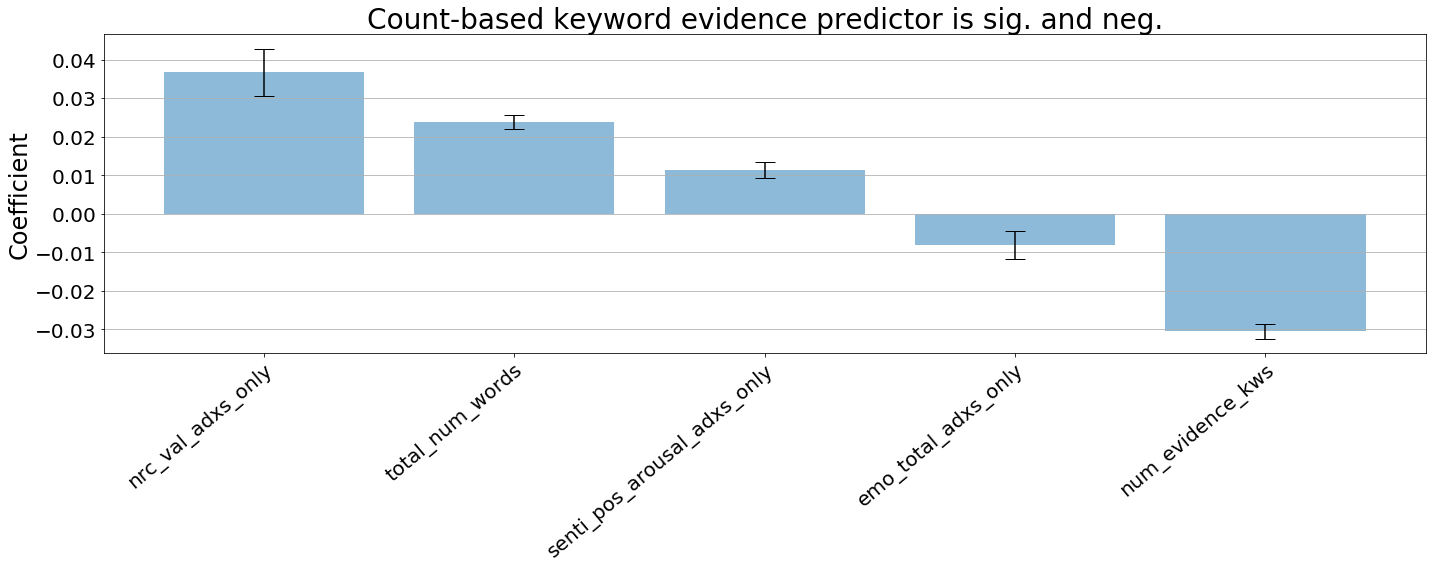

In [125]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=False, all3=False, ev_feat='num_evidence_kws', 
              log_count=False, zscore_dummies=True)
# `num_evidence_kws` *is* sig. (w/ neg. coeff.)
plot_coeffs(fit_, "Count-based keyword evidence predictor is sig. and neg.")

Using 1 single count ev. predictor (-log transform).
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'nrc_val_adxs_only', 'emo_total_adxs_only', 'num_urls', 'total_num_words']

Getting z-scores (incl. dummy variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:02,  2.43it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  2.52it/s]

	nrc_val_adxs_only
	emo_total_adxs_only
	num_urls


 83%|████████▎ | 5/6 [00:01<00:00,  4.90it/s]

	total_num_words


100%|██████████| 6/6 [00:01<00:00,  4.00it/s]



Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:01,  3.84it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  3.66it/s]

	nrc_val_adxs_only


 50%|█████     | 3/6 [00:00<00:00,  3.68it/s]

	emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:00,  3.67it/s]

	num_urls


100%|██████████| 6/6 [00:01<00:00,  4.41it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1.04  num_urls
2  1.07  senti_neg_arousal_adxs_only
1  1.08  senti_pos_arousal_adxs_only
3  1.19  nrc_val_adxs_only
4  1.22  emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692935
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1203509
Model:                          Logit   Df Residuals:                  1203503
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.410
Time:                        09:39:00   Log-Likelihood:            -8.3395e+05
converged:                       True   LL-Null:                   -1.5414e+05
Covariance Type:          

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.017269,1.218230e-16,0.002085
senti_neg_arousal_adxs_only,0.003586,8.669603e-02,0.002093
nrc_val_adxs_only,0.021543,4.228553e-04,0.006111
emo_total_adxs_only,-0.009607,8.185268e-03,0.003633
num_urls,-0.032967,2.422381e-61,0.001995
total_num_words,0.023758,1.003653e-38,0.001825


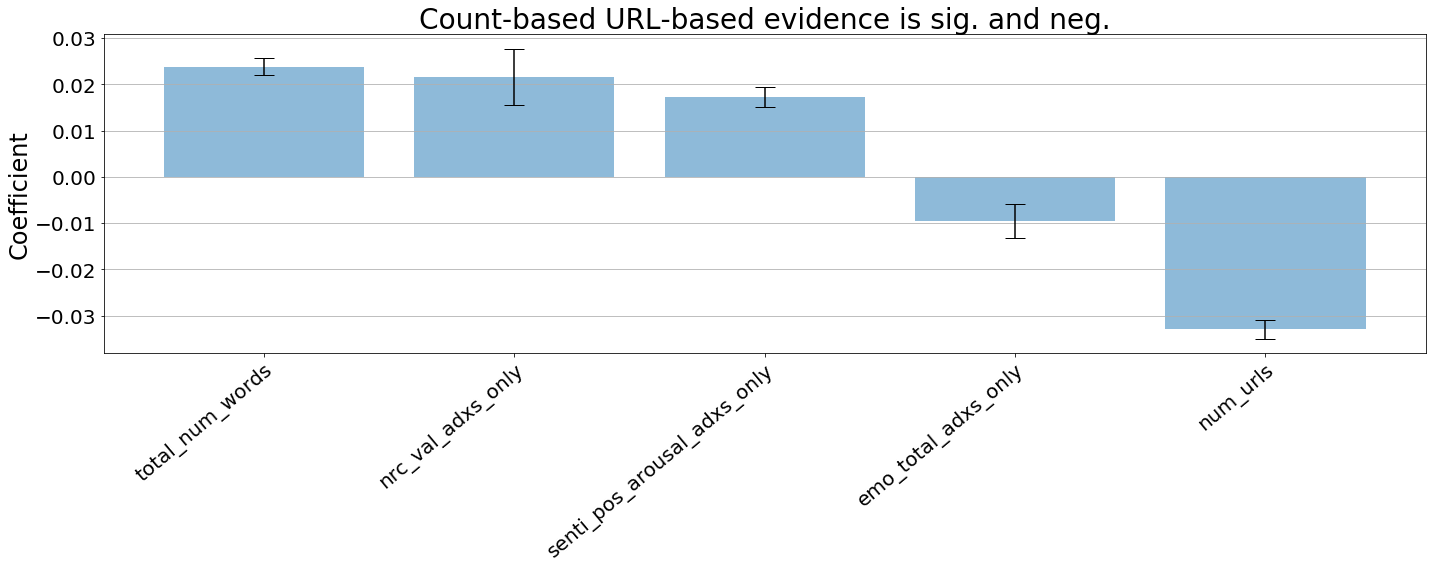

In [128]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=False, all3=False, ev_feat='num_urls', log_count=False, zscore_dummies=True)
# `num_urls` also sig. (w/ neg. coeff.)
plot_coeffs(fit_, "Count-based URL-based evidence is sig. and neg.")

Using 1 single count ev. predictor (+log transform).
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'log_nrc_val_adxs_only', 'log_emo_total_adxs_only', 'log_num_evidence_chunks', 'log_mean_num_words']

Getting z-scores (incl. dummy variables)...


100%|██████████| 6/6 [00:00<00:00, 53.01it/s]


	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only
	log_nrc_val_adxs_only
	log_emo_total_adxs_only
	log_num_evidence_chunks
	log_mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:01,  3.87it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  3.57it/s]

	log_nrc_val_adxs_only


 50%|█████     | 3/6 [00:00<00:00,  3.53it/s]

	log_emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:00,  3.50it/s]

	log_num_evidence_chunks


100%|██████████| 6/6 [00:01<00:00,  4.18it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1     log_num_evidence_chunks
6  1     log_mean_num_words
2  1.06  senti_neg_arousal_adxs_only
1  1.08  senti_pos_arousal_adxs_only
3  1.24  log_nrc_val_adxs_only
4  1.31  log_emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692605
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143289
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.241
Time:                        10:16:47   Log-Likelihood:            -7.9185e+05
converged:                       True   LL-Null:      

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.005846,1.248243e-02,0.002340
senti_neg_arousal_adxs_only,-0.010036,1.643747e-05,0.002329
log_nrc_val_adxs_only,0.008417,7.210759e-02,0.004680
log_emo_total_adxs_only,0.003807,2.592661e-01,0.003374
log_num_evidence_chunks,0.001651,3.954803e-01,0.001943
log_mean_num_words,0.064727,1.338680e-260,0.001877


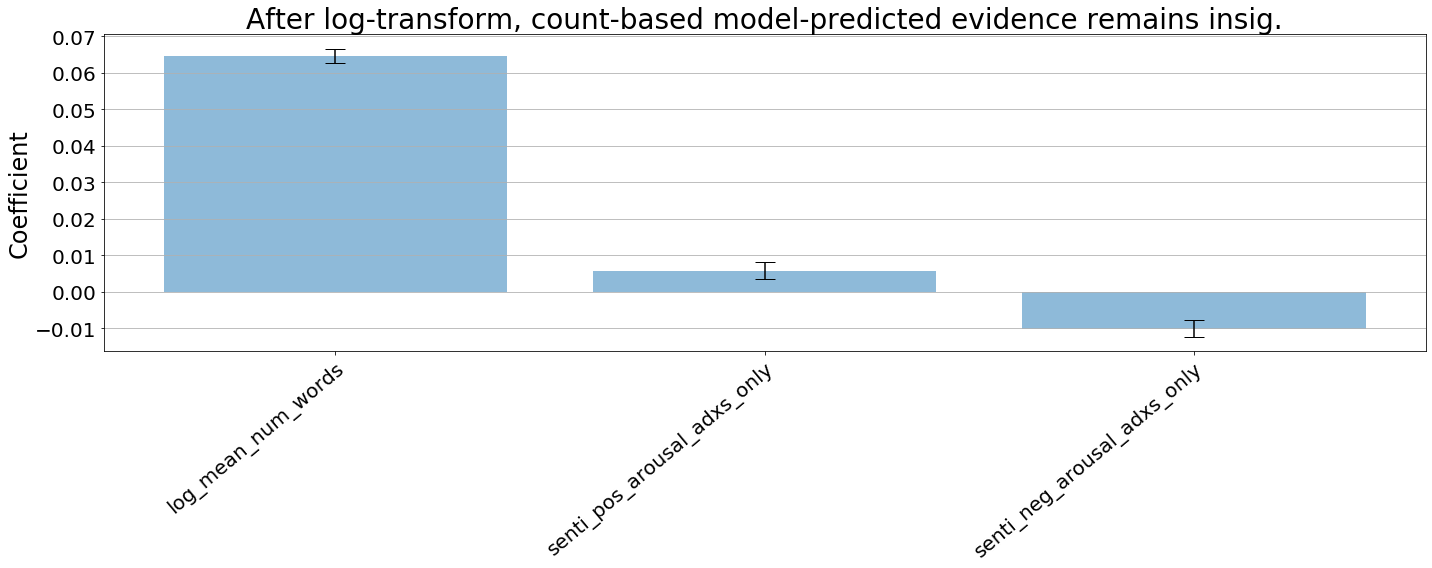

In [176]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=False, all3=False, ev_feat='num_evidence_chunks', 
              log_count=True, zscore_dummies=True)
# after log-transforming, `log_num_evidence_chunks` slightly sig. (w/ + coeff.)
plot_coeffs(fit_, "After log-transform, count-based model-predicted evidence remains insig.")

Using 1 single count ev. predictor (+log transform).
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'log_nrc_val_adxs_only', 'log_emo_total_adxs_only', 'log_num_evidence_kws', 'log_mean_num_words']

Getting z-scores (excl. dummy variables)...


 17%|█▋        | 1/6 [00:00<00:00,  6.59it/s]

	senti_pos_arousal_adxs_only
	senti_neg_arousal_adxs_only


100%|██████████| 6/6 [00:00<00:00, 19.53it/s]


	log_nrc_val_adxs_only
	log_emo_total_adxs_only
	log_num_evidence_kws
	log_mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:02,  2.11it/s]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:00<00:01,  2.05it/s]

	log_nrc_val_adxs_only


 50%|█████     | 3/6 [00:01<00:01,  2.04it/s]

	log_emo_total_adxs_only


 67%|██████▋   | 4/6 [00:01<00:00,  2.02it/s]

	log_num_evidence_kws


100%|██████████| 6/6 [00:02<00:00,  2.43it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
5  1.01  log_num_evidence_kws
6  1.01  log_mean_num_words
2  1.06  senti_neg_arousal_adxs_only
1  1.08  senti_pos_arousal_adxs_only
3  1.24  log_nrc_val_adxs_only
4  1.31  log_emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692273
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143289
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.239
Time:                        10:20:33   Log-Likelihood:            -7.9147e+05
converged:                       True   LL-Null:         

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.004422,5.890182e-02,0.002341
senti_neg_arousal_adxs_only,-0.012302,1.305718e-07,0.002331
log_nrc_val_adxs_only,0.012006,1.033220e-02,0.004682
log_emo_total_adxs_only,0.004325,2.000631e-01,0.003375
log_num_evidence_kws,-0.052795,4.569848e-167,0.001916
log_mean_num_words,0.070105,3.073088e-302,0.001887


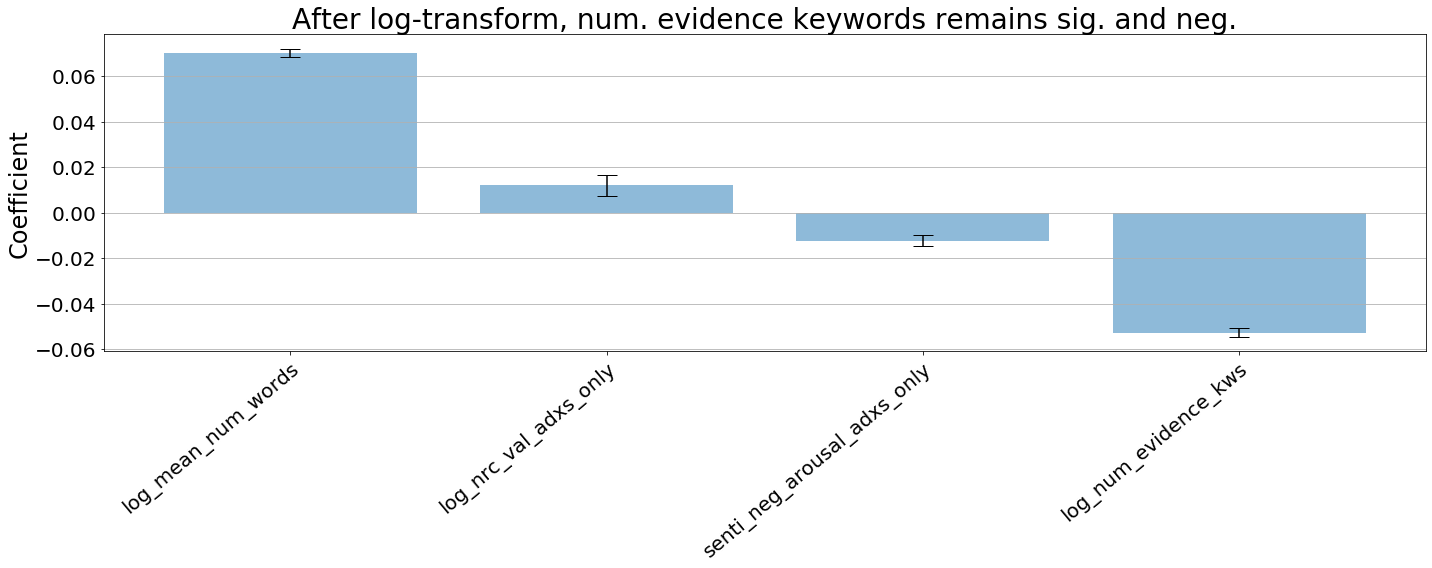

In [179]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=False, all3=False, ev_feat='num_evidence_kws', log_count=True, zscore_dummies=False)
# after log-transforming, `log_num_evidence_kws` still sig. (w/ -coeff.)
plot_coeffs(fit_, "After log-transform, num. evidence keywords remains sig. and neg.")

Using 1 single count ev. predictor (+log transform).
Using the following features in overall regression: ['senti_pos_arousal_adxs_only', 'senti_neg_arousal_adxs_only', 'log_nrc_val_adxs_only', 'log_emo_total_adxs_only', 'log_num_urls', 'log_mean_num_words']

Getting z-scores (excl. dummy variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:00<00:01,  2.64it/s]

	senti_neg_arousal_adxs_only


100%|██████████| 6/6 [00:00<00:00,  9.00it/s]


	log_nrc_val_adxs_only
	log_emo_total_adxs_only
	log_num_urls
	log_mean_num_words

Getting residuals of z-scored variables (excl. len variables)...


  0%|          | 0/6 [00:00<?, ?it/s]

	senti_pos_arousal_adxs_only


 17%|█▋        | 1/6 [00:01<00:05,  1.03s/it]

	senti_neg_arousal_adxs_only


 33%|███▎      | 2/6 [00:01<00:03,  1.05it/s]

	log_nrc_val_adxs_only


 50%|█████     | 3/6 [00:02<00:02,  1.09it/s]

	log_emo_total_adxs_only


 67%|██████▋   | 4/6 [00:03<00:01,  1.10it/s]

	log_num_urls


100%|██████████| 6/6 [00:04<00:00,  1.30it/s]




Calculating VIF scores (this takes a while)...
-  ----  ---------------------------
0  1     Intercept
6  1     log_mean_num_words
5  1.02  log_num_urls
2  1.06  senti_neg_arousal_adxs_only
1  1.09  senti_pos_arousal_adxs_only
3  1.24  log_nrc_val_adxs_only
4  1.33  log_emo_total_adxs_only
-  ----  ---------------------------
	Found 0 collinear features.
Optimization terminated successfully.
         Current function value: 0.692485
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:         outcome_+delta   No. Observations:              1143295
Model:                          Logit   Df Residuals:                  1143289
Method:                           MLE   Df Model:                            5
Date:                Mon, 28 Feb 2022   Pseudo R-squ.:                  -4.240
Time:                        11:56:24   Log-Likelihood:            -7.9171e+05
converged:                       True   LL-Null:                 

,coeff,pval,stderr
senti_pos_arousal_adxs_only,0.010004,2.132549e-05,0.002354
senti_neg_arousal_adxs_only,-0.007461,1.392167e-03,0.002334
log_nrc_val_adxs_only,0.007265,1.205384e-01,0.004680
log_emo_total_adxs_only,-0.001877,5.800173e-01,0.003392
log_num_urls,-0.031482,7.341562e-62,0.001897
log_mean_num_words,0.065383,4.166622e-266,0.001876


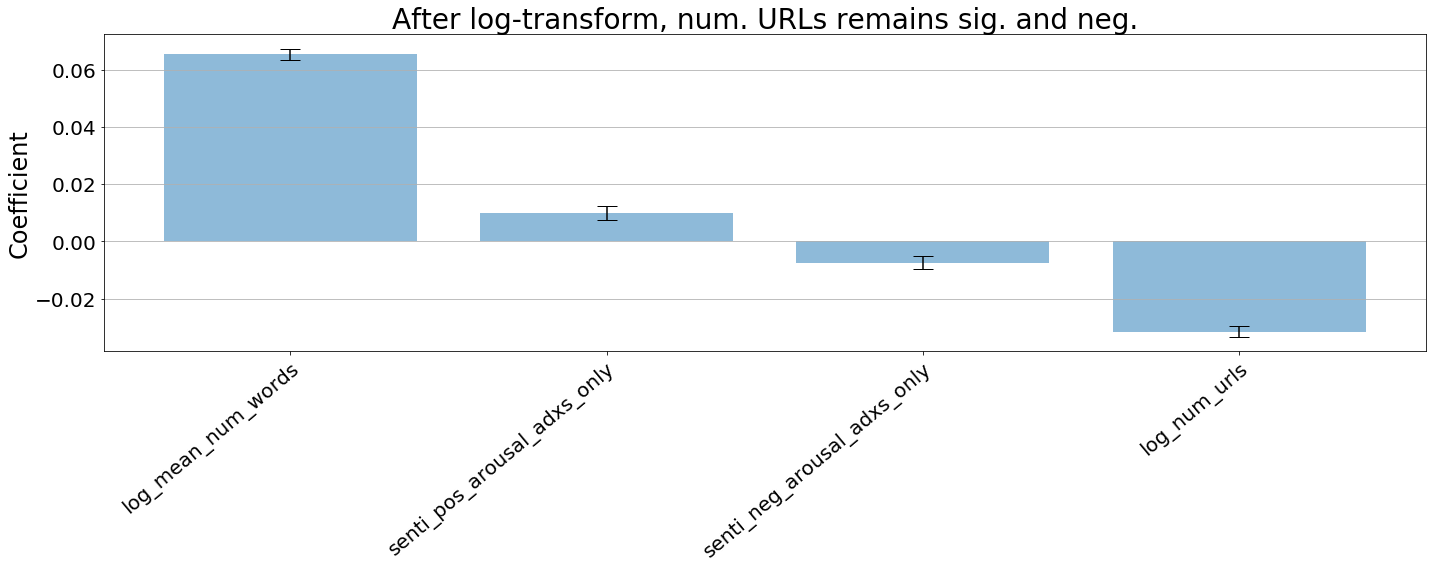

In [56]:
fit_,_ = do_reg(reg_df.copy(), bin_ev=False, all3=False, ev_feat='num_urls', log_count=True, zscore_dummies=False)
# after log-transforming, `log_urls` still sig. (w/ -coeff.)
plot_coeffs(fit_, "After log-transform, num. URLs remains sig. and neg.")

In [55]:
# def get_zscores(reg_df):
#     """Computes z-scores for all features in a DataFrame."""

#     print('\nGetting zscores...')
#     zscored_feats = {}
#     for feat in tqdm(reg_df.columns):
#         if feat in {'has_person'} or feat.startswith('topic_'):
#             zscored_feats[f'{feat}_zscored'] = reg_df[feat].values
#         else:
#             zscored_feats[f'{feat}_zscored'] = stats.zscore(reg_df[feat].values)
#     print('\tDone!')

#     return zscored_feats

import statsmodels.formula.api as sm_api
#import statsmodels.api as sm
import statsmodels.discrete.discrete_model as sm
from tabulate import tabulate

def get_residuals(data,feats_dict,resid_by='len_zscored'):
    """Computes residuals for all features (except log(length)) using log(length)."""

    print('\nGetting residuals...')
    resid_feats_dict = {}
    for feat in feats_dict:
        if 'num_words' not in feat:
            print("Getting residual of {}...".format(feat))
            resid_feats_dict[feat+'_resid'] = sm_api.ols(formula='{} ~ {}'.format(feat,resid_by), 
                                                         data=data).fit().resid
        else:
            resid_feats_dict[feat] = feats_dict[feat]
    print('\tDone!')

    return resid_feats_dict
    
def get_VIF(ind_vars, base_df, threshold=5):
    """Calculates the variance inflation factor for each feature to determine which are collinear."""
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from patsy import dmatrices

    print('\nCalculating VIF scores (this takes a while)...')
    features = "+".join([f for f in ind_vars if 'total_num_words' not in f])
    # choice of Y does not matter
    y_, X_ = dmatrices('total_num_words ~' + features, base_df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X_.values, i) for i in range(X_.shape[1])]
    vif["feature"] = X_.columns
    print(tabulate(vif.round(2).sort_values('VIF Factor')))
    collinear_feats = vif.loc[vif["VIF Factor"]>=threshold]["feature"].values
    print('\tFound {} collinear features.'.format(len(collinear_feats)))
    
    return collinear_feats
    
def get_formulas(dep_vars, ind_vars, collinear_feats):
    """Creates regression formulas, excluding collinear variables."""
    print('\nGetting regression formulas...')
    formulas = []
    for y in dep_vars:
        if len(collinear_feats) == 0:
            formulas.append('{} ~ {}'.format(y,' + '.join(ind_vars)))
        else:
            for feat in collinear_feats:
                # keep only 1 feature among collinear features
                formulas.append('{} ~ {}'.format(
                    y,' + '.join([x for x in ind_vars if x not in collinear_feats or x == feat])))
    return formulas
        
def fit(y,x,reg_df_):
    """Calls the statsmodels `fit` function and returns resulting model."""
    fit_ = sm.Logit(reg_df_[y], reg_df_[x]).fit()
    return fit_

def regress(ys,x,reg_df,out_dir,sig_threshold=0.001): 
    """Regresses different subsets of data, and also loops over different formulas."""
    print('\nDoing regressions...')
    results_list = []
    for y in ys:
        result = fit(y, x, reg_df)
        df_ = pd.concat([result.params,result.pvalues,result.bse],axis=1)
        df_.columns = ['coeff','pvalue','stderr']
        #df_['subset'] = [subset]*len(df_)
        df_['y_var'] = [y]*len(df_)
        #df_['formula'] = [formula]*len(df_)
        results_list.append(df_)

    results_df = pd.concat(results_list,axis=0)
    sig_results_df = results_df.loc[(results_df['pvalue']<sig_threshold)].copy()
    print('Found {} significant coefficients from {} coefficients total.'.format(
        len(sig_results_df),len(results_df)))
    sig_results_df['predictor'] = sig_results_df.index.copy()
    sig_results_df.reset_index(drop=True,inplace=True)
    sig_results_df = sig_results_df.loc[sig_results_df['predictor']!='Intercept']
    sig_results_df['pretty_pred'] = sig_results_df['predictor'].apply(
        lambda x: x.replace('_zscored','').replace('_resid',''))
    sig_results_df.to_csv(os.path.join(out_dir,'sig_results.tsv'),
                            sep='\t',header=True,index=False)
    results_df.to_csv(os.path.join(out_dir,'full_results.tsv'),
                            sep='\t',header=True,index=False)
    return (sig_results_df,results_list)

def batch_regress(self,out_dir): 
    """Regresses different subsets of data, and also loops over different formulas."""
    print('\nDoing regressions...')
    results_list = []
    for _,subset in enumerate(self.subsets):
        print('Regressing subset with:',subset.replace('_',' ').upper())
        if subset == 'all_posts':
            reg_df = self.base_df
        elif subset == 'posts_without_links':
            reg_df = self.no_links_df
        elif subset == 'conservative_posts':
            reg_df = self.conservative_df
        elif subset == 'non_conservative_posts':
            reg_df = self.non_conservative_df
        elif subset == 'non_zero_engagement_posts':
            reg_df = self.nonzero_eng_df

        for formula in self.formulas:
            result = self.fit(formula, reg_df)
            df_ = pd.concat([result.params,result.pvalues],axis=1)
            df_.columns = ['coeff','pvalue']
            df_['subset'] = [subset]*len(df_)
            df_['y_var'] = [formula.split(' ~ ')[0]]*len(df_)
            df_['formula'] = [formula]*len(df_)
            results_list.append(df_)

    results_df = pd.concat(results_list,axis=0)
    sig_results_df = results_df.loc[(results_df['pvalue']<0.001)].copy()
    print('Found {} significant coefficients from {} coefficients total.'.format(
        len(sig_results_df),len(results_df)))
    sig_results_df['predictor'] = sig_results_df.index.copy()
    sig_results_df.reset_index(drop=True,inplace=True)
    sig_results_df = sig_results_df.loc[sig_results_df['predictor']!='Intercept']
    sig_results_df['pretty_pred'] = sig_results_df['predictor'].apply(
        lambda x: x.replace('_zscore','').replace('_resid',''))
    self.sig_results = sig_results_df
    self.sig_results.to_csv(os.path.join(out_dir,'sig_results.tsv'),
                            sep='\t',header=True,index=False)
    results_df.to_csv(os.path.join(out_dir,'full_results.tsv'),
                            sep='\t',header=True,index=False)

def plot_coefficients(results,feature_set,savename):
    """Plots the coefficients of regression."""

    data_to_plot = results.loc[results['pretty_pred'].isin(feature_set)]
    #data_to_plot = data_to_plot.loc[data_to_plot['subset']==subset]
    if len(data_to_plot) > 0:
        data_to_plot = data_to_plot.sort_values('coeff',ascending=False,inplace=False)
        
        fig,ax = plt.subplots(figsize=(20,8))
        x_pos = np.arange(len(data_to_plot['coeff']))
        ax.bar(x_pos, data_to_plot['coeff'], yerr=data_to_plot['stderr'], 
               align='center', alpha=0.5, ecolor='black', capsize=10)
        ax.set_ylabel("Coefficient",fontsize=24)
        ax.yaxis.grid(True)
        ax.set_xlabel("",fontsize=24)
        ax.xaxis.set_ticks(np.arange(x_pos[0], x_pos[-1]+1, 1))
        ax.set_xticklabels(data_to_plot['pretty_pred'],rotation=90,fontsize=20)
        plt.yticks(fontsize=20)
        #plt.title('Logistic regression results',fontsize=28)
        #plt.legend(fontsize='x-large', title_fontsize='40')
        plt.tight_layout()
        fig.savefig(savename+'.png')
    else:
        print('No data to plot.')

In [68]:
def plot_coeffs(fit_, title, SIG_THRESH = 0.05):
    
    res_df = pd.concat([fit_.params,fit_.pvalues,fit_.bse],axis=1)
    res_df.columns = ['coeff','pval','stderr']
    display(res_df)

    data_to_plot = res_df.loc[res_df['pval']<SIG_THRESH]
    data_to_plot = data_to_plot.sort_values('coeff',ascending=False,inplace=False)

    fig,ax = plt.subplots(figsize=(20,8))
    x_pos = np.arange(len(data_to_plot['coeff']))
    ax.bar(x_pos, data_to_plot['coeff'], yerr=data_to_plot['stderr'], 
           align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel("Coefficient",fontsize=24)
    ax.yaxis.grid(True)
    ax.set_xlabel("",fontsize=24)
    ax.xaxis.set_ticks(np.arange(x_pos[0], x_pos[-1]+1, 1))
    ax.set_xticklabels(data_to_plot.index,rotation=40,fontsize=20,ha='right',rotation_mode='anchor')
    plt.yticks(fontsize=20)
    plt.title(title,fontsize=28)
    plt.tight_layout()

,coeff,pval,stderr
senti_pos_arousal_all,0.001037,5.709029e-01,0.001829
senti_neg_arousal_all,-0.001027,5.895959e-01,0.001903
nrc_val_all,0.006302,6.470054e-04,0.001848
emo_total_all,-0.006058,1.566684e-03,0.001916
has_evidence_True,0.003025,9.802263e-02,0.001828
total_num_words,-0.031172,8.144648e-41,0.002330
mean_num_words,0.089318,0.000000e+00,0.002366


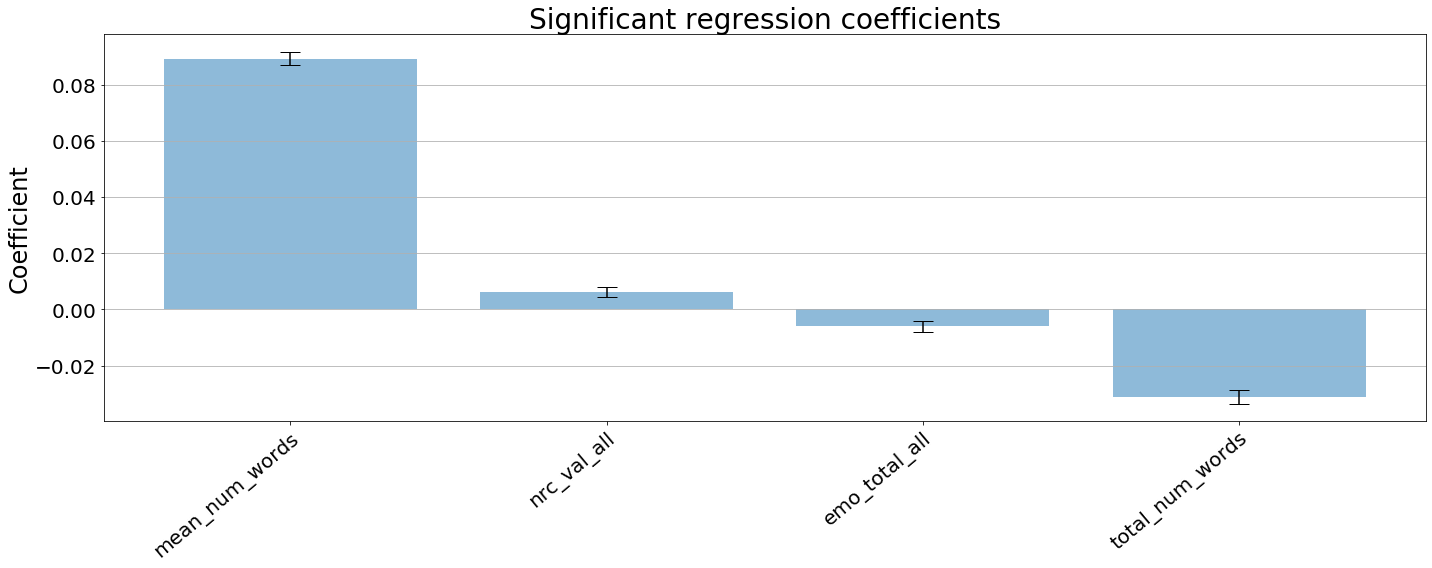

In [69]:
plot_coeffs(fit_,'Significant regression coefficients')

# Inspect extreme examples

TO DO: Adjudicate between whether `all` or `adxs_only` scheme is better.

In [143]:
#reg_df.sort_values('nrc_val_all',ascending=False.subtree_outcome_utt_id','subtree_text','nrc_val_all']]

In [150]:
#_.sort_values('nrc_val_all',ascending=False).head()[['subtree_outcome_utt_id','subtree_text','nrc_val_all']]

In [61]:
_.sort_values('nrc_val_adxs_only',ascending=False).head(10)[['subtree_outcome_utt_id','counted_nrc_adxs',
                                                       'nrc_val_adxs_only','num_urls']]

,subtree_outcome_utt_id,counted_nrc_adxs,nrc_val_adxs_only,num_urls
36537,t1_fwi4egi,"{'necessary': 1, 'suddenly': 1, 'rich': 1, 'extensive': 1, 'white': 8, 'current': 1, 'mechanical': 1, 'subject': 2, 'good': 5, 'poor': 4, 'relative': 4, 'innocent': 2, 'disciplinary': 1, 'criminal': 6, 'negative': 1, 'essential': 1, 'interested': 8, 'behavioral': 1, 'different': 4, 'old': 1, 'low': 7, 'actual': 3, 'essentially': 1, 'black': 8, 'past': 3, 'frequently': 3, 'second': 3, 'federal': 3, 'strongly': 1, 'discretionary': 1, 'equally': 2, 'new': 1, 'negligible': 2, 'equivalent': 1, 'first': 4, 'young': 3, 'less': 8, 'juvenile': 2, 'similar': 5, 'racial': 8, 'likely': 8, 'widespread': 4, 'large': 7, 'identical': 4, 'particular': 3, 'consistent': 4, 'differential': 3, 'ethnic': 4, 'skilled': 1, 'strong': 2, 'wealthy': 1, 'public': 3, 'adult': 1, 'qualified': 2, 'slightly': 1, 'other': 8, 'certain': 1, 'alone': 3, 'intact': 1, 'early': 2, 'high': 8, 'direct': 2, 'positive': 1, 'mental': 1, 'related': 4, 'modest': 1, 'usual': 1, 'popular': 1, 'important': 4, 'approximately': 4, 'hourly': 1, 'previous': 1, 'illegal': 2, 'legitimate': 1, 'attributable': 1, 'occupational': 1, 'generally': 2, 'quality': 1, 'minority': 1, 'constant': 1, 'major': 2, 'professional': 1, 'middle': 2, 'educational': 1, 'average': 5, 'unfair': 1, 'equal': 2, 'full': 1, 'key': 1, 'great': 5, 'roughly': 2, 'median': 1, 'bad': 1, 'weekly': 1, 'little': 2, 'typical': 1, 'strikingly': 1, 'ago': 1, 'slow': 2, 'local': 3, ...}",529.645,12
242162,t1_fukg2ct,"{'rich': 1, 'extensive': 1, 'white': 8, 'current': 1, 'mechanical': 1, 'subject': 2, 'good': 5, 'poor': 3, 'relative': 3, 'innocent': 2, 'disciplinary': 1, 'criminal': 6, 'negative': 1, 'essential': 1, 'interested': 8, 'behavioral': 1, 'different': 4, 'old': 1, 'low': 7, 'actual': 3, 'essentially': 1, 'black': 8, 'past': 3, 'frequently': 3, 'second': 3, 'federal': 4, 'strongly': 1, 'discretionary': 1, 'equally': 2, 'new': 1, 'negligible': 1, 'equivalent': 1, 'first': 3, 'young': 2, 'less': 8, 'juvenile': 2, 'similar': 5, 'racial': 8, 'likely': 8, 'widespread': 4, 'large': 7, 'identical': 4, 'particular': 3, 'consistent': 4, 'differential': 3, 'ethnic': 5, 'skilled': 1, 'strong': 2, 'wealthy': 1, 'public': 3, 'adult': 1, 'qualified': 2, 'slightly': 1, 'other': 8, 'certain': 1, 'alone': 2, 'intact': 1, 'early': 2, 'high': 8, 'direct': 2, 'positive': 1, 'mental': 1, 'related': 4, 'modest': 1, 'usual': 1, 'popular': 1, 'important': 4, 'approximately': 4, 'hourly': 1, 'previous': 1, 'illegal': 2, 'legitimate': 1, 'attributable': 1, 'occupational': 1, 'generally': 2, 'quality': 1, 'minority': 1, 'constant': 1, 'major': 2, 'professional': 1, 'middle': 2, 'educational': 1, 'average': 4, 'unfair': 1, 'equal': 2, 'full': 1, 'key': 1, 'great': 5, 'roughly': 2, 'median': 1, 'bad': 1, 'weekly': 1, 'little': 2, 'typical': 1, 'strikingly': 1, 'ago': 1, 'slow': 2, 'local': 2, 'available': 3, 'recent': 3, ...}",519.521,11
841293,t1_dzw87ii,"{'physical': 2, 'common': 3, 'white': 9, 'racist': 5, 'good': 7, 'happy': 4, 'sexual': 7, 'legal': 5, 'interested': 2, 'difficult': 4, 'different': 7, 'illegal': 3, 'dangerous': 3, 'feminist': 2, 'domestic': 5, 'free': 6, 'generally': 4, 'essentially': 1, 'black': 4, 'past': 2, 'sure': 5, 'excellent': 1, 'responsible': 1, 'strongly': 1, 'invariably': 1, 'plain': 1, 'aware': 1, 'great': 3, 'liberal': 4, 'serious': 4, 'immigrant': 2, 'dear': 1, 'bad': 6, 'likely': 6, 'vague': 1, 'little': 4, 'large': 5, 'particular': 4, 'safe': 1, 'clever': 1, 'conservative': 8, 'affirmative': 1, 'slightly': 2, 'honest': 1, 'other': 7, 'tiny': 2, 'high': 7, 'reverse': 3, 'inaccurate': 1, 'mainstream': 7, 'punitive': 1, 'critical': 1, 'moderate': 2, 'broad': 2, 'prominent': 5, 'wrong': 1, 'weak': 2, 'wide': 1, 'specific': 5, 'rural': 2, 'less': 6, 'primary': 1, 'urban': 1, 'male': 5, 'right': 6, 'long': 4, 'recent': 3, 'systematic': 2, 'female': 3, 'peaceful': 2, 'stupid': 2, 'expensive': 1, 'characteristic': 1, 'correct

In [62]:
_.sort_values('nrc_val_all',ascending=False).head(10)[['subtree_outcome_utt_id','counted_nrc_all',
                                                       'nrc_val_all','num_urls']]

,subtree_outcome_utt_id,counted_nrc_all,nrc_val_all,num_urls
36537,t1_fwi4egi,"{'belief': 2, 'racist': 1, 'have': 9, 'country': 4, 'racism': 3, 'child': 3, 'be': 9, 'disappear': 1, 'think': 1, 'necessary': 1, 'spread': 1, 'day': 5, 'suppose': 1, 'go': 4, 'make': 7, 'do': 7, 'happen': 2, 'slap': 1, 'call': 2, 'would': 3, 'law': 4, 'eradicate': 1, 'stop': 5, 'suddenly': 1, 'change': 3, 'work': 4, 'mind': 2, 'ignore': 1, 'put': 2, 'remain': 6, 'include': 6, 'woman': 3, 'total': 3, 'diversity': 2, 'experience': 4, 'variable': 4, 'conviction': 3, 'follow': 3, 'good': 5, 'innocent': 2, 'suspend': 1, 'resource': 8, 'criminal': 7, 'face': 5, 'like': 3, 'behavioral': 1, 'basis': 2, 'sector': 2, 'trace': 1, 'boy': 1, 'association': 2, 'serve': 4, 'district': 4, 'release': 5, 'claim': 1, 'get': 3, 'kindergarten': 1, 'poverty': 3, 'federal': 3, 'five': 6, 'prompt': 1, 'strongly': 1, 'market': 2, 'strap': 1, 'stay': 1, 'consideration': 1, 'ape': 1, 'two': 7, 'increase': 8, 'likelihood': 4, 'justice': 4, 'cause': 2, 'imagine': 2, 'part': 8, 'sample': 2, 'endorsement': 2, 'relate': 2, 'spend': 3, 'can': 4, 'likely': 8, 'reference': 2, 'fact': 3, 'wage': 2, 'will': 2, 'isolate': 2, 'cover': 2, 'say': 1, 'skilled': 1, 'family': 2, 'adoption': 1, 'life': 3, 'troublemaker': 1, 'public': 3, 'drug': 7, 'level': 5, 'top': 1, 'lead': 4, 'certain': 1, 'alone': 3, 'intact': 1, ...}",2828.607,12
242162,t1_fukg2ct,"{'remain': 7, 'include': 6, 'woman': 3, 'total': 3, 'diversity': 2, 'experience': 4, 'variable': 4, 'conviction': 3, 'follow': 3, 'good': 5, 'innocent': 2, 'suspend': 1, 'resource': 8, 'criminal': 6, 'face': 5, 'like': 3, 'behavioral': 1, 'basis': 2, 'sector': 2, 'trace': 1, 'boy': 1, 'association': 2, 'serve': 4, 'district': 4, 'release': 4, 'child': 2, 'claim': 1, 'get': 3, 'kindergarten': 1, 'be': 8, 'poverty': 2, 'federal': 4, 'five': 6, 'prompt': 1, 'strongly': 1, 'market': 2, 'strap': 1, 'stay': 1, 'consideration': 1, 'ape': 1, 'two': 7, 'increase': 7, 'likelihood': 4, 'justice': 4, 'cause': 2, 'imagine': 2, 'part': 8, 'sample': 3, 'endorsement': 2, 'relate': 1, 'spend': 3, 'can': 4, 'likely': 8, 'reference': 2, 'fact': 2, 'wage': 2, 'go': 3, 'will': 2, 'isolate': 2, 'cover': 2, 'say': 1, 'skilled': 1, 'family': 2, 'adoption': 1, 'life': 3, 'troublemaker': 1, 'public': 3, 'drug': 7, 'level': 6, 'top': 1, 'lead': 4, 'certain': 1, 'alone': 2, 'intact': 1, 'discrimination': 6, 'early': 2, 'save': 8, 'young': 2, 'reverse': 1, 'accord': 4, 'rich': 1, 'essence': 1, 'white': 8, 'shift': 1, 'body': 2, 'report': 6, 'behavior': 1, 'half': 4, 'pattern': 3, 'percent': 8, 'man': 4, 'ad': 1, 'demonstrate': 2, 'data': 3, 'relative': 3, 'find': 8, 'punish': 1, 'disability': 1, 'interested': 8, 'different': 4, ...}",2757.987,11
841293,t1_dzw87ii,"{'exist': 3, 'woman': 10, 'reason': 5, 'kick': 1, 'loyalty': 1, 'media': 5, 'good': 7, 'misunderstanding': 1, 'try': 7, 'legal': 5, 'college': 4, 'like': 9, 'illegal': 3, 'boy': 2, 'seem': 5, 'indication': 1, 'aim': 1, 'claim': 9, 'get': 10, 'bubble': 1, 'be': 10, 'rate': 5, 'project': 3, 'strongly': 1, 'invariably': 1, 'welfare': 3, 'slavery': 2, 'consideration': 1, 'increase': 3, 'aware': 1, 'administration': 5, 'cause': 1, 'imagine': 1, 'part': 6, 'liberal': 10, 'sit': 3, 'matter': 2, 'can': 9, 'instance': 1, 'likely': 6, 'fact': 1, 'little': 4, 'assume': 3, 'go': 9, 'will': 8, 'front': 1, 'base': 5, 'family': 2, 'abuse': 9, 'conservative': 10, 'state': 6, 'colleague': 1, 'change': 3, 'promise': 1, 'let': 3, 'deal': 4, 'reverse': 3, 'deserve': 1, 'group': 4, 'common': 3, 'white': 10, 'man': 10, 'ally': 1, 'find': 5, 'fringe': 2, 'court': 4, 'interested': 2, 'different': 7, 'concern': 3, 'shut': 1, 'feminist': 5, 'free': 6, 'generally': 4, 'essentially': 1, 'black': 5, 'keep': 4, 'tend': 5, 'center': 2, 'use': 9, 'may': 3, 'sure': 5, 'return': 2, 'talk': 7, 'importance': 1, 'kangaroo': 2, 'decide': 2, 'convince': 1, 'campus': 4, 'responsible': 1, 'send': 1, 'see': 8, 'violence': 9, 'immigrant': 3, 'grow': 2, 

In [185]:
_.sort_values('nrc_val_all',ascending=True).head(2)[['subtree_outcome_utt_id','subtree_text',
                                                     'senti_neg_arousal_adxs_only',
                                                     'num_urls']]

,subtree_outcome_utt_id,subtree_text,senti_neg_arousal_adxs_only,num_urls
787080,t1_hb0hcue,[https://www.forbes.com/sites/siladityaray/2021/08/30/japan-finds-more-contaminants-in-moderna-vaccines-suspends-use-of-additional-1-million-doses/],0.848392,1
806230,t1_cnihpb4,[http://www.economist.com/blogs/lexington/2010/10/estate_tax_and_founding_fathers\n\n\n-],0.509139,1


In [187]:
_.sort_values('nrc_val_all',ascending=False).head(2)[['subtree_outcome_utt_id','subtree_text',
                                                     'emo_total_adxs_only',
                                                     'num_urls']]

subtree_outcome_utt_id  \
36537              t1_fwi4egi   
242162             t1_fukg2ct   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [ ]:
_.sort_values('nrc_val_all',ascending=True).head(2)[['subtree_outcome_utt_id','subtree_text',
                                                     'emo_total_adxs_only',
                                                     'num_urls']]